In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mpl_toolkits as mplot3d
import scipy as sp
pd.set_option("display.max_columns", None)
from tqdm import tqdm
tqdm.pandas()

In [2]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# DATA CLEANING AND WRANGLING

### Data Cleaning

In [3]:
# DF1 = Total and facet scores, and score per question
df00 = pd.read_csv('Indian Risk Literacy DYNATA_normal launch_2.csv')[26:]
print("Starting: ", len(df00["ResponseId"]))

# drop na in responses
df01 = df00.dropna(subset = df00.columns[19:77])
print("Post dropping NA:", len(df01["ResponseId"]))

# removing students
df01 = df01.loc[ ~(df01["Q4a"] == "Student")].copy()
print("Post removing students:", len(df01["ResponseId"]))

# removing straight liners
matrix = ["Q8_1", "Q8_2", "Q8_3", "Q8_4", "Q8_5", "Q8_6", "Q8_7", "Q8_8"]
dict = {"1 (strongly disagree)":1 , "2":2, "3":3, "4":4, "5":5, "6 (strongly agree)":6}
for ques in matrix:
    df01[ques] = df01[ques].astype(str).replace(dict)
df01["Q8_std"] = df01[matrix].std(axis = 1)
df01 = df01.loc[ df01["Q8_std"] != 0].copy()
print("Post removing straightliners:", len(df01["ResponseId"]))

# attention check
df01 = df01.loc[ df01["Attention Check"] == "Vase"].copy()
print("Post attention chaeck failures:", len(df01["ResponseId"]))

# <0.5 median time of completion filtered
df01["Duration (in seconds)"] = df01["Duration (in seconds)"].astype("Int64")
median = df01["Duration (in seconds)"].astype("Int64").median()
df01 = df01.loc[ df01["Duration (in seconds)"] >= median*0.5].copy()
print("Post removing <0.5 median time responses:", len(df01["ResponseId"]))

Starting:  4443
Post dropping NA: 963
Post removing students: 961
Post removing straightliners: 846
Post attention chaeck failures: 846
Post removing <0.5 median time responses: 699


In [4]:
df0 = df01.iloc[:, 19:77].copy().reset_index(drop = True)
df0.insert(0, "ResponseId", range(0, len(df0)))

In [5]:
df00.to_csv("Indian Risk Literacy Survey_Dynata_unfiltered v060525.csv")
df0.to_csv("Indian Risk Literacy Survey_Dynata_filtered v060525.csv")

In [5]:
df01.to_csv("Indian Risk Literacy Survey_Dynata_filtered.csv")

## Demographics

In [6]:
df0["age"] = df0["Q2"].astype(float).copy()

# Age groups/rec = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)

df0["age_rec"] = np.where( (df0["age"] >= 18) & (df0["age"] <= 35), 2,
                          np.where( (df0["age"] >= 36) & (df0["age"] <= 55), 3,
                                   np.where( (df0["age"] >= 56), 4, 0
                                           )
                                  )
                         )

# Secondary upto 10 – ISCED 3
# Senior Secondary upto 12 - ISCED 3 
# Diploma and voca – ISCED 2
# UG – ISCED 2
# PG – ISCED 1
# PhD and higher – ISCED 1

df0["isced"] = np.where(df0["Q3"] == "Post-Graduate Program", 1,
                        np.where(df0["Q3"] == "Undergraduate Program", 2,
                                 np.where(df0["Q3"] == "Ph.D. and higher", 1,
                                          np.where(df0["Q3"] == "Diploma and Vocational Training", 2,
                                                   np.where(df0["Q3"] == "Secondary School (11th to 12th Std.)", 3,
                                                            np.where( df0["Q3"] == "Primary School (up to 10th Std.)", 3,
                                                                     np.where( df0["Q3"] == "M.Phil.", 1, 0
                                                                             )
                                                                    )
                                                           )
                                                  )
                                         )
                                )
                       )

df0["income"] = np.where(df0["Q15a"] == "< INR 500,000", 1,
                         np.where(df0["Q15a"] == "INR 500,001 – INR 15,00,000", 2,
                                  np.where(df0["Q15a"] == "INR 1500,001 – INR 30,00,000", 3,
                                           np.where(df0["Q15a"] == "INR 30,00,001 – INR 50,00,000", 4,
                                                    np.where(df0["Q15a"] == "INR 50,00,001 – INR 75,00,000", 5,
                                                             np.where( df0["Q15a"] == "> INR 75,00,000", 6,0
                                                                     )
                                                            )
                                                   )
                                           )
                                  )
                         )

df0["nonwinsorised_wealth"] = df0["Q14b"].astype(float).copy()

In [7]:
def remove_indexname(series): # removes index name
    series.index.name = None
    series.name = None
    return series.to_string()

In [8]:
print("Total Observations:", df0["Q1"].count())

print(f'\nGender:\n{remove_indexname(df0["Q1"].value_counts())}')
print(f'\nOccupation:\n{remove_indexname(df0["Q4a"].value_counts())}')
print(f'\nEducation:\n{remove_indexname(df0["Q3"].value_counts())}')
print(f'\nISCED:\n{remove_indexname(df0["isced"].value_counts())}')
print(f'\nIncome:\n{remove_indexname(df0["Q15a"].value_counts().iloc[[1, 0, 2, 3, 4, 5]])}')

Total Observations: 699

Gender:
Male      361
Female    338

Occupation:
Salaried                       490
Entrepreneur/Business Owner    129
Currently not employed          68
Retired                         12

Education:
Post-Graduate Program                   225
Undergraduate Program                   206
Secondary School (11th to 12th Std.)    177
Diploma and Vocational Training          35
Primary School (up to 10th Std.)         29
Ph.D. and higher                         16
M.Phil.                                  11

ISCED:
1    252
2    241
3    206

Income:
< INR 500,000                    194
INR 500,001 – INR 15,00,000      221
INR 1500,001 – INR 30,00,000     114
INR 30,00,001 – INR 50,00,000     76
INR 50,00,001 – INR 75,00,000     52
> INR 75,00,000                   42


## Winsorizing Wealth

In [9]:
## Winsorizing Wealth

from scipy.stats.mstats import winsorize

df0["winsorised_wealth"] = winsorize(np.array(df0["nonwinsorised_wealth"]), limits = [0.1, 0.1], inclusive = [False, False])

In [10]:
df0[["nonwinsorised_wealth", "winsorised_wealth"]].describe()

nonwinsorised_wealth  winsorised_wealth
count          6.990000e+02       6.990000e+02
mean           1.628566e+08       3.129498e+06
std            3.794346e+09       4.770219e+06
min            0.000000e+00       5.000000e+03
25%            1.000000e+05       1.000000e+05
50%            6.000000e+05       6.000000e+05
75%            4.000000e+06       4.000000e+06
max            1.000000e+11       1.500000e+07

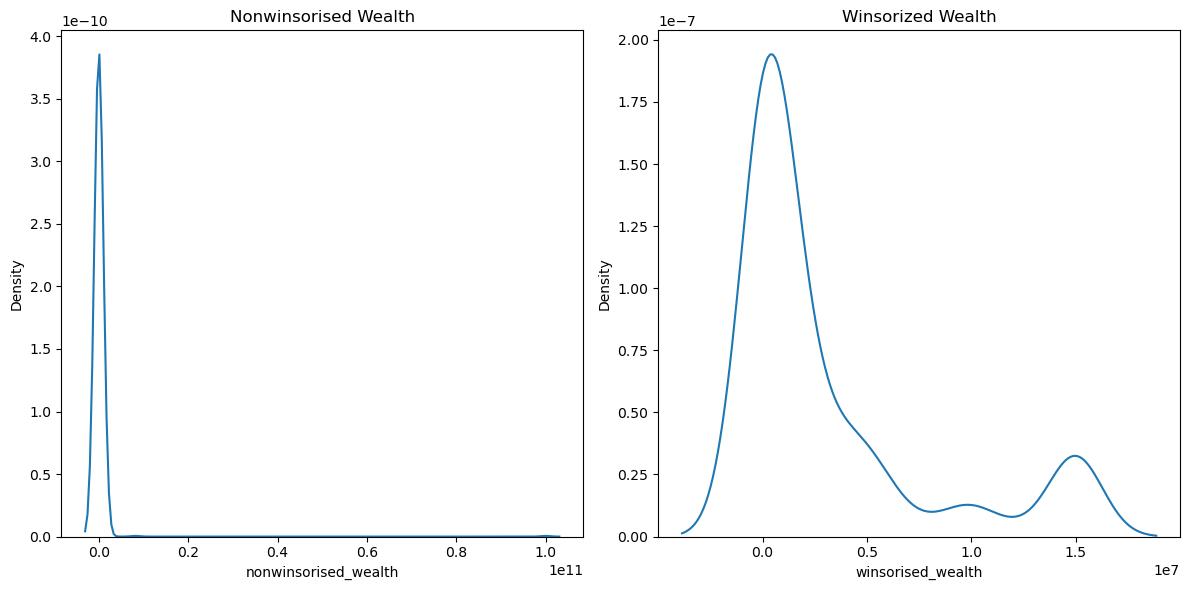

In [11]:
# WEALTH - winsorized, and non winsorized

fig, axes = plt.subplots(1, 2, figsize = (12, 6))

sns.kdeplot(data = df0["nonwinsorised_wealth"].replace([np.inf, -np.inf], np.nan), ax = axes[0])
axes[0].set_title('Nonwinsorised Wealth')

sns.kdeplot(data = df0["winsorised_wealth"].replace([np.inf, -np.inf], np.nan), ax = axes[1])
axes[1].set_title('Winsorized Wealth')

plt.tight_layout()
plt.show()

In [12]:
# Using winsorised wealth as wealth
df0["wealth"] = df0["winsorised_wealth"].copy()

## Questions

In [13]:
matchCol = ["q8_2_1", "q8_2_2", "q8_2_3", "q8_2_4", "q8_2_5", "q8_3", "q8_4", "q8_5berlin_1", 
            "q8_5london_1", "q8_5paris_1", "q8_6", "q8_7", "q9_1_1", "q9_2_1", "q9_3",
            "q10_1_1", "q10_2_1", "q10_3_1", "q10_4"]
df0[ matchCol ] = 0

In [14]:
df0.columns

Index(['ResponseId', 'Q1', 'Q2', 'Q3', 'Q4a', 'Q4.5_4', 'Q4.5_5', 'Q4.5_6',
       'Q5_1', 'Q6 - changed', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6',
       'Q8_7', 'Q8_8', 'Q9b_1', 'Q9b_4', 'Q9b_10', 'Q9b_5', 'Q9b_11', 'Q9b_12',
       'Q9b_6', 'Q9b_7', 'Q9b_8', 'Q9b_13', 'Q9b_14', 'Q9b_9', 'Q14b',
       'Q11a_1', 'Q11a_2', 'Q11a_3', 'Q11b_1', 'Q11b_2', 'Q11b_3', 'Q11b_4',
       'Q11b_5', 'Q11c', 'Q11d', 'Q11h', 'Attention Check', 'Q11i', 'Q13a',
       'Q13b', 'Q13c', 'Q13d', 'Q12a', 'Q12b', 'Q12c', 'Q14a', 'Q14b.1',
       'Q14c', 'Q54', 'Q57', 'Q58', 'Q15a', 'psid', 'age', 'age_rec', 'isced',
       'income', 'nonwinsorised_wealth', 'winsorised_wealth', 'wealth',
       'q8_2_1', 'q8_2_2', 'q8_2_3', 'q8_2_4', 'q8_2_5', 'q8_3', 'q8_4',
       'q8_5berlin_1', 'q8_5london_1', 'q8_5paris_1', 'q8_6', 'q8_7', 'q9_1_1',
       'q9_2_1', 'q9_3', 'q10_1_1', 'q10_2_1', 'q10_3_1', 'q10_4'],
      dtype='object')

In [15]:
df0["Q11b_1"].value_counts()

Q11b_1
Yes    391
No     308
Name: count, dtype: int64

In [16]:
df0["q8_2_1"] = np.where(df0["Q11b_1"] == "No", 1, 2)
df0["q8_2_2"] = np.where(df0["Q11b_2"] == "No", 1, 2)
df0["q8_2_3"] = np.where(df0["Q11b_3"] == "No", 1, 2)
df0["q8_2_4"] = np.where(df0["Q11b_4"] == "No", 1, 2)
df0["q8_2_5"] = np.where(df0["Q11b_5"] == "No", 1, 2)

df0["q8_3"] = np.where(df0["Q11c"] == "The lower the quality of the study, the more likely that future studies will change the risk estimate.", 1,
                          np.where(df0["Q11c"] == "The higher the quality of the study, the more likely that future studies will change the risk estimate.", 2,
                                  np.where(df0["Q11c"] == "Irrespective of the quality of the study, future studies will not change the risk estimate.", 3,
                                          np.where(df0["Q11c"] == "Irrespective of the quality of the study, future studies will change the risk estimate substantially anyway.", 4,0
                                                  )
                                          )
                                  )
                         )


df0["q8_4"] = np.where(df0["Q11d"] == "The growth rate will be 0.4% on average each year", 1,
                          np.where(df0["Q11d"] == "The growth rate over five years will be exactly 2%", 2,
                                  np.where(df0["Q11d"] == "The growth rate over five years will be between 1% and 3%", 3,
                                          np.where(df0["Q11d"] == "It is not possible to predict the growth rate with certainty", 4,0
                                                  )
                                          )
                                  )
                         )

In [17]:
df0["q8_5berlin_1"] = np.where(df0["Q11a_1"].astype(int) == 1, 1, 2)
df0["q8_5london_1"] = np.where(df0["Q11a_1"].astype(int) == 1, 1, 2)
df0["q8_5paris_1"] = np.where(df0["Q11a_1"].astype(int) == 1, 1, 2)

df0["q8_6"] = np.where(df0["Q11i"] == "The medication increases recovery by 100%", 1,
                          np.where(df0["Q11i"] == "The medication increases recovery by 50%", 2,
                                   np.where(df0["Q11i"] == "The medication increases recovery by 2%", 3,
                                            np.where(df0["Q11i"] == "None of the above is implied", 4, 0
                                                    )
                                           )
                                  )
                         )

df0["q8_7"] = np.where(df0["Q11h"] == "5 in 100 people prior to the intervention to 6 out of 100 people after the intervention", 1,
                          np.where(df0["Q11h"] == "100 in 10,000 people prior to the intervention to 120 out of 10,000 people after the intervention", 2,
                                   np.where(df0["Q11h"] == "70 in 100 people prior to the intervention to 90 out of 100 people after the intervention", 3,
                                            np.where(df0["Q11h"] == "It is not possible to determine which of the answers is correct given the information provided", 4, 0
                                                    )
                                           )
                                  )
                         )


df0["q9_1_1"] = df0["Q14a"].astype(float).copy()
df0["q9_2_1"] = df0["Q14b.1"].astype(float).copy()

df0["q9_3"] = np.where(df0["Q14c"] == "Crosicol", 1,
                          np.where(df0["Q14c"] == "Hertinol", 2,
                                   np.where(df0["Q14c"] == "They are equal", 3,
                                            np.where(df0["Q14c"] == "Can’t say", 4, 0
                                                    )
                                           )
                                  )
                         )

In [18]:
df0["q10_1_1"] = df0["Q13a"].astype(float).copy()
df0["q10_2_1"] = df0["Q13b"].astype(float).copy()
df0["q10_3_1"] = df0["Q13c"].astype(float).copy()

df0["q10_4"] = np.where(df0["Q13d"] == "9 out of 59", 1,
                          np.where(df0["Q13d"] == "9 out of 10", 2,
                                   np.where(df0["Q13d"] == "59 out of 1000", 3,
                                            np.where(df0["Q13d"] == "59 out of 100", 4, 0
                                                    )
                                           )
                                  )
                         )

## Scoring

In [19]:
scoreColumns = ["certainty1", "certainty2", "certainty3", "certainty4", "certainty5",
                "uncertainty1", "uncertainty2",
                "numeracy1", "numeracy2", "numeracy3", "numeracy4", "numeracy5",
                "graph1", "graph2", "graph3",
                "riskcomprehension1", "riskcomprehension2", "riskcomprehension3", "riskcomprehension4", "riskcomprehension5",
                "bayesian1"
               ]
df0[scoreColumns] = 0

In [20]:
# Assigning scores

def scoring1(surveyFacet):
    surveyFacet.loc[ surveyFacet["q8_2_1"] == 2, "certainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_2"] == 2, "certainty2"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_3"] == 2, "certainty3"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_4"] == 2, "certainty4"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_5"] == 2, "certainty5"] = 1

    surveyFacet.loc[ surveyFacet["q8_3"] == 1, "uncertainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_4"] == 4, "uncertainty2"] = 1

    surveyFacet.loc[ surveyFacet["q8_5berlin_1"] == 2, "riskcomprehension1"] = 1
    surveyFacet.loc[ surveyFacet["q8_5london_1"] == 1, "riskcomprehension2"] = 1
    surveyFacet.loc[ surveyFacet["q8_5paris_1"] == 1, "riskcomprehension3"] = 1
    
    surveyFacet.loc[ surveyFacet["q8_6"] == 1, "riskcomprehension4"] = 1
    surveyFacet.loc[ surveyFacet["q8_7"] == 4, "riskcomprehension5"] = 1

    surveyFacet.loc[ surveyFacet["q9_1_1"] == 25, "graph1"] = 1
    surveyFacet.loc[ surveyFacet["q9_2_1"] == 20, "graph2"] = 1
    surveyFacet.loc[ surveyFacet["q9_3"] == 3, "graph3"] = 1

    surveyFacet.loc[ surveyFacet["q10_1_1"] == 500, "numeracy1"] = 1
    surveyFacet.loc[ surveyFacet["q10_2_1"] == 10, "numeracy2"] = 1
    surveyFacet.loc[ (surveyFacet["q10_3_1"] == 0.1) | (surveyFacet["q10_3_1"] == ".1") | (surveyFacet["q10_3_1"] == ",1") , "numeracy3"] = 1
    surveyFacet.loc[ surveyFacet["q10_4"] == 1, "bayesian1"] = 1

    # Assigning total scores
    # surveyFacet["Certainty score_5"] = surveyFacet["certainty1"] + surveyFacet["certainty2"] + surveyFacet["certainty3"] + surveyFacet["certainty4"] + surveyFacet["certainty5"]
    #surveyFacet["Uncertainty score_5"] = surveyFacet["uncertainty1"] + surveyFacet["uncertainty2"]

    #surveyFacet["Number Comprehension score_5"] = surveyFacet["numeracy1"] + surveyFacet["numeracy2"] + surveyFacet["numeracy3"] + surveyFacet["numeracy4"] + surveyFacet["numeracy5"]
    #surveyFacet["Graph Comprehension score_5"] = surveyFacet["graph1"] + surveyFacet["graph2"] + surveyFacet["graph3"]

    #surveyFacet["Calculation score_4"] = surveyFacet["riskcalculation1"] + surveyFacet["riskcalculation2"] + surveyFacet["riskcalculation3"] + surveyFacet["riskcalculation4"]

    #surveyFacet["Total Score_19"] = surveyFacet["Certainty score_5"] + surveyFacet["Uncertainty score_5"] + surveyFacet["Number Comprehension score_5"] + surveyFacet["Graph Comprehension score_5"] + surveyFacet["Calculation score_4"]

    return surveyFacet

In [21]:
df10 = df0.groupby(["ResponseId"]).progress_apply(scoring1)
df10 = df10.reset_index(drop = True).dropna().copy()

100%|███████████████████████████████████████████████████████████████████████████████| 699/699 [00:03<00:00, 209.79it/s]


In [22]:
def scoring2(survey):
    
    survey["Certainty_5"] = survey["certainty1"] + survey["certainty2"] + survey["certainty3"] + survey["certainty4"] + survey["certainty5"]
    
    survey["Uncertainty_2"] = survey["uncertainty1"] + survey["uncertainty2"]
    
    survey["RiskComprehension_5"] = survey["riskcomprehension1"] + survey["riskcomprehension2"] + survey["riskcomprehension3"] + survey["riskcomprehension4"] + survey["riskcomprehension5"]
    
    survey["GraphLiteracy_3"] = survey["graph1"] + survey["graph2"] + survey["graph3"]
    
    survey["Numeracy_3"] = survey["numeracy1"] + survey["numeracy2"] + survey["numeracy3"]
    
    survey["Bayesianreasoning_1"] = survey["bayesian1"]
    
    survey["TotalScore_19"] = survey["Certainty_5"] + survey["Uncertainty_2"] + survey["RiskComprehension_5"] + survey["GraphLiteracy_3"] + survey["Numeracy_3"] + survey["Bayesianreasoning_1"]
    
    survey["Certainty_%"] = survey["Certainty_5"] / 5 * 100
    survey["Uncertainty_%"] = survey["Uncertainty_2"] / 2 * 100
    survey["RiskComprehension_%"] = survey["RiskComprehension_5"] / 5 * 100
    survey["GraphLiteracy_%"] = survey["GraphLiteracy_3"] / 3 * 100
    survey["Numeracy_%"] = survey["Numeracy_3"] / 3 * 100
    survey["Bayesianreasoning_%"] = survey["Bayesianreasoning_1"] / 1 * 100
    
    survey["TotalScore_%"] = survey["TotalScore_19"] / 19 * 100
    
    
    colReq = ["ResponseId", "age", "age_rec", "isced", "income", "wealth", "Certainty_5", "Uncertainty_2", "RiskComprehension_5", "GraphLiteracy_3",
              "Numeracy_3", "Bayesianreasoning_1", "Certainty_%", "Uncertainty_%", "RiskComprehension_%", "GraphLiteracy_%", "Numeracy_%", "Bayesianreasoning_%",
              "TotalScore_19", "TotalScore_%",]
    
    survey1 = survey[colReq].copy()
    return survey1

In [23]:
df11 = scoring2(df10)

In [24]:
df2 = df11.copy()

In [25]:
df2

ResponseId   age  age_rec  isced  income      wealth  Certainty_5  \
0             0  30.0        2      1       2   5000000.0            2   
1             1  53.0        3      1       4   9000000.0            4   
2             2  43.0        3      2       1   2200000.0            4   
3             3  32.0        2      2       3   8000000.0            4   
4             4  31.0        2      1       3  15000000.0            3   
..          ...   ...      ...    ...     ...         ...          ...   
694         694  44.0        3      1       2   5000000.0            4   
695         695  37.0        3      1       2   3000000.0            4   
696         696  41.0        3      1       2   2500000.0            5   
697         697  33.0        2      1       2    100000.0            2   
698         698  34.0        2      1       2     65000.0            2   

     Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
0                0                    1                2           1   
1                0                    2                1           0   
2                1                    3                3           2   
3                0                    1                1           3   
4                1                    2                1           1   
..             ...                  ...              ...         ...   
694              2                    4                2           2   
695              1                    2                1           2   
696              0                    1                2           2   
697              0                    3                2           0   
698              0                    1                0           0   

     Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
0                      1         40.0            0.0                 20.0   
1                      1         80.0            0.0                 40.0   
2                      0         80.0           50.0                 60.0   
3                      0         80.0            0.0                 20.0   
4                      0         60.0           50.0                 40.0   
..                   ...          ...            ...                  ...   
694                    0         80.0          100.0                 80.0   
695                    0         80.0           50.0                 40.0   
696                    0        100.0            0.0                 20.0   
697                    0         40.0            0.0                 60.0   
698                    0         40.0            0.0                 20.0   

     GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_19  \
0          66.666667   33.333333                100.0              7   
1          33.333333    0.000000                100.0              8   
2         100.000000   66.666667                  0.0             13   
3          33.333333  100.000000                  0.0              9   
4          33.333333   33.333333                  0.0              8   
..               ...         ...                  ...            ...   
694        66.666667   66.666667                  0.0             14   
695        33.333333   66.666667                  0.0             10   
696        66.666667   66.666667                  0.0             10   
697        66.666667    0.000000                  0.0              7   
698         0.000000    0.000000                  0.0              3   

     TotalScore_%  
0       36.842105  
1       42.105263  
2       68.421053  
3       47.368421  
4       42.105263  
..            ...  
694     73.684211  
695     52.631579  
696     52.631579  
697     36.842105  
698     15.789474  

[699 rows x 20 columns]

# GRAPHS

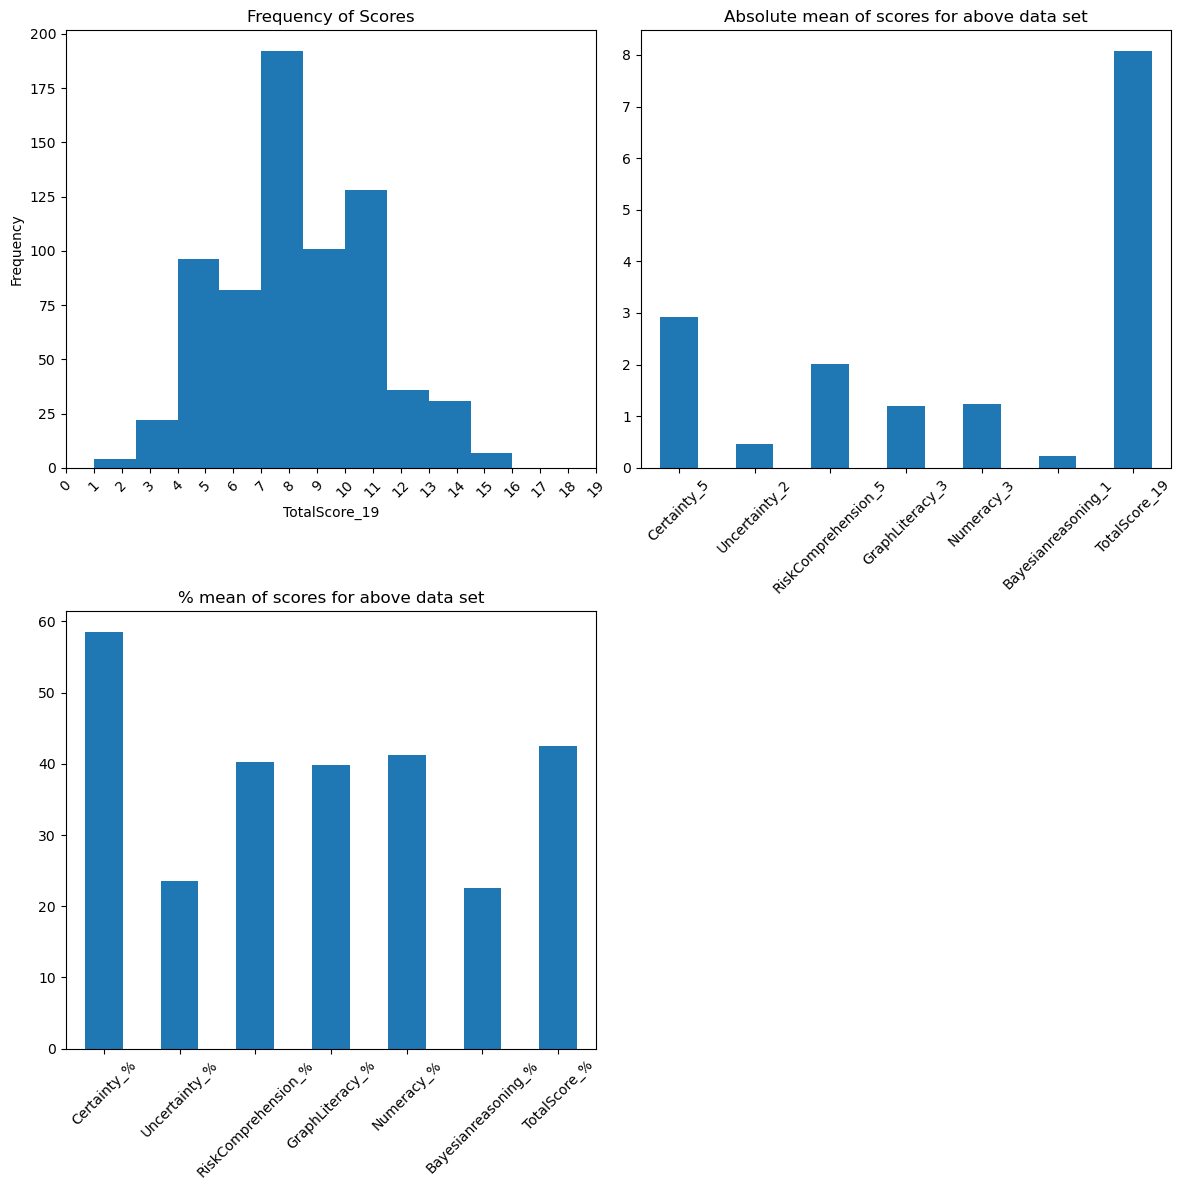

In [26]:
fig, axes = plt.subplots(2, 2, figsize = [12, 12])
fig.subplots_adjust(hspace=1)


# The following graph represents frequency of each data point on "TotalScore_19" or the total score out of 13 questions across the sample.
df2['TotalScore_19'].plot(kind = 'hist', xticks = np.arange(0, 20, step=1), xlabel = 'TotalScore_19', title = 'Frequency of Scores', ax = axes[0, 0] )
axes[0, 0].tick_params(axis = "x", rotation = 45)

# Absolute mean scores for each facet
(df2[['Certainty_5', 'Uncertainty_2', 'RiskComprehension_5','GraphLiteracy_3',
      'Numeracy_3','Bayesianreasoning_1','TotalScore_19']].mean(axis = 0)).plot(kind = 'bar', title = 'Absolute mean of scores for above data set', ax = axes[0, 1])
axes[0, 1].tick_params(axis = "x", rotation = 45)

# Normalised mean scores for each facet
df2[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','GraphLiteracy_%',
     'Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean(axis = 0).plot(kind = 'bar', title = '% mean of scores for above data set', ax = axes[1, 0])
axes[1, 0].tick_params(axis = "x", rotation = 45)

axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

# ISCED

In [27]:
# Data Frame 5 or df5 is an aggregate data on facet total scores and over all total score, along with  education data vs each response. 
# This data set is now sorted by education.

df5 = df2.sort_values(by = 'isced')
df5 = df5.reset_index(drop = True)

In [28]:
# Mean of each facet as a % for each category of isced

df5.groupby('isced')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%',
                      'Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%']].mean()

Certainty_%  Uncertainty_%  RiskComprehension_%  Numeracy_%  \
isced                                                                
1        63.730159      21.428571            40.396825   45.502646   
2        56.348548      24.066390            39.419087   43.568465   
3        54.660194      25.485437            41.262136   33.495146   

       GraphLiteracy_%  Bayesianreasoning_%  
isced                                        
1            44.841270            23.015873  
2            40.387275            22.406639  
3            33.171521            22.330097

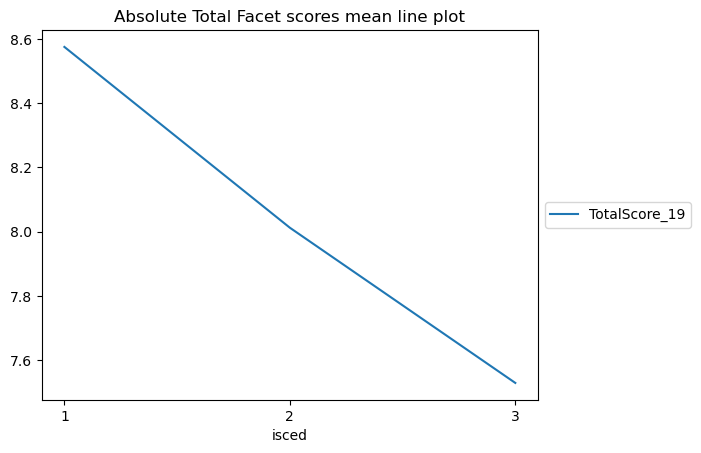

In [29]:
# Absolute Total Facet scores mean line plot from low to high ISCED

df5.groupby('isced')[['TotalScore_19']].mean().plot( kind = 'line', title = 'Absolute Total Facet scores mean line plot', xticks = np.arange(1,4, step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

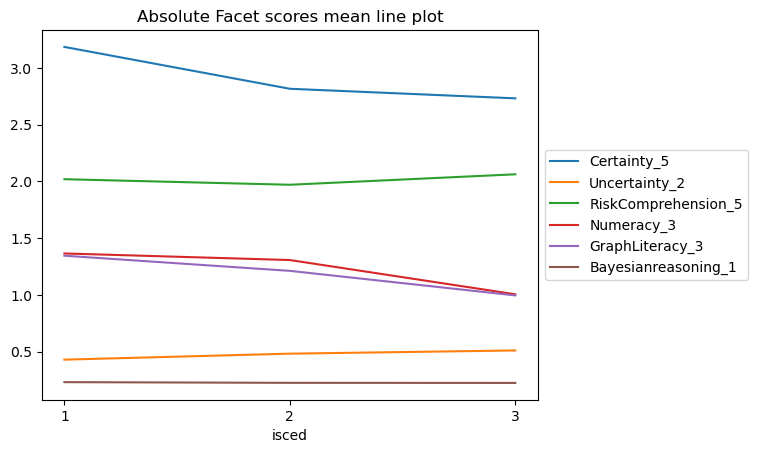

In [30]:
# Absolute Facet scores mean line plot from low to high edu

df5.groupby('isced')[['Certainty_5', "Uncertainty_2", 'RiskComprehension_5','Numeracy_3','GraphLiteracy_3','Bayesianreasoning_1']].mean().plot( kind = 'line', title = 'Absolute Facet scores mean line plot', xticks = np.arange(1,4, step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

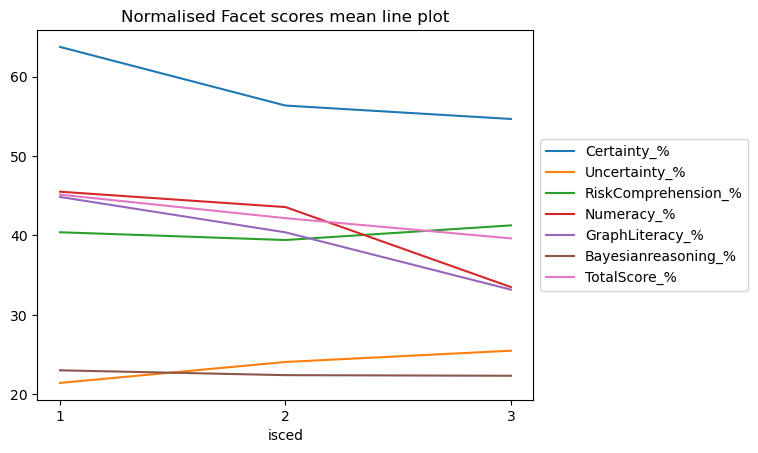

In [31]:
# Normalised Facet scores mean line plot from low to high edu


df5.groupby('isced')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().plot( kind = 'line', title = 'Normalised Facet scores mean line plot', xticks = np.arange(1,4, step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

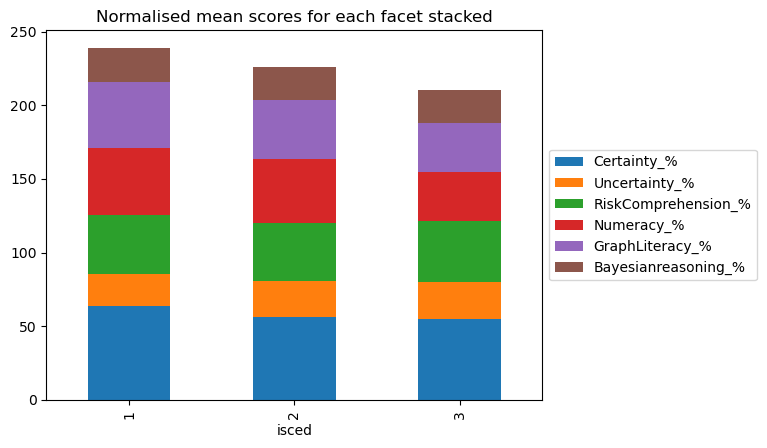

In [32]:
# Normalised mean scores for each facet stacked

df5.groupby('isced')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%']].mean().plot( kind = 'bar', title = 'Normalised mean scores for each facet stacked', stacked = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

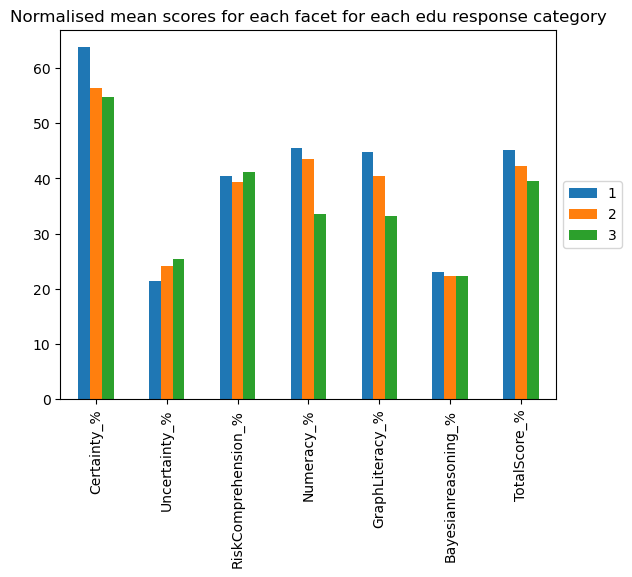

In [33]:
# Normalised mean scores for each facet for each edu response category

df5.groupby('isced')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().T.plot(kind = 'bar', title = 'Normalised mean scores for each facet for each edu response category').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: xlabel='isced', ylabel='TotalScore_19'>

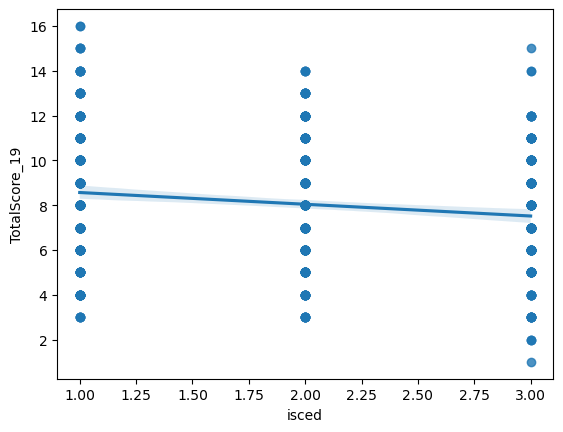

In [34]:
# Trend line for Absolute Total Facet Score vs edu (isced) reponses

sns.regplot (data = df5, x = 'isced', y = 'TotalScore_19')

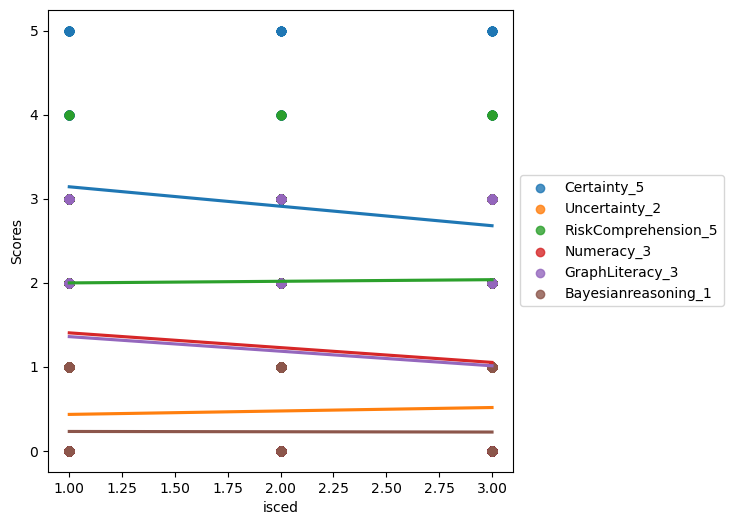

In [35]:
# Trend line for Absolute Independent Facet Score vs edu (isced) reponses

fig, ax6 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df5, x = 'isced', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax6, label='Certainty_5')
sns.regplot (data = df5, x = 'isced', y = 'Uncertainty_2', fit_reg=True, ci=None, ax=ax6, label='Uncertainty_2')
sns.regplot (data = df5, x = 'isced', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax6, label='RiskComprehension_5')
sns.regplot (data = df5, x = 'isced', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax6, label='Numeracy_3')
sns.regplot (data = df5, x = 'isced', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax6, label='GraphLiteracy_3')
sns.regplot (data = df5, x = 'isced', y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax6, label='Bayesianreasoning_1' )

ax6.set(ylabel='Scores', xlabel='isced')
ax6.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

<Axes: xlabel='isced', ylabel='TotalScore_19'>

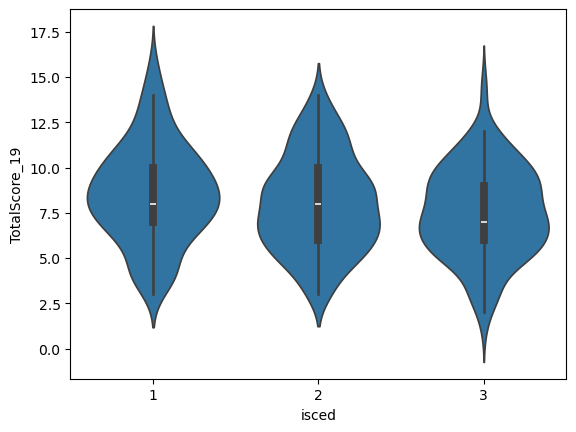

In [36]:
# Violine Plot for TotalScore_19 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'TotalScore_19')

<Axes: xlabel='isced', ylabel='Certainty_5'>

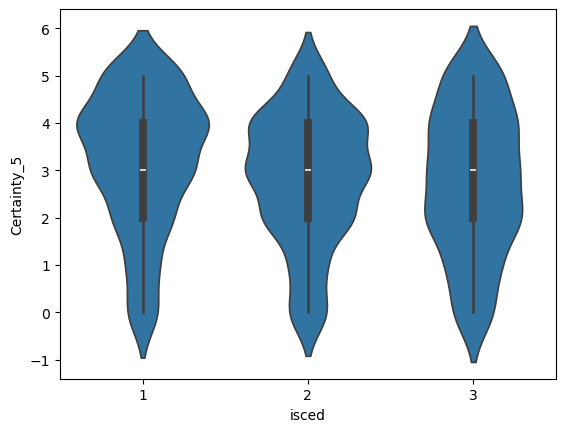

In [37]:
# Violine Plot for Certainty_5 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Certainty_5')

<Axes: xlabel='isced', ylabel='Uncertainty_2'>

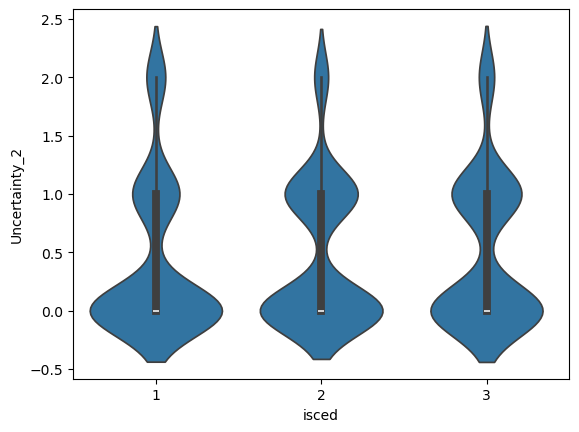

In [38]:
# Violine Plot for Uncertainty_5 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Uncertainty_2')

<Axes: xlabel='isced', ylabel='RiskComprehension_5'>

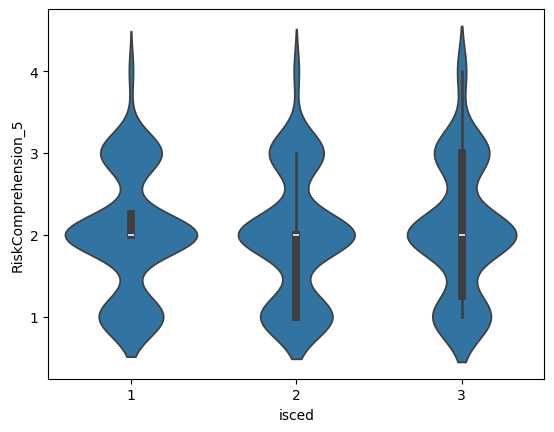

In [39]:
# Violine Plot for RiskComprehension_5 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'RiskComprehension_5')

<Axes: xlabel='isced', ylabel='GraphLiteracy_3'>

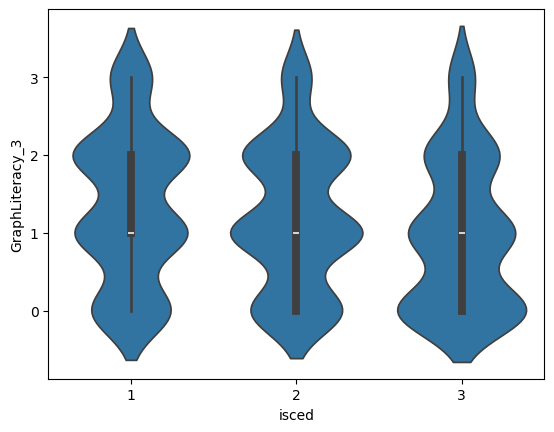

In [40]:
# Violine Plot for GraphLiteracy_3 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'GraphLiteracy_3')

<Axes: xlabel='isced', ylabel='Numeracy_3'>

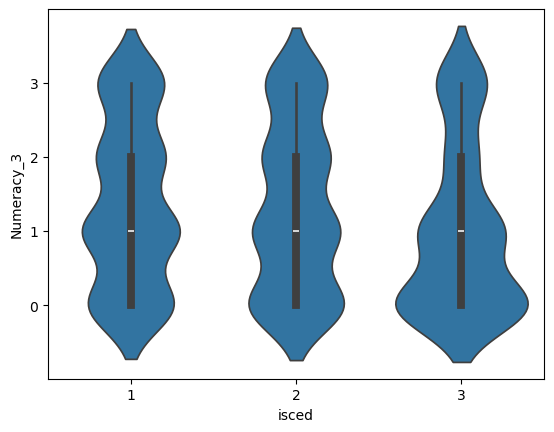

In [41]:
# Violine Plot for Numeracy_3 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Numeracy_3')

<Axes: xlabel='isced', ylabel='Bayesianreasoning_1'>

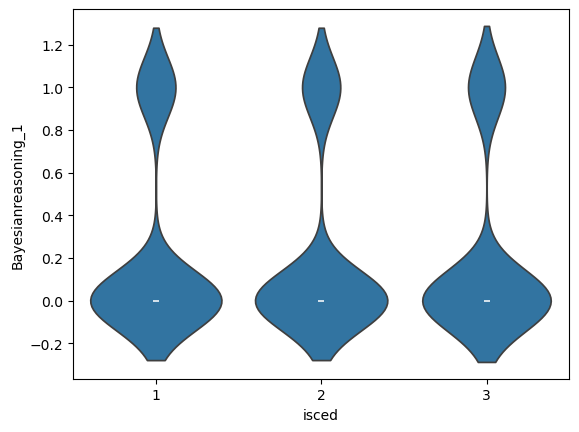

In [42]:
# Violine Plot for TotalScore_19 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Bayesianreasoning_1')

## INCOME

### INCOME VS SCORES

In [43]:
# DF3 = Sorted by income

df3 = df2.sort_values(by = 'income')
df3 = df3.reset_index(drop = True)
df3.drop(df3[df3['income'] == 7].index, inplace = True)

In [44]:
# Normalised mean of each facet as a numerical (sorted by income)

df3.groupby('income')[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean()

Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
income                                                                  
1         53.505155            40.618557        37.113402   35.395189   
2         58.914027            39.909502        44.494721   45.550528   
3         62.631579            40.877193        36.842105   43.859649   
4         61.315789            39.210526        42.543860   38.596491   
5         57.307692            40.769231        33.974359   35.256410   
6         64.761905            40.952381        38.888889   51.587302   

        Bayesianreasoning_%  TotalScore_%  
income                                     
1                 19.587629     40.043407  
2                 23.076923     44.034294  
3                 16.666667     42.890120  
4                 28.947368     43.074792  
5                 23.076923     40.283401  
6                 38.095238     46.240602

In [45]:
# Count of responses for each category (sorted by income)

df3.groupby('income')[['ResponseId']].count()

ResponseId
income            
1              194
2              221
3              114
4               76
5               52
6               42

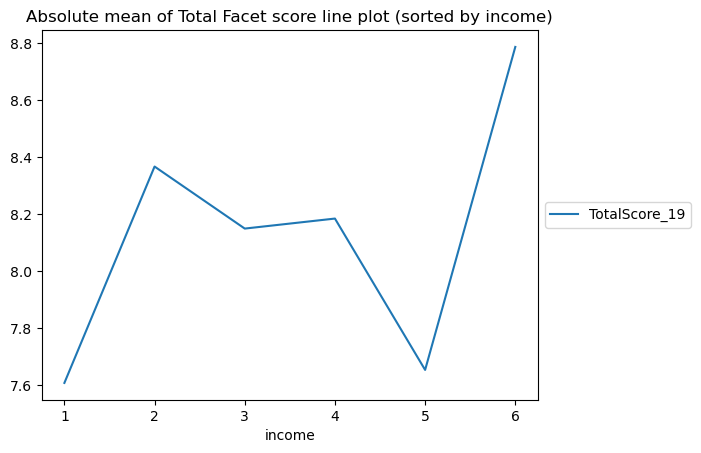

In [46]:
# Absolute mean of Total Facet score line plot (sorted by income)

df3.groupby('income')[['TotalScore_19']].mean().plot( kind = 'line', title = 'Absolute mean of Total Facet score line plot (sorted by income)').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

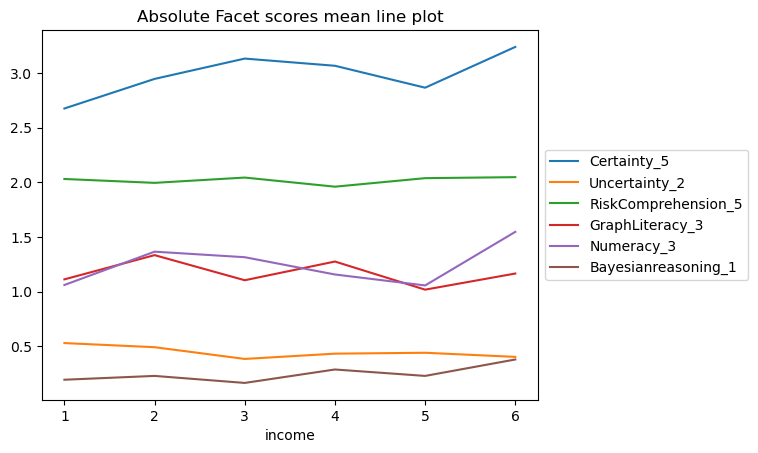

In [47]:
# Absolute mean of each Facet score line plot (sorted by income)

df3.groupby('income')[['Certainty_5', "Uncertainty_2", 'RiskComprehension_5','GraphLiteracy_3','Numeracy_3','Bayesianreasoning_1']].mean().plot( kind = 'line', title = 'Absolute Facet scores mean line plot').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

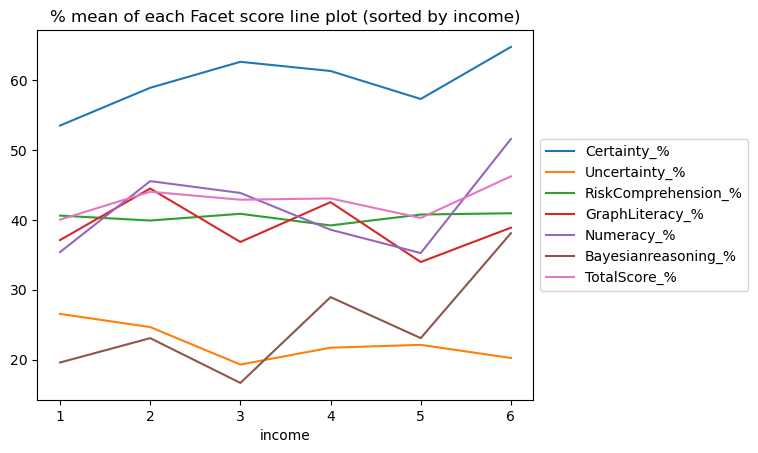

In [48]:
# Normalised mean of each Facet score line plot (sorted by income)


df3.groupby('income')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%', 'TotalScore_%']].mean().plot( kind = 'line', title = '% mean of each Facet score line plot (sorted by income)').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

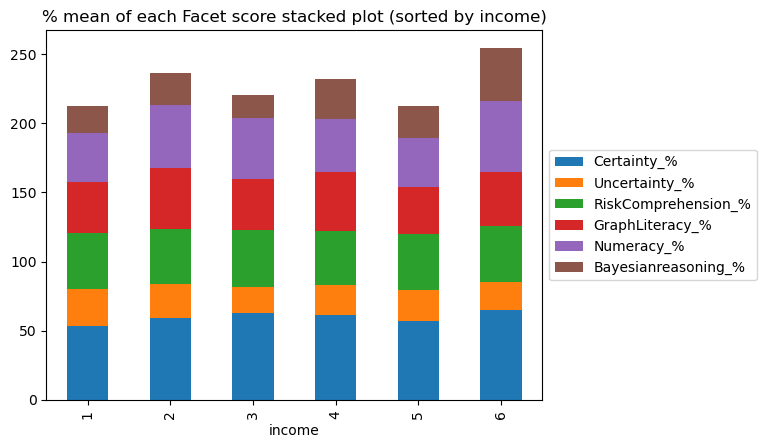

In [49]:
# Normalised mean of each Facet score stacked plot (sorted by income)

df3.groupby('income')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%']].mean().plot( kind = 'bar', title = '% mean of each Facet score stacked plot (sorted by income)', stacked = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

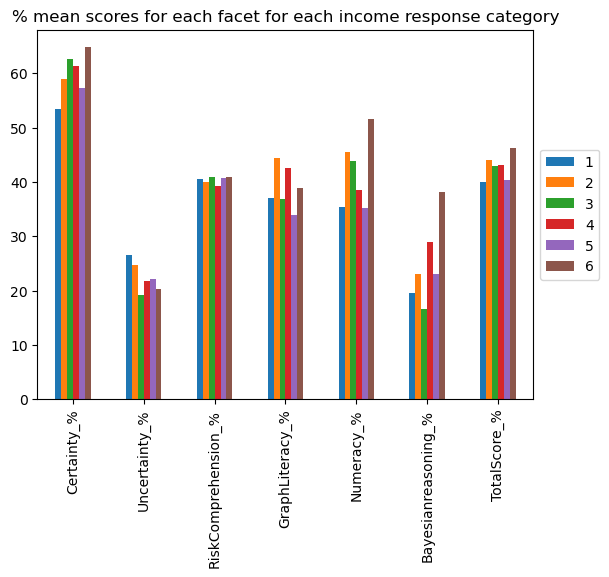

In [50]:
# Normalised mean of each Facet score hist plot (sorted by income)

df3.groupby('income')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean().T.plot(kind = 'bar', title = '% mean scores for each facet for each income response category').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: xlabel='income', ylabel='TotalScore_19'>

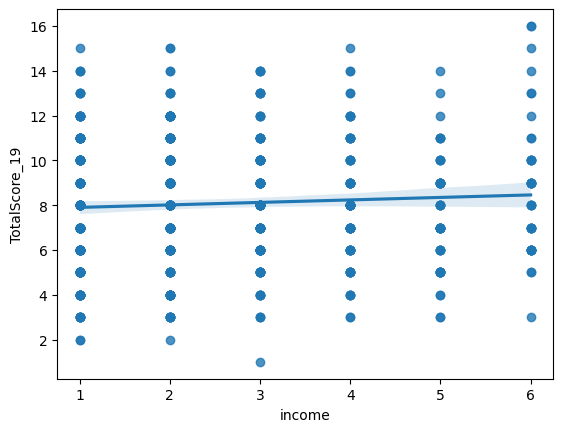

In [51]:
# Trend line for Absolute Total Facet Score vs income

sns.regplot (data = df3, x = 'income', y = 'TotalScore_19')

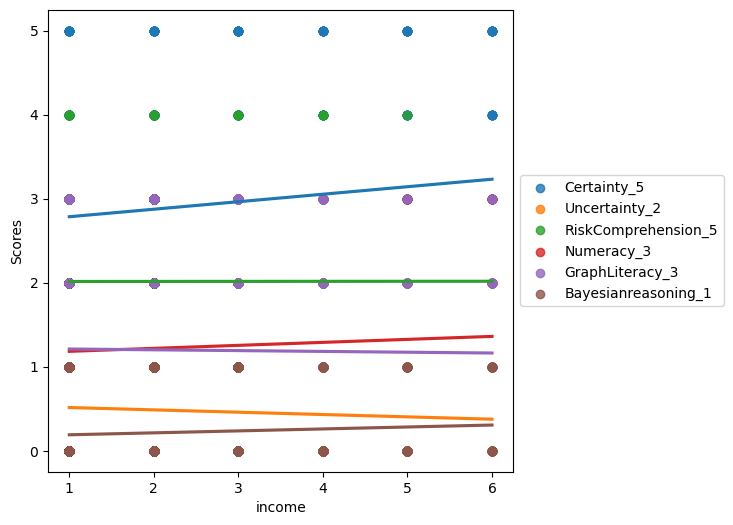

In [52]:
# Trend line for Absolute Independent Facet Score vs income reponses

fig, ax = plt.subplots(figsize=(6, 6))

sns.regplot (data = df3, x = 'income', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax, label='Certainty_5')
sns.regplot (data = df3, x = 'income', y = 'Uncertainty_2', fit_reg=True, ci=None, ax=ax, label='Uncertainty_2')
sns.regplot (data = df3, x = 'income', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax, label='RiskComprehension_5')
sns.regplot (data = df3, x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax, label='Numeracy_3')
sns.regplot (data = df3, x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax, label='GraphLiteracy_3')
sns.regplot (data = df3, x = 'income', y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax, label='Bayesianreasoning_1' )

ax.set(ylabel='Scores', xlabel='income')
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

<Axes: xlabel='income', ylabel='TotalScore_19'>

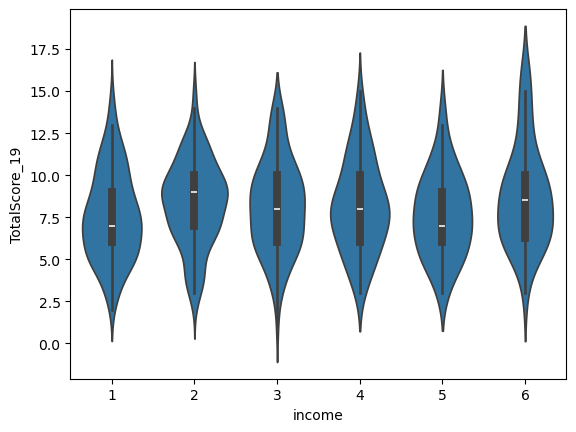

In [53]:
# Violin Plot for TotalScore_19 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'TotalScore_19')

<Axes: xlabel='income', ylabel='Certainty_5'>

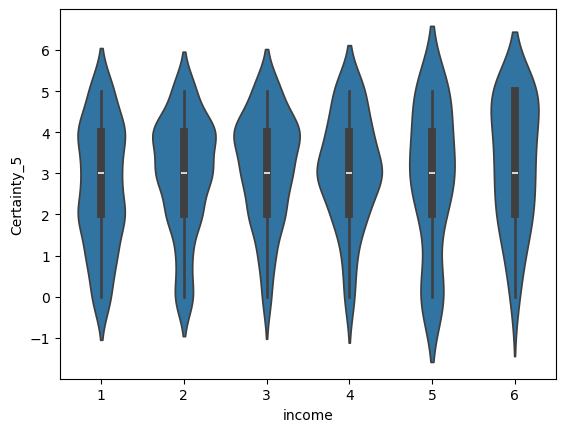

In [54]:
# Violin Plot for Certainty_5 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Certainty_5')

<Axes: xlabel='income', ylabel='Uncertainty_2'>

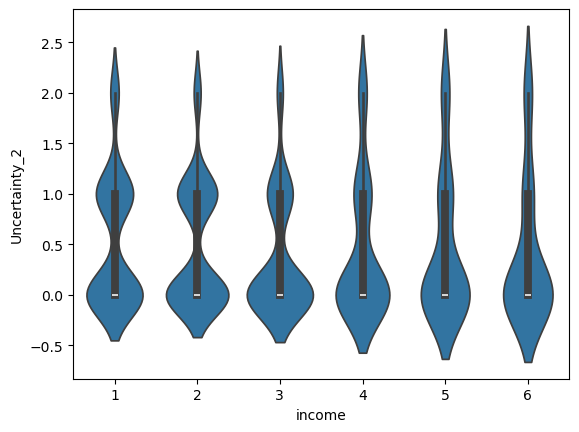

In [55]:
# Violin Plot for Certainty_5 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Uncertainty_2')

<Axes: xlabel='income', ylabel='RiskComprehension_5'>

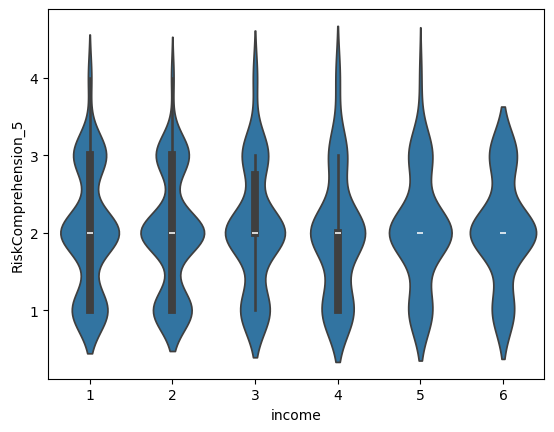

In [56]:
# Violine Plot for RiskComprehension_5 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'RiskComprehension_5')

<Axes: xlabel='income', ylabel='GraphLiteracy_3'>

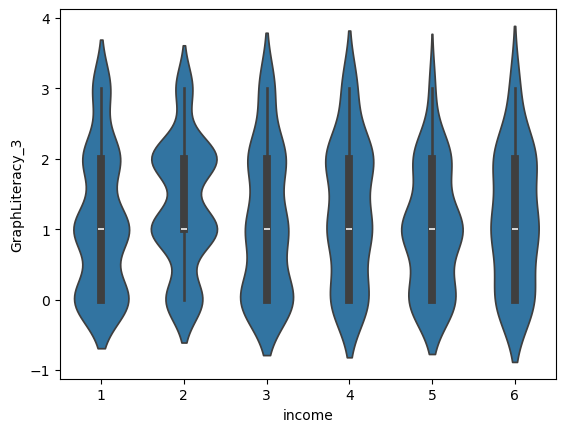

In [57]:
# Violine Plot for GraphLiteracy_3 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'GraphLiteracy_3')

<Axes: xlabel='income', ylabel='Numeracy_3'>

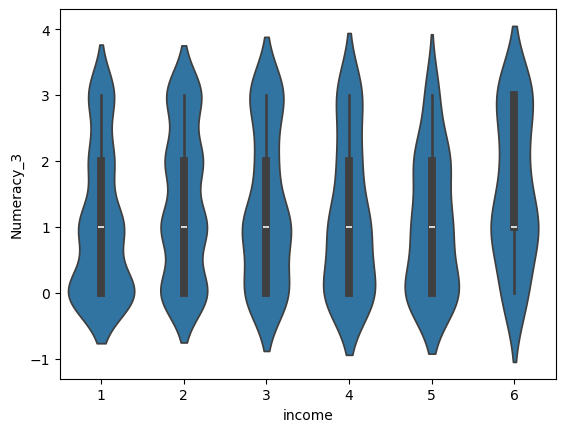

In [58]:
# Violine Plot for Numeracy_3 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Numeracy_3')

<Axes: xlabel='income', ylabel='Bayesianreasoning_1'>

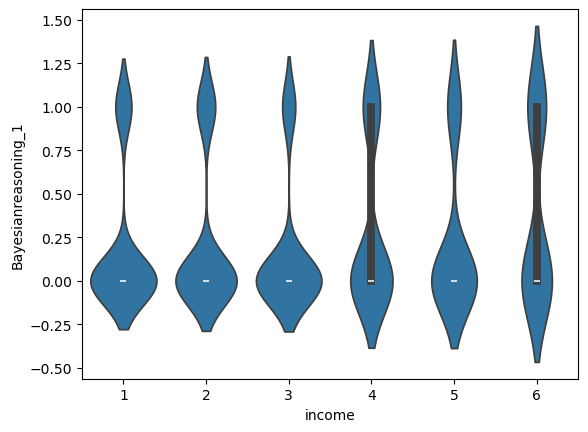

In [59]:
# Violine Plot for TotalScore_19 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Bayesianreasoning_1')

### INCOME vs SCORES w/ ISCED classification

In [60]:
# Descriptive stats for the data set, isced = 1
# NA values of income are removed

df7 = df5
df7.drop(df7[df7['income'] == 7].index, inplace = True)

df7.loc[df7['isced']==1].describe()

ResponseId         age     age_rec  isced      income        wealth  \
count  252.000000  252.000000  252.000000  252.0  252.000000  2.520000e+02   
mean   370.682540   35.757937    2.460317    1.0    3.234127  4.887746e+06   
std    272.942711    8.983880    0.587395    0.0    1.432667  5.578940e+06   
min      0.000000   19.000000    2.000000    1.0    1.000000  5.000000e+03   
25%    102.750000   30.000000    2.000000    1.0    2.000000  3.875000e+05   
50%    572.500000   34.500000    2.000000    1.0    3.000000  2.500000e+06   
75%    635.250000   40.000000    3.000000    1.0    4.000000  9.125000e+06   
max    698.000000   66.000000    4.000000    1.0    6.000000  1.500000e+07   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   252.000000     252.000000           252.000000       252.000000   
mean      3.186508       0.428571             2.019841         1.345238   
std       1.445193       0.661142             0.738527         0.959258   
min       0.000000       0.000000             1.000000         0.000000   
25%       2.000000       0.000000             2.000000         1.000000   
50%       3.000000       0.000000             2.000000         1.000000   
75%       4.000000       1.000000             2.250000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_3  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  252.000000           252.000000   252.000000     252.000000   
mean     1.365079             0.230159    63.730159      21.428571   
std      1.094012             0.421772    28.903856      33.057099   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    40.000000       0.000000   
50%      1.000000             0.000000    60.000000       0.000000   
75%      2.000000             0.000000    80.000000      50.000000   
max      3.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           252.000000       252.000000  252.000000           252.000000   
mean             40.396825        44.841270   45.502646            23.015873   
std              14.770531        31.975276   36.467083            42.177199   
min              20.000000         0.000000    0.000000             0.000000   
25%              40.000000        33.333333    0.000000             0.000000   
50%              40.000000        33.333333   33.333333             0.000000   
75%              45.000000        66.666667   66.666667             0.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_19  TotalScore_%  
count     252.000000    252.000000  
mean        8.575397     45.133668  
std         2.748101     14.463692  
min         3.000000     15.789474  
25%         7.000000     36.842105  
50%         8.000000     42.105263  
75%        10.000000     52.631579  
max        16.000000     84.210526

In [61]:
df7.loc[df7['isced']==2].describe()

ResponseId        age     age_rec  isced      income        wealth  \
count  241.000000  241.00000  241.000000  241.0  241.000000  2.410000e+02   
mean   327.900415   33.40249    2.373444    2.0    2.224066  2.336963e+06   
std    174.356168   11.55926    0.599965    0.0    1.227973  3.987210e+06   
min      2.000000   18.00000    2.000000    2.0    1.000000  5.000000e+03   
25%    182.000000   25.00000    2.000000    2.0    1.000000  1.000000e+05   
50%    398.000000   30.00000    2.000000    2.0    2.000000  5.000000e+05   
75%    490.000000   39.00000    3.000000    2.0    3.000000  2.500000e+06   
max    556.000000   72.00000    4.000000    2.0    6.000000  1.500000e+07   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   241.000000     241.000000           241.000000       241.000000   
mean      2.817427       0.481328             1.970954         1.211618   
std       1.375328       0.619697             0.771353         0.917895   
min       0.000000       0.000000             1.000000         0.000000   
25%       2.000000       0.000000             1.000000         0.000000   
50%       3.000000       0.000000             2.000000         1.000000   
75%       4.000000       1.000000             2.000000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_3  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  241.000000           241.000000   241.000000     241.000000   
mean     1.307054             0.224066    56.348548      24.066390   
std      1.109200             0.417834    27.506569      30.984871   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    40.000000       0.000000   
50%      1.000000             0.000000    60.000000       0.000000   
75%      2.000000             0.000000    80.000000      50.000000   
max      3.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           241.000000       241.000000  241.000000           241.000000   
mean             39.419087        40.387275   43.568465            22.406639   
std              15.427069        30.596498   36.973339            41.783377   
min              20.000000         0.000000    0.000000             0.000000   
25%              20.000000         0.000000    0.000000             0.000000   
50%              40.000000        33.333333   33.333333             0.000000   
75%              40.000000        66.666667   66.666667             0.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_19  TotalScore_%  
count     241.000000    241.000000  
mean        8.012448     42.170780  
std         2.638625     13.887503  
min         3.000000     15.789474  
25%         6.000000     31.578947  
50%         8.000000     42.105263  
75%        10.000000     52.631579  
max        14.000000     73.684211

In [62]:
df7.loc[df7['isced']==3].describe()

ResponseId         age     age_rec  isced      income        wealth  \
count  206.000000  206.000000  206.000000  206.0  206.000000  2.060000e+02   
mean   347.160194   36.601942    2.548544    3.0    2.150485  1.905820e+06   
std    104.520781   13.248352    0.651507    0.0    1.521128  3.835872e+06   
min     27.000000   18.000000    2.000000    3.0    1.000000  5.000000e+03   
25%    285.250000   27.000000    2.000000    3.0    1.000000  2.125000e+04   
50%    345.500000   35.000000    2.000000    3.0    2.000000  2.000000e+05   
75%    404.500000   45.000000    3.000000    3.0    2.750000  1.500000e+06   
max    570.000000   75.000000    4.000000    3.0    6.000000  1.500000e+07   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   206.000000     206.000000           206.000000       206.000000   
mean      2.733010       0.509709             2.063107         0.995146   
std       1.521096       0.638140             0.802981         0.960171   
min       0.000000       0.000000             1.000000         0.000000   
25%       2.000000       0.000000             1.250000         0.000000   
50%       3.000000       0.000000             2.000000         1.000000   
75%       4.000000       1.000000             3.000000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_3  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  206.000000           206.000000   206.000000     206.000000   
mean     1.004854             0.223301    54.660194      25.485437   
std      1.110911             0.417473    30.421928      31.906988   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    40.000000       0.000000   
50%      1.000000             0.000000    60.000000       0.000000   
75%      2.000000             0.000000    80.000000      50.000000   
max      3.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           206.000000       206.000000  206.000000           206.000000   
mean             41.262136        33.171521   33.495146            22.330097   
std              16.059621        32.005686   37.030358            41.747297   
min              20.000000         0.000000    0.000000             0.000000   
25%              25.000000         0.000000    0.000000             0.000000   
50%              40.000000        33.333333   33.333333             0.000000   
75%              60.000000        66.666667   66.666667             0.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_19  TotalScore_%  
count     206.000000    206.000000  
mean        7.529126     39.626980  
std         2.517573     13.250382  
min         1.000000      5.263158  
25%         6.000000     31.578947  
50%         7.000000     36.842105  
75%         9.000000     47.368421  
max        15.000000     78.947368

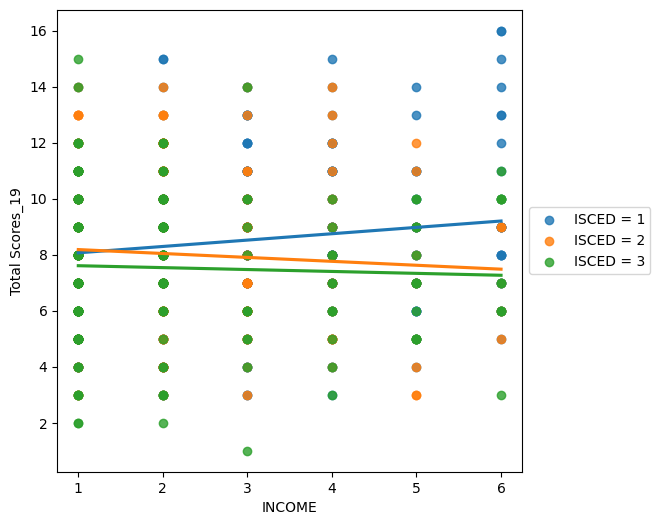

In [63]:
# Trend line for Absolute Tota Facet Score vs income reponses sorted by isced and ORDERED by income WITH scatter

fig, ax7 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = df7.loc[df7['isced']==1]['TotalScore_19'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 1')
sns.regplot (data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = df7.loc[df7['isced']==2]['TotalScore_19'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 2')
sns.regplot (data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = df7.loc[df7['isced']==3]['TotalScore_19'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 3')

ax7.set(ylabel='Total Scores_19', xlabel='INCOME')
ax7.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

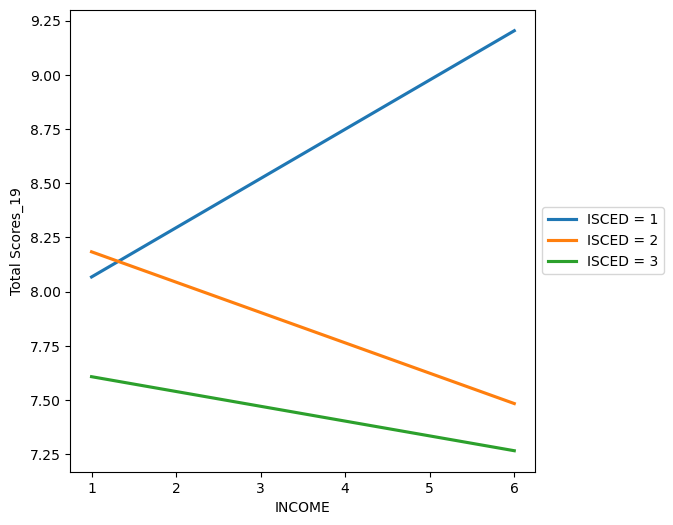

In [64]:
# Trend line for Absolute Tota Facet Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax8 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'TotalScore_19', fit_reg=True, ci=None, ax=ax8, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'TotalScore_19', fit_reg=True, ci=None, ax=ax8, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'TotalScore_19', fit_reg=True, ci=None, ax=ax8, label='ISCED = 3')

ax8.set(ylabel='Total Scores_19', xlabel='INCOME')
ax8.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

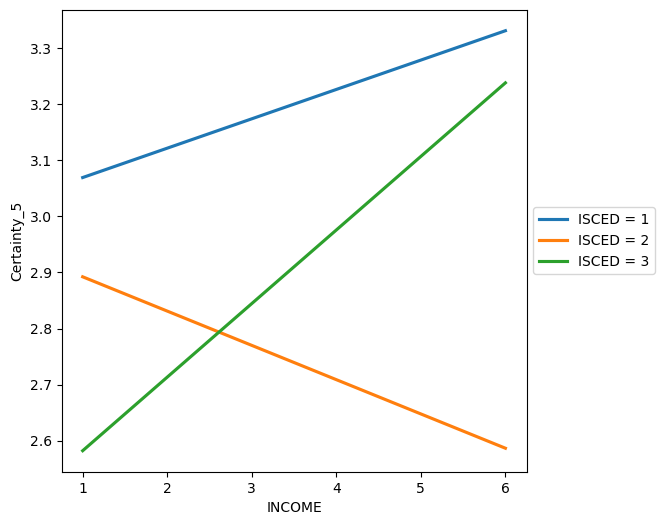

In [65]:
# Trend line for Absolute Certainty Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax9 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 3')

ax9.set(ylabel='Certainty_5', xlabel='INCOME')
ax9.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

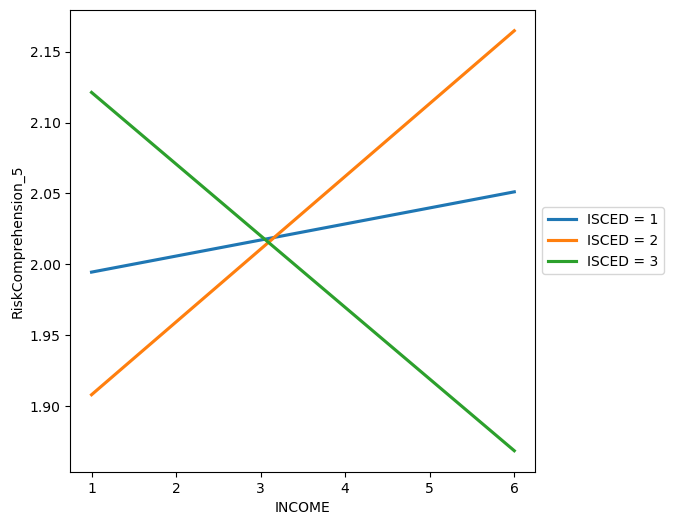

In [66]:
# Trend line for Absolute Risk Comprehension Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax10 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 3')

ax10.set(ylabel='RiskComprehension_5', xlabel='INCOME')
ax10.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

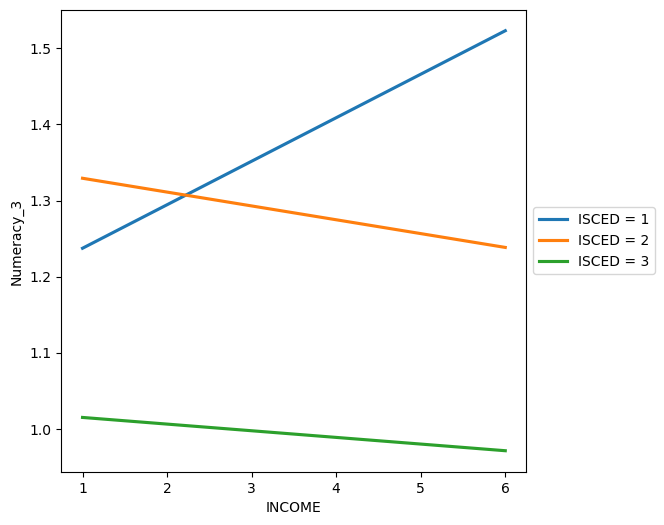

In [67]:
# Trend line for Absolute Number Comprehension Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='Numeracy_3', xlabel='INCOME')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

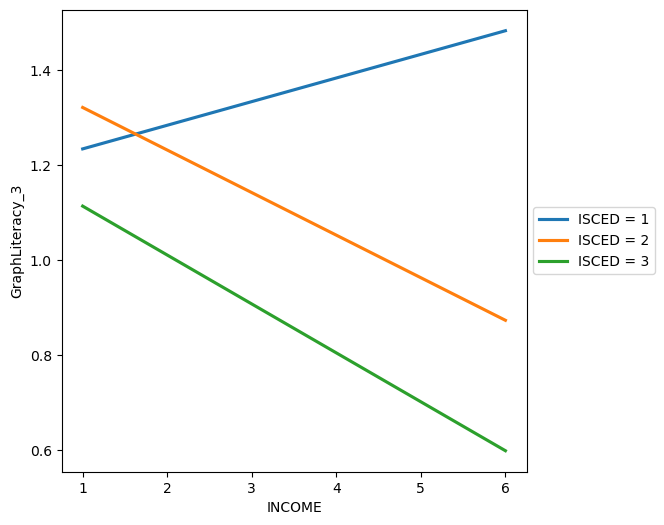

In [68]:
# Trend line for Absolute Graph Comprehension Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='GraphLiteracy_3', xlabel='INCOME')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

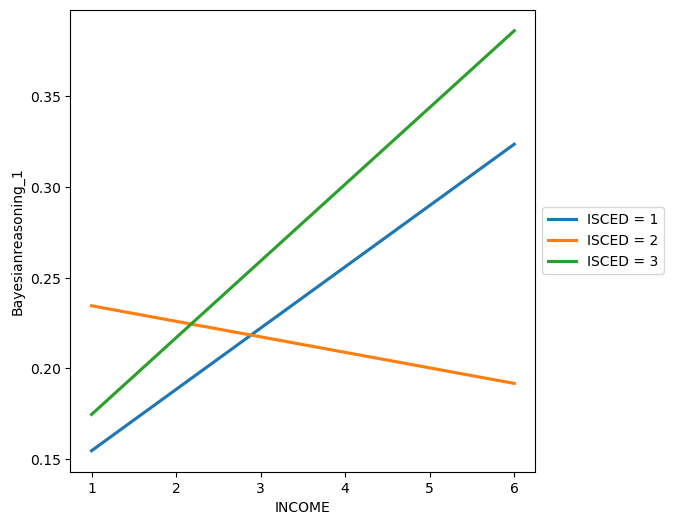

In [69]:
# Trend line for Absolute Bayesian Reasoning Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax12 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 3')

ax12.set(ylabel='Bayesianreasoning_1', xlabel='INCOME')
ax12.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

### INCOME vs SCORES w/ ISCED and AGE based classification 

In [70]:
df7

ResponseId   age  age_rec  isced  income      wealth  Certainty_5  \
0             0  30.0        2      1       2   5000000.0            2   
1           599  35.0        2      1       3   2000000.0            5   
2           598  27.0        2      1       5  15000000.0            2   
3           597  45.0        3      1       3   5000000.0            2   
4           596  40.0        3      1       6    500000.0            3   
..          ...   ...      ...    ...     ...         ...          ...   
694         365  26.0        2      3       1   4000000.0            3   
695         364  28.0        2      3       3    100000.0            2   
696         363  20.0        2      3       2    140000.0            5   
697         361  75.0        4      3       1   2000000.0            2   
698         349  37.0        3      3       2  15000000.0            0   

     Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
0                0                    1                2           1   
1                0                    2                2           3   
2                0                    2                1           3   
3                0                    2                1           2   
4                0                    3                1           0   
..             ...                  ...              ...         ...   
694              0                    2                0           0   
695              0                    2                2           2   
696              0                    2                0           0   
697              0                    2                2           0   
698              0                    1                1           0   

     Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
0                      1         40.0            0.0                 20.0   
1                      1        100.0            0.0                 40.0   
2                      1         40.0            0.0                 40.0   
3                      0         40.0            0.0                 40.0   
4                      0         60.0            0.0                 60.0   
..                   ...          ...            ...                  ...   
694                    0         60.0            0.0                 40.0   
695                    0         40.0            0.0                 40.0   
696                    0        100.0            0.0                 40.0   
697                    0         40.0            0.0                 40.0   
698                    0          0.0            0.0                 20.0   

     GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_19  \
0          66.666667   33.333333                100.0              7   
1          66.666667  100.000000                100.0             13   
2          33.333333  100.000000                100.0              9   
3          33.333333   66.666667                  0.0              7   
4          33.333333    0.000000                  0.0              7   
..               ...         ...                  ...            ...   
694         0.000000    0.000000                  0.0              5   
695        66.666667   66.666667                  0.0              8   
696         0.000000    0.000000                  0.0              7   
697        66.666667    0.000000                  0.0              6   
698        33.333333    0.000000                  0.0              2   

     TotalScore_%  
0       36.842105  
1       68.421053  
2       47.368421  
3       36.842105  
4       36.842105  
..            ...  
694     26.315789  
695     42.105263  
696     36.842105  
697     31.578947  
698     10.526316  

[699 rows x 20 columns]

In [71]:
# Since we already have a classification for Age groups in the form of age_rec, we will use that.
# We will also use median of age to see if it yields any relevant results, as instructed.

# AXES to be used = Age or age groups, ISCED, Income

# Age groups = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 59 y/o
# Age group 4 = 60 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)



In [72]:
df7.loc[(df7['age_rec']==2)].describe()

ResponseId         age  age_rec       isced      income        wealth  \
count  425.000000  425.000000    425.0  425.000000  425.000000  4.250000e+02   
mean   355.920000   27.917647      2.0    1.912941    2.527059  2.710800e+06   
std    197.921459    4.729005      0.0    0.776693    1.455260  4.405788e+06   
min      0.000000   18.000000      2.0    1.000000    1.000000  5.000000e+03   
25%    204.000000   24.000000      2.0    1.000000    1.000000  1.000000e+05   
50%    364.000000   28.000000      2.0    2.000000    2.000000  5.000000e+05   
75%    518.000000   32.000000      2.0    3.000000    3.000000  3.000000e+06   
max    698.000000   35.000000      2.0    3.000000    6.000000  1.500000e+07   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   425.000000     425.000000           425.000000       425.000000   
mean      2.908235       0.454118             1.981176         1.164706   
std       1.412062       0.613056             0.764559         0.957186   
min       0.000000       0.000000             1.000000         0.000000   
25%       2.000000       0.000000             1.000000         0.000000   
50%       3.000000       0.000000             2.000000         1.000000   
75%       4.000000       1.000000             2.000000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_3  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  425.000000           425.000000   425.000000     425.000000   
mean     1.225882             0.249412    58.164706      22.705882   
std      1.122576             0.433182    28.241231      30.652812   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    40.000000       0.000000   
50%      1.000000             0.000000    60.000000       0.000000   
75%      2.000000             0.000000    80.000000      50.000000   
max      3.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           425.000000       425.000000  425.000000           425.000000   
mean             39.623529        38.823529   40.862745            24.941176   
std              15.291180        31.906186   37.419210            43.318248   
min              20.000000         0.000000    0.000000             0.000000   
25%              20.000000         0.000000    0.000000             0.000000   
50%              40.000000        33.333333   33.333333             0.000000   
75%              40.000000        66.666667   66.666667             0.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_19  TotalScore_%  
count     425.000000    425.000000  
mean        7.983529     42.018576  
std         2.610250     13.738160  
min         2.000000     10.526316  
25%         6.000000     31.578947  
50%         8.000000     42.105263  
75%        10.000000     52.631579  
max        16.000000     84.210526

In [73]:
df7.loc[(df7['age_rec']==3)].describe()

ResponseId         age  age_rec       isced      income        wealth  \
count  229.000000  229.000000    229.0  229.000000  229.000000  2.290000e+02   
mean   340.087336   43.104803      3.0    1.934498    2.759825  3.848231e+06   
std    208.893474    5.013790      0.0    0.858440    1.518584  5.291885e+06   
min      1.000000   36.000000      3.0    1.000000    1.000000  5.000000e+03   
25%    155.000000   39.000000      3.0    1.000000    2.000000  1.000000e+05   
50%    336.000000   42.000000      3.0    2.000000    2.000000  1.000000e+06   
75%    546.000000   46.000000      3.0    3.000000    4.000000  5.000000e+06   
max    696.000000   55.000000      3.0    3.000000    6.000000  1.500000e+07   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   229.000000     229.000000           229.000000       229.000000   
mean      3.056769       0.427948             2.052402         1.183406   
std       1.475326       0.635434             0.776212         0.960393   
min       0.000000       0.000000             1.000000         0.000000   
25%       2.000000       0.000000             2.000000         0.000000   
50%       3.000000       0.000000             2.000000         1.000000   
75%       4.000000       1.000000             3.000000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_3  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  229.000000           229.000000   229.000000     229.000000   
mean     1.222707             0.192140    61.135371      21.397380   
std      1.107474             0.394845    29.506526      31.771721   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    40.000000       0.000000   
50%      1.000000             0.000000    60.000000       0.000000   
75%      2.000000             0.000000    80.000000      50.000000   
max      3.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           229.000000       229.000000  229.000000           229.000000   
mean             41.048035        39.446870   40.756914            19.213974   
std              15.524241        32.013105   36.915815            39.484536   
min              20.000000         0.000000    0.000000             0.000000   
25%              40.000000         0.000000    0.000000             0.000000   
50%              40.000000        33.333333   33.333333             0.000000   
75%              60.000000        66.666667   66.666667             0.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_19  TotalScore_%  
count     229.000000    229.000000  
mean        8.135371     42.817743  
std         2.731239     14.374940  
min         1.000000      5.263158  
25%         6.000000     31.578947  
50%         8.000000     42.105263  
75%        10.000000     52.631579  
max        16.000000     84.210526

In [74]:
df7.loc[(df7['age_rec']==4)].describe()

ResponseId        age  age_rec      isced     income        wealth  \
count   45.000000  45.000000     45.0  45.000000  45.000000  4.500000e+01   
mean   329.000000  63.666667      4.0   2.133333   1.955556  3.426311e+06   
std    204.826867   4.866397      0.0   0.814639   1.330679  4.933746e+06   
min      5.000000  57.000000      4.0   1.000000   1.000000  5.000000e+03   
25%    156.000000  60.000000      4.0   1.000000   1.000000  2.500000e+05   
50%    310.000000  63.000000      4.0   2.000000   1.000000  1.000000e+06   
75%    529.000000  67.000000      4.0   3.000000   2.000000  4.500000e+06   
max    678.000000  75.000000      4.0   3.000000   6.000000  1.500000e+07   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count    45.000000      45.000000            45.000000        45.000000   
mean      2.422222       0.844444             2.155556         1.555556   
std       1.671810       0.796457             0.767391         0.840875   
min       0.000000       0.000000             1.000000         0.000000   
25%       1.000000       0.000000             2.000000         1.000000   
50%       3.000000       1.000000             2.000000         2.000000   
75%       4.000000       1.000000             3.000000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_3  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count   45.000000            45.000000    45.000000      45.000000   
mean     1.444444             0.177778    48.444444      42.222222   
std      1.056486             0.386646    33.436205      39.822840   
min      0.000000             0.000000     0.000000       0.000000   
25%      1.000000             0.000000    20.000000       0.000000   
50%      1.000000             0.000000    60.000000      50.000000   
75%      2.000000             0.000000    80.000000      50.000000   
max      3.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count            45.000000        45.000000   45.000000            45.000000   
mean             43.111111        51.851852   48.148148            17.777778   
std              15.347819        28.029166   35.216183            38.664577   
min              20.000000         0.000000    0.000000             0.000000   
25%              40.000000        33.333333   33.333333             0.000000   
50%              40.000000        66.666667   33.333333             0.000000   
75%              60.000000        66.666667   66.666667             0.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_19  TotalScore_%  
count      45.000000     45.000000  
mean        8.600000     45.263158  
std         2.957271     15.564587  
min         3.000000     15.789474  
25%         6.000000     31.578947  
50%         9.000000     47.368421  
75%        11.000000     57.894737  
max        14.000000     73.684211

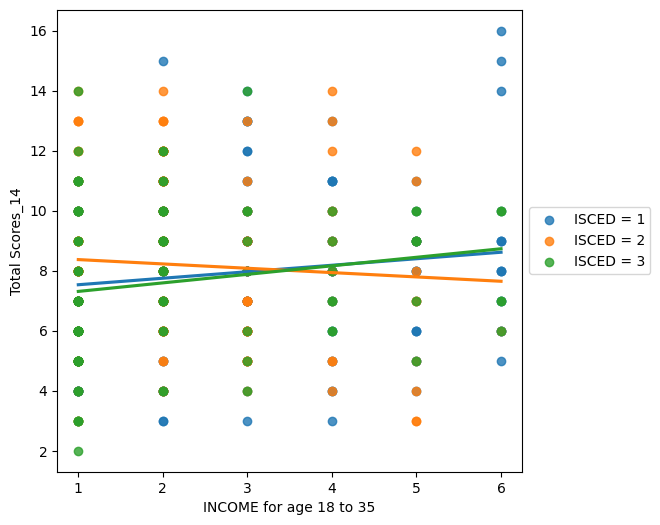

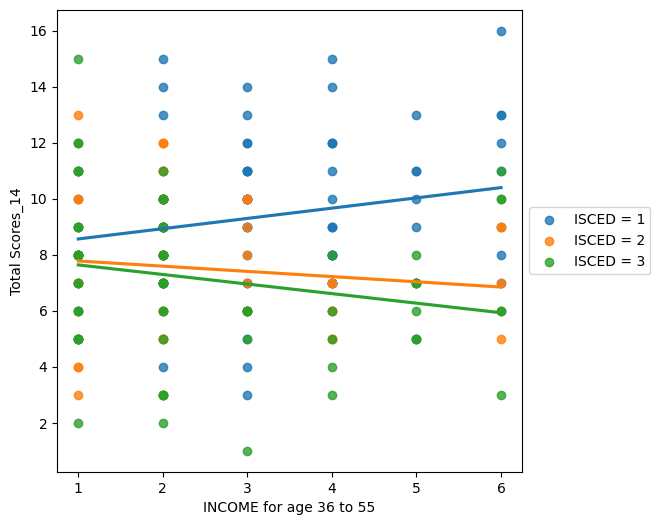

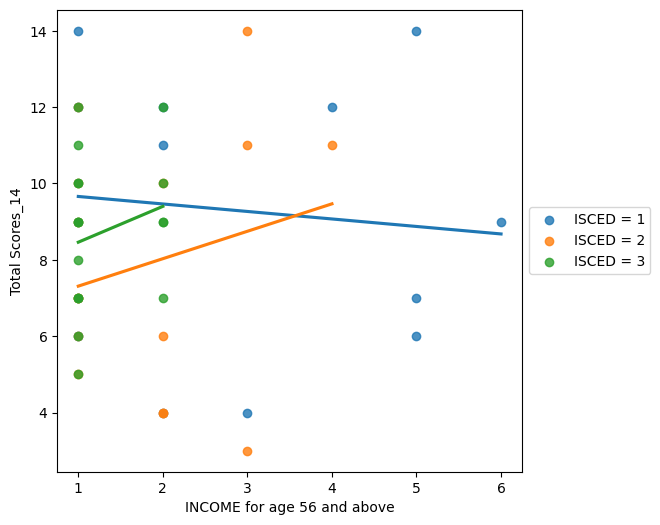

In [75]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Total Scores_14', xlabel='INCOME for age 18 to 35')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_14', xlabel='INCOME for age 36 to 55')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Total Scores_14', xlabel='INCOME for age 56 and above')
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

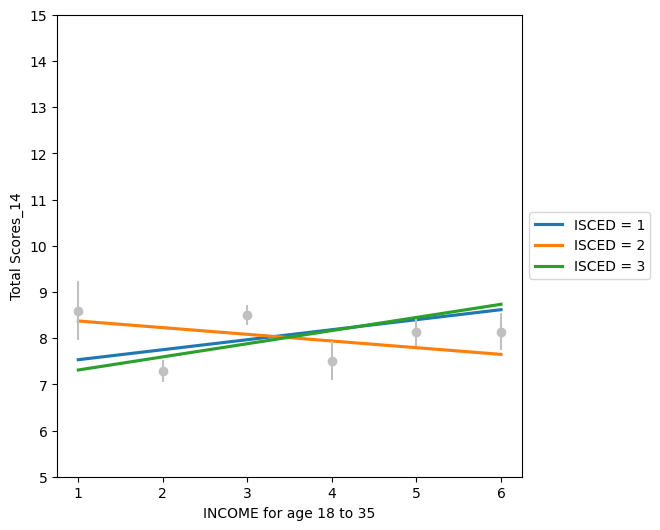

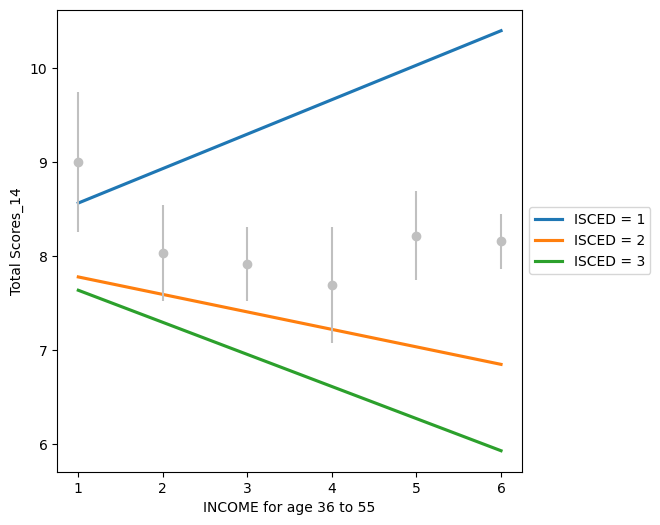

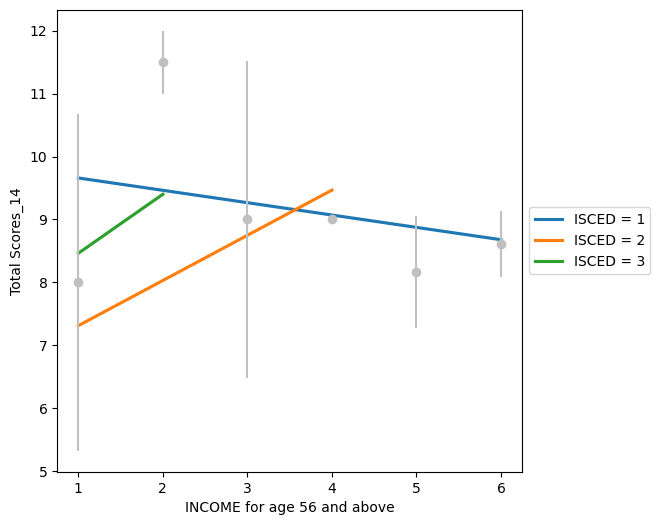

In [76]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income']).mean(numeric_only=True)['TotalScore_19'], yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['TotalScore_19'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Total Scores_14', xlabel='INCOME for age 18 to 35',  yticks = np.arange(5, 16 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_14', xlabel='INCOME for age 36 to 55',  yticks = np.arange(5, 16 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income']).mean(numeric_only=True)['TotalScore_19'], yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['TotalScore_19'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Total Scores_14', xlabel='INCOME for age 56 and above',  yticks = np.arange(5, 16 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income']).mean(numeric_only=True)['TotalScore_19'], yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['TotalScore_19'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

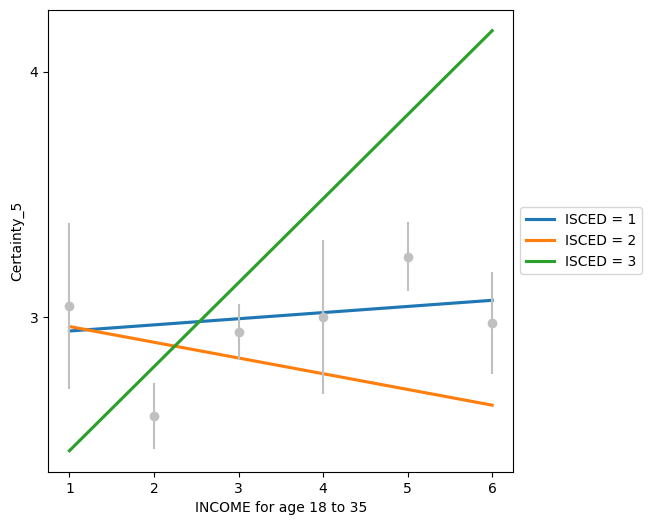

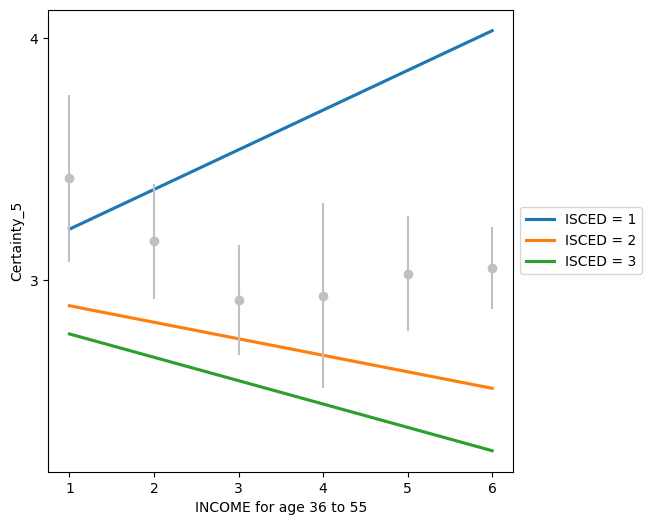

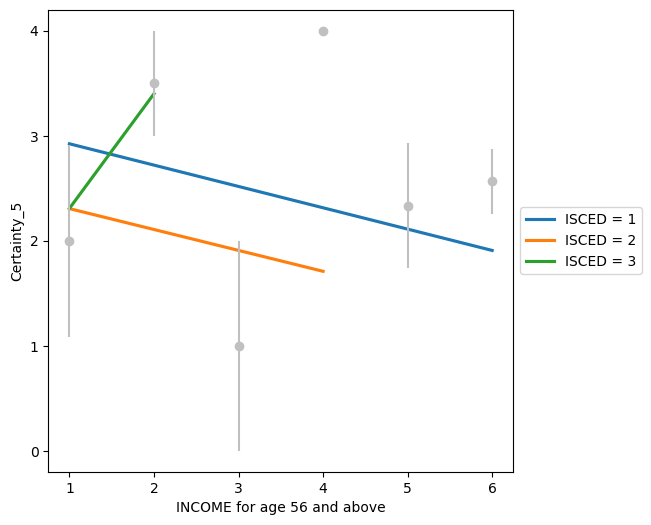

In [77]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Certainty_5', xlabel='INCOME for age 18 to 35',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['Certainty_5'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Certainty_5', xlabel='INCOME for age 36 to 55',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['Certainty_5'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Certainty_5', xlabel='INCOME for age 56 and above',  yticks = np.arange(0, 6 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['Certainty_5'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

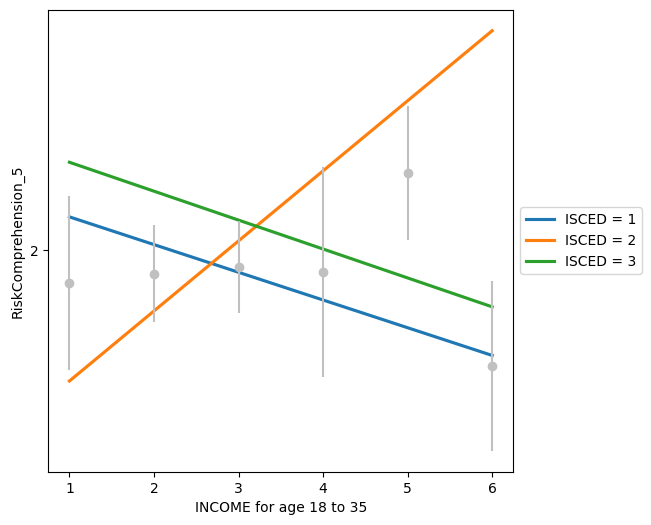

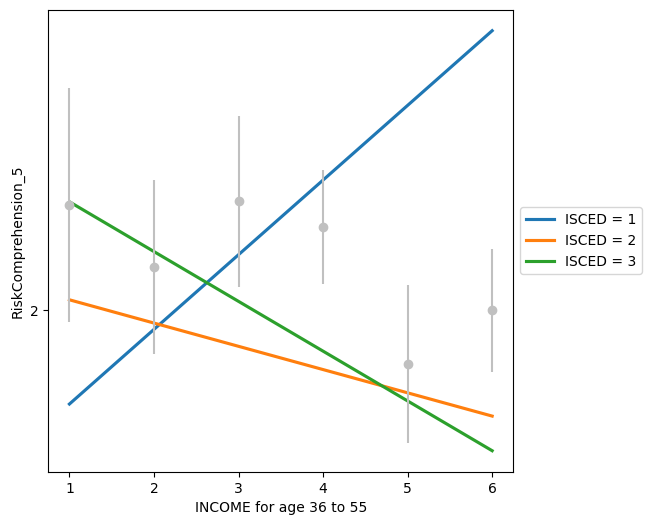

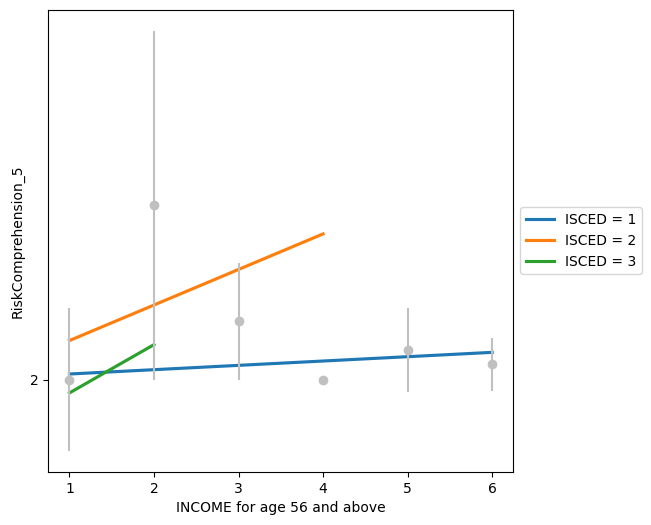

In [78]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='RiskComprehension_5', xlabel='INCOME for age 18 to 35',  yticks = np.arange(0, 3 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['RiskComprehension_5'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='RiskComprehension_5', xlabel='INCOME for age 36 to 55',  yticks = np.arange(0, 3 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['RiskComprehension_5'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='RiskComprehension_5', xlabel='INCOME for age 56 and above',  yticks = np.arange(0, 3 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['RiskComprehension_5'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

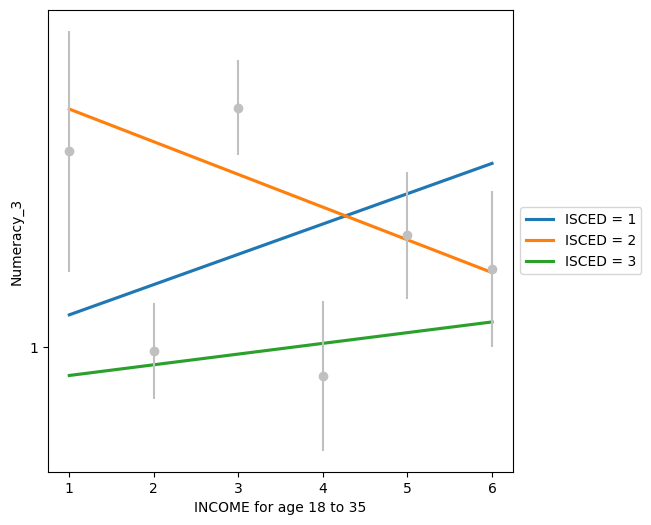

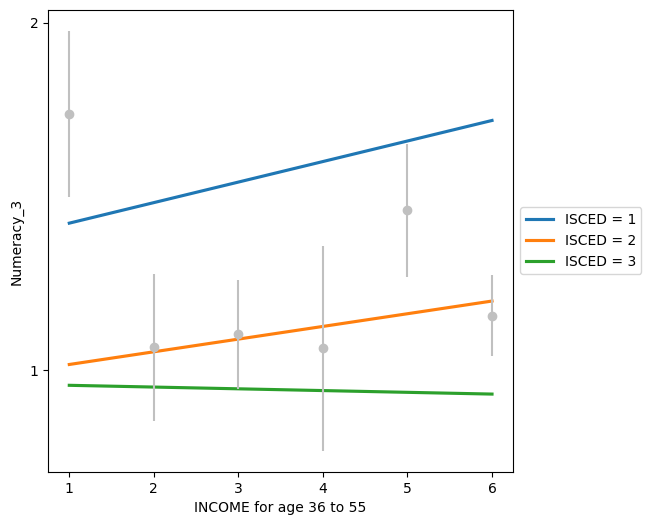

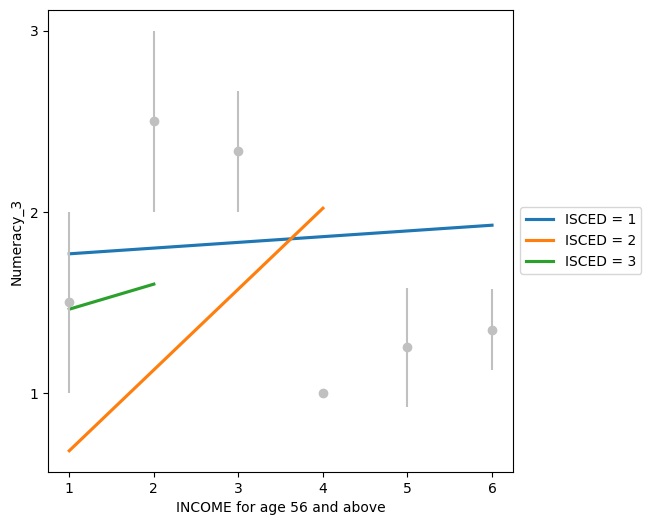

In [79]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Numeracy_3', xlabel='INCOME for age 18 to 35',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Numeracy_3', xlabel='INCOME for age 36 to 55',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Numeracy_3', xlabel='INCOME for age 56 and above',  yticks = np.arange(0, 6 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

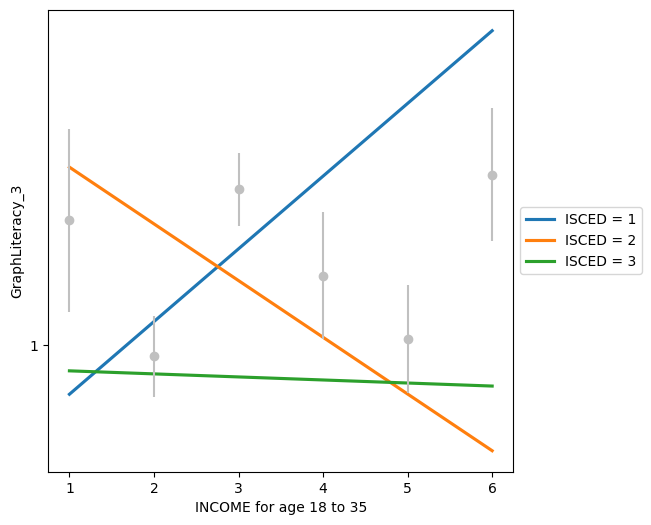

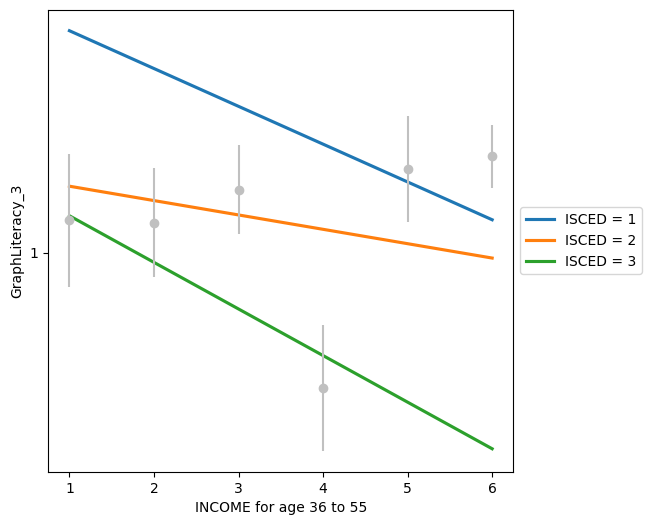

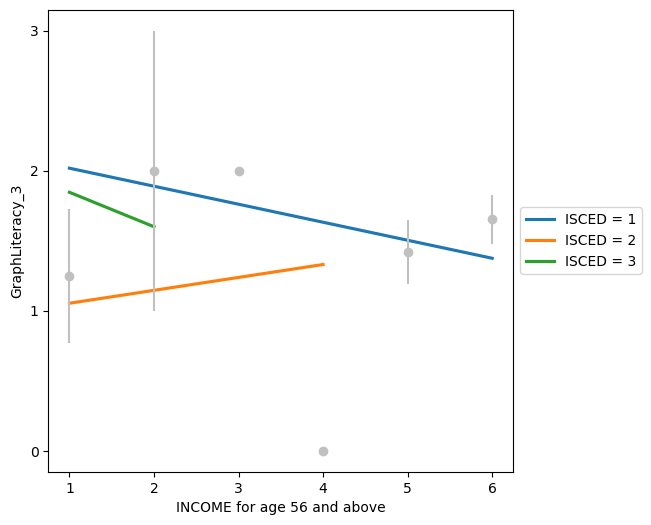

In [80]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='GraphLiteracy_3', xlabel='INCOME for age 18 to 35',  yticks = np.arange(0, 4 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='GraphLiteracy_3', xlabel='INCOME for age 36 to 55',  yticks = np.arange(0, 4 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='GraphLiteracy_3', xlabel='INCOME for age 56 and above',  yticks = np.arange(0, 4 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

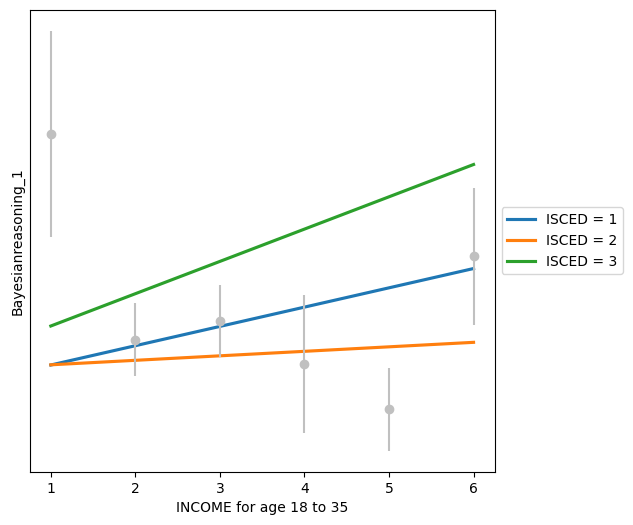

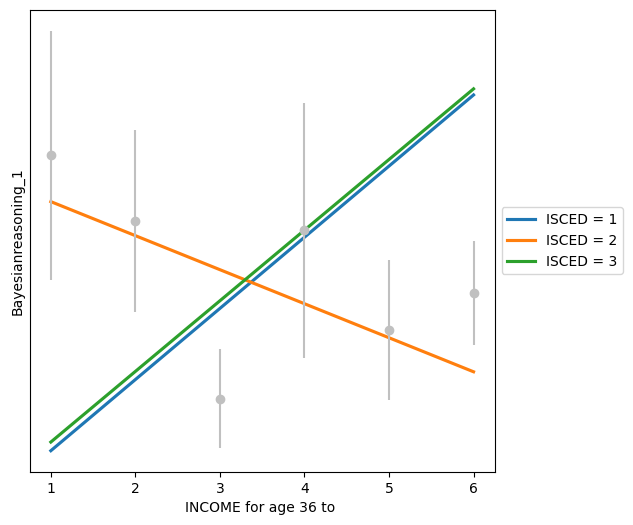

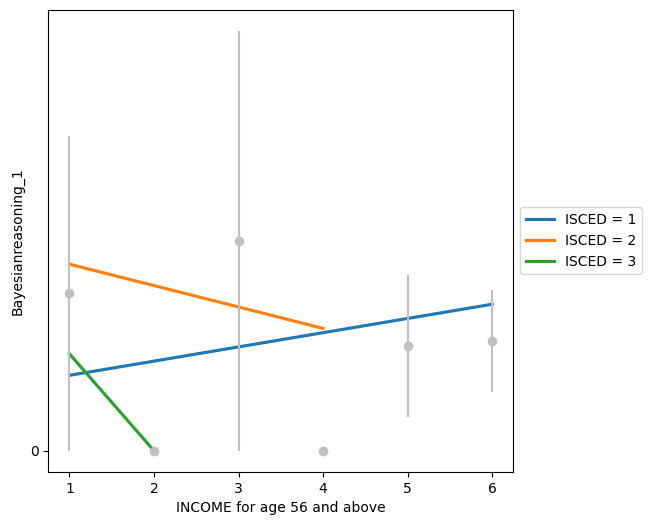

In [81]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for age 18 to 35',  yticks = np.arange(0, 5 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for age 36 to ',  yticks = np.arange(0, 5 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for age 56 and above',  yticks = np.arange(0, 5 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

In [82]:
# Age mean method
# Age_mean

In [83]:
age_m = df2["age"].median()
age_m

33.0

In [84]:
df7["income"].value_counts()

income
2    221
1    194
3    114
4     76
5     52
6     42
Name: count, dtype: int64

In [85]:
df7.loc[(df7['age'] < age_m)].describe()

ResponseId         age  age_rec       isced      income        wealth  \
count  338.000000  338.000000    338.0  338.000000  338.000000  3.380000e+02   
mean   345.745562   26.260355      2.0    1.970414    2.349112  2.412677e+06   
std    194.884917    3.812788      0.0    0.762053    1.365976  4.184664e+06   
min      0.000000   18.000000      2.0    1.000000    1.000000  5.000000e+03   
25%    205.250000   24.000000      2.0    1.000000    1.000000  7.000000e+04   
50%    343.500000   26.000000      2.0    2.000000    2.000000  5.000000e+05   
75%    509.500000   30.000000      2.0    3.000000    3.000000  2.500000e+06   
max    693.000000   32.000000      2.0    3.000000    6.000000  1.500000e+07   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   338.000000     338.000000           338.000000       338.000000   
mean      2.855030       0.470414             1.946746         1.171598   
std       1.420386       0.616788             0.744996         0.956079   
min       0.000000       0.000000             1.000000         0.000000   
25%       2.000000       0.000000             1.000000         0.000000   
50%       3.000000       0.000000             2.000000         1.000000   
75%       4.000000       1.000000             2.000000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_3  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  338.000000           338.000000   338.000000     338.000000   
mean     1.251479             0.260355    57.100592      23.520710   
std      1.129092             0.439479    28.407723      30.839412   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    40.000000       0.000000   
50%      1.000000             0.000000    60.000000       0.000000   
75%      2.000000             1.000000    80.000000      50.000000   
max      3.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           338.000000       338.000000  338.000000           338.000000   
mean             38.934911        39.053254   41.715976            26.035503   
std              14.899920        31.869300   37.636410            43.947891   
min              20.000000         0.000000    0.000000             0.000000   
25%              20.000000         0.000000    0.000000             0.000000   
50%              40.000000        33.333333   33.333333             0.000000   
75%              40.000000        66.666667   66.666667           100.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_19  TotalScore_%  
count     338.000000    338.000000  
mean        7.955621     41.871691  
std         2.507161     13.195587  
min         2.000000     10.526316  
25%         6.000000     31.578947  
50%         8.000000     42.105263  
75%        10.000000     52.631579  
max        15.000000     78.947368

In [86]:
df7.loc[(df7['age'] >= age_m)].describe()

ResponseId         age     age_rec       isced      income  \
count  361.000000  361.000000  361.000000  361.000000  361.000000   
mean   352.047091   43.559557    2.883657    1.900277    2.770083   
std    208.531334    9.491366    0.594217    0.847234    1.552701   
min      1.000000   33.000000    2.000000    1.000000    1.000000   
25%    162.000000   36.000000    3.000000    1.000000    2.000000   
50%    353.000000   41.000000    3.000000    2.000000    2.000000   
75%    547.000000   47.000000    3.000000    3.000000    4.000000   
max    698.000000   75.000000    4.000000    3.000000    6.000000   

             wealth  Certainty_5  Uncertainty_2  RiskComprehension_5  \
count  3.610000e+02   361.000000     361.000000           361.000000   
mean   3.800648e+06     2.991690       0.470914             2.080332   
std    5.176161e+06     1.487891       0.662371             0.786466   
min    5.000000e+03     0.000000       0.000000             1.000000   
25%    1.000000e+05     2.000000       0.000000             2.000000   
50%    1.000000e+06     3.000000       0.000000             2.000000   
75%    5.000000e+06     4.000000       1.000000             3.000000   
max    1.500000e+07     5.000000       2.000000             4.000000   

       GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  Certainty_%  \
count       361.000000  361.000000           361.000000   361.000000   
mean          1.218837    1.227147             0.193906    59.833795   
std           0.954102    1.099715             0.395905    29.757820   
min           0.000000    0.000000             0.000000     0.000000   
25%           0.000000    0.000000             0.000000    40.000000   
50%           1.000000    1.000000             0.000000    60.000000   
75%           2.000000    2.000000             0.000000    80.000000   
max           3.000000    3.000000             1.000000   100.000000   

       Uncertainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count     361.000000           361.000000       361.000000  361.000000   
mean       23.545706            41.606648        40.627886   40.904894   
std        33.118537            15.729320        31.803404   36.657152   
min         0.000000            20.000000         0.000000    0.000000   
25%         0.000000            40.000000         0.000000    0.000000   
50%         0.000000            40.000000        33.333333   33.333333   
75%        50.000000            60.000000        66.666667   66.666667   
max       100.000000            80.000000       100.000000  100.000000   

       Bayesianreasoning_%  TotalScore_19  TotalScore_%  
count           361.000000     361.000000    361.000000  
mean             19.390582       8.182825     43.067503  
std              39.590471       2.820527     14.844877  
min               0.000000       1.000000      5.263158  
25%               0.000000       6.000000     31.578947  
50%               0.000000       8.000000     42.105263  
75%               0.000000      10.000000     52.631579  
max             100.000000      16.000000     84.210526

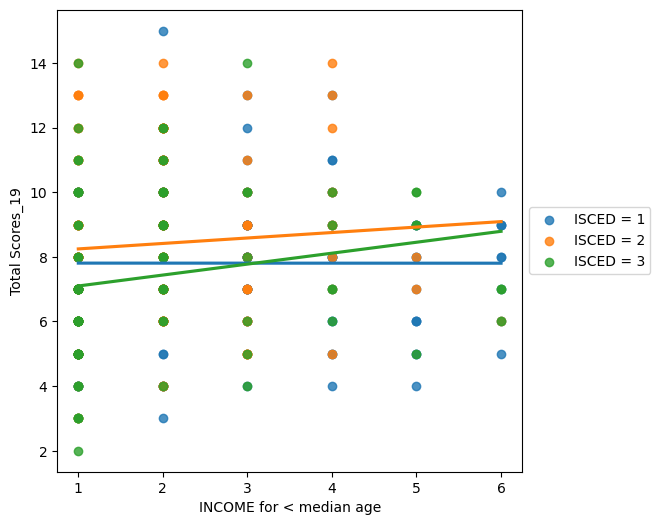

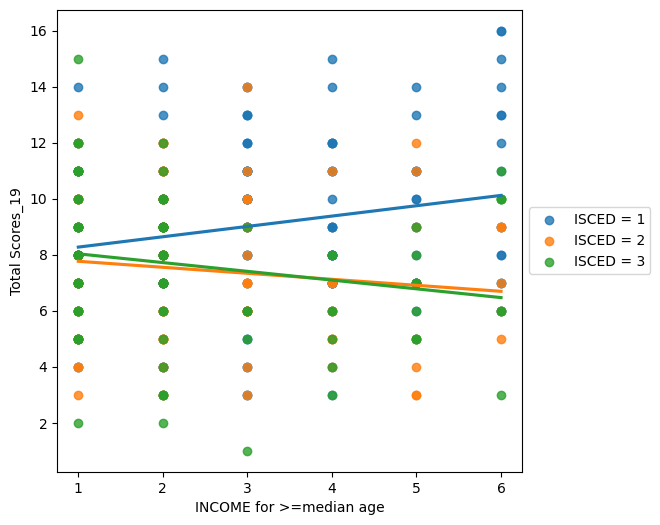

In [87]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Total Scores_19', xlabel='INCOME for < median age')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age'] >= age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_19', xlabel='INCOME for >=median age')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

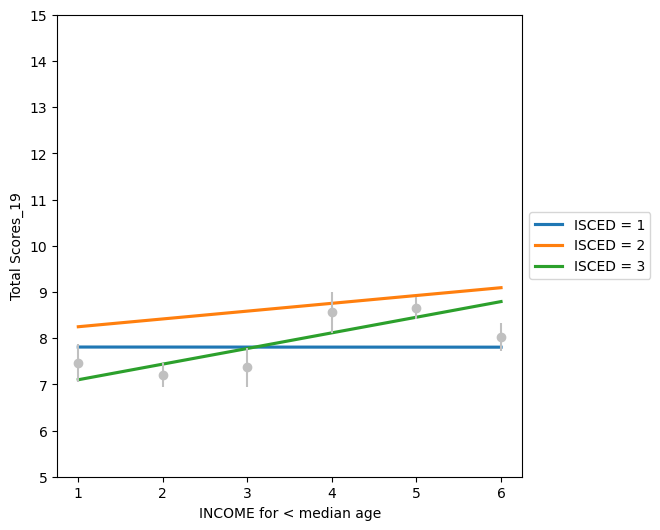

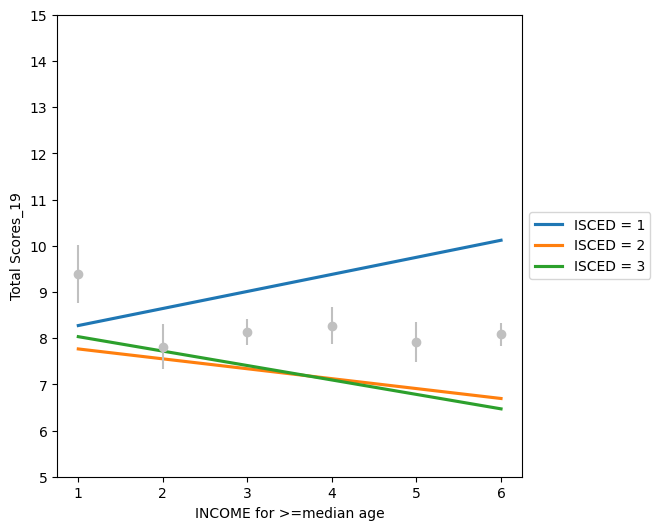

In [88]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ (df7['age'] < age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['TotalScore_19'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['TotalScore_19'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Total Scores_19', xlabel='INCOME for < median age',  yticks = np.arange(5, 16 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df7.loc[ (df7['age'] >= age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] >=age_m)  ].groupby(['income'])['TotalScore_19'].mean(), yerr = df7.loc[ (df7['age'] >=age_m) ].groupby(['income'])['TotalScore_19'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Total Scores_19', xlabel='INCOME for >=median age',  yticks = np.arange(5, 16 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

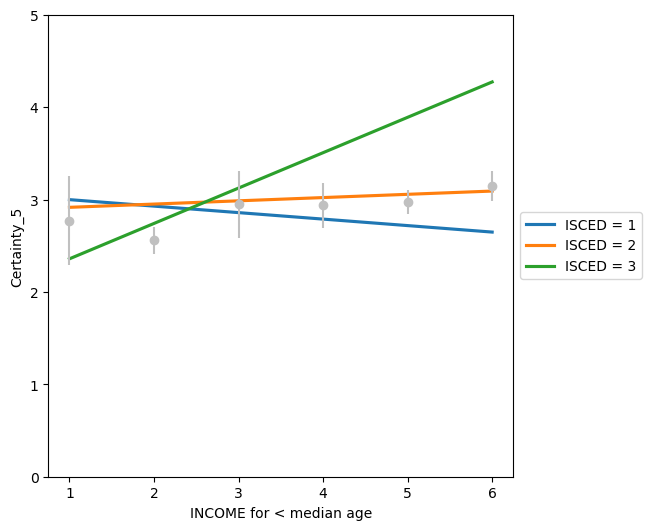

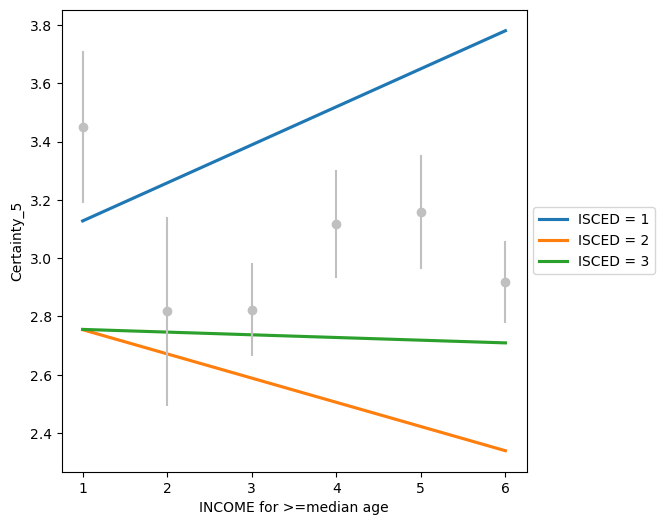

In [89]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ (df7['age'] < age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['Certainty_5'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Certainty_5', xlabel='INCOME for < median age',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df7.loc[ (df7['age'] >= age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] >=age_m)  ].groupby(['income'])['Certainty_5'].mean(), yerr = df7.loc[ (df7['age'] >=age_m) ].groupby(['income'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Certainty_5', xlabel='INCOME for >=median age')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

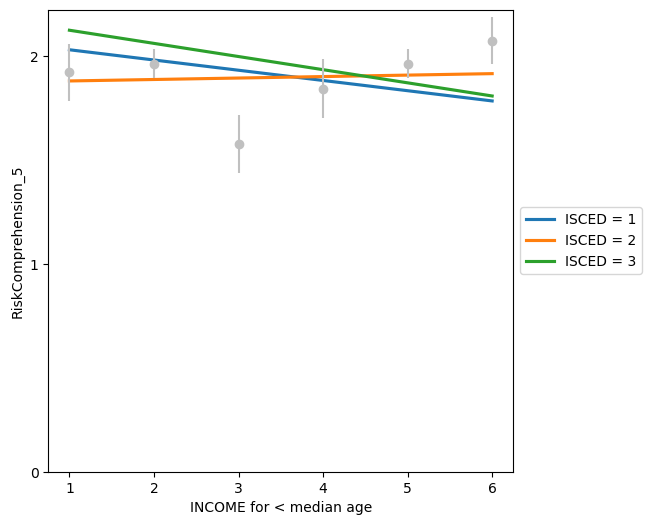

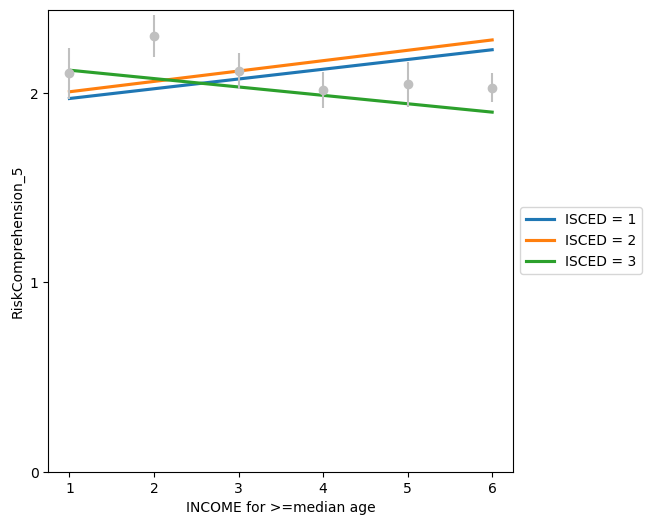

In [90]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ (df7['age'] < age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['RiskComprehension_5'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='RiskComprehension_5', xlabel='INCOME for < median age',  yticks = np.arange(0, 3 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df7.loc[ (df7['age'] >= age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] >=age_m)  ].groupby(['income'])['RiskComprehension_5'].mean(), yerr = df7.loc[ (df7['age'] >=age_m) ].groupby(['income'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='RiskComprehension_5', xlabel='INCOME for >=median age',  yticks = np.arange(0, 3 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

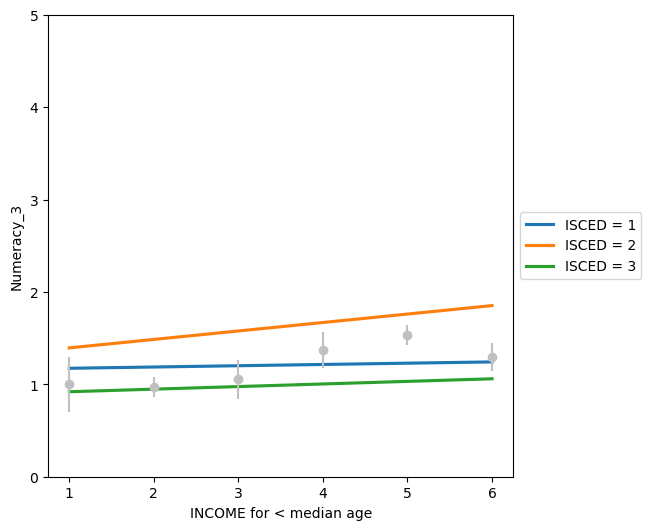

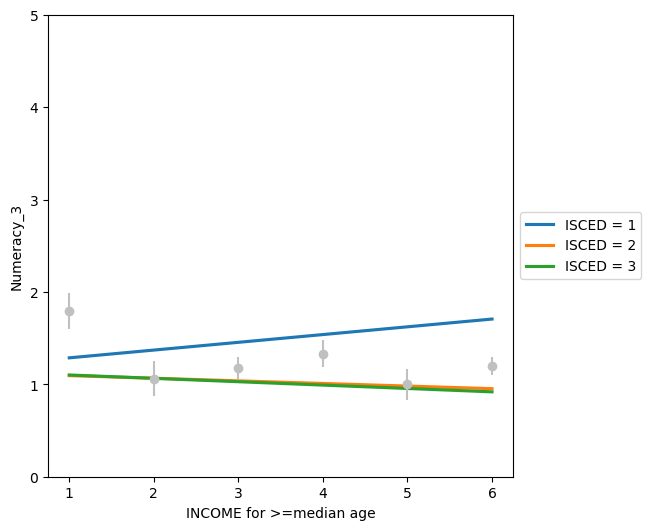

In [91]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ (df7['age'] < age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Numeracy_3', xlabel='INCOME for < median age',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df7.loc[ (df7['age'] >= age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] >=age_m)  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age'] >=age_m) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Numeracy_3', xlabel='INCOME for >=median age',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

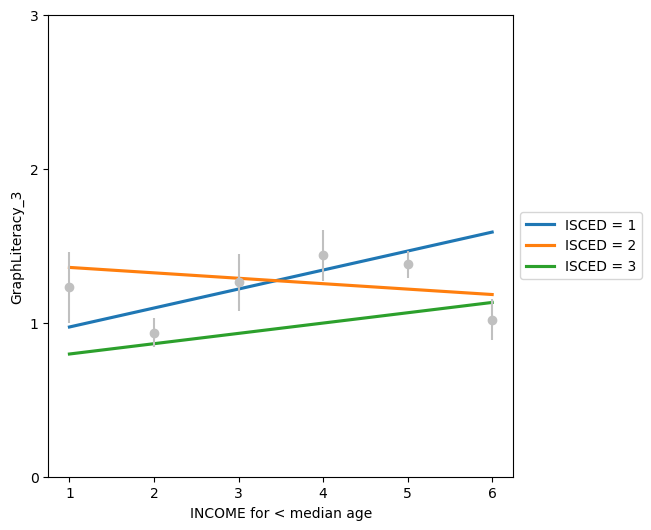

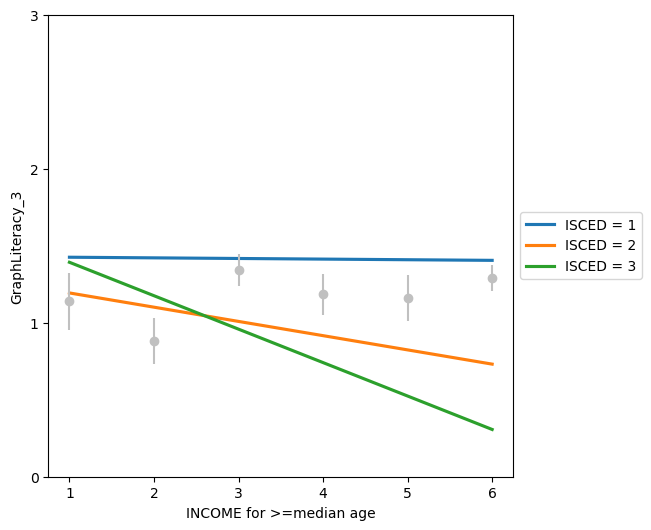

In [92]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ (df7['age'] < age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='GraphLiteracy_3', xlabel='INCOME for < median age',  yticks = np.arange(0, 4 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df7.loc[ (df7['age'] >= age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] >=age_m)  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age'] >=age_m) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='GraphLiteracy_3', xlabel='INCOME for >=median age',  yticks = np.arange(0, 4 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

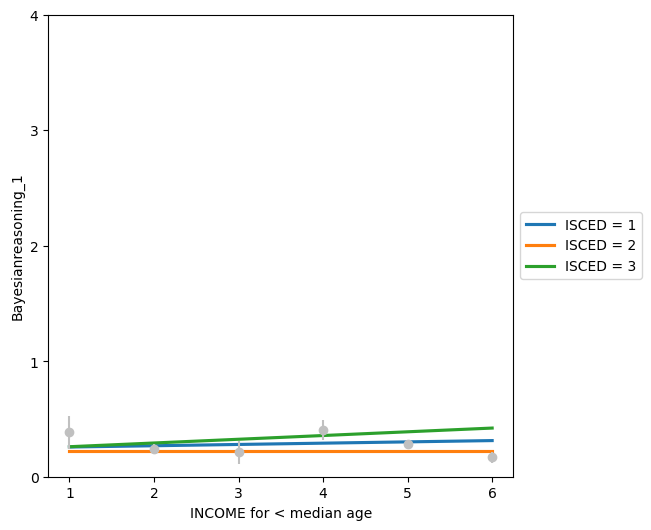

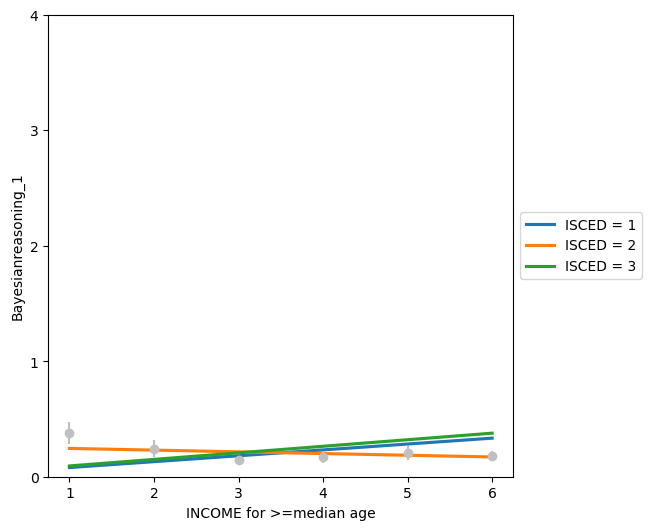

In [93]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ (df7['age'] < age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for < median age',  yticks = np.arange(0, 5 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df7.loc[ (df7['age'] >= age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] >=age_m)  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age'] >=age_m) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for >=median age',  yticks = np.arange(0, 5 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

## WEALTH

In [94]:
# Data Frame 2 or df2 is an aggregate data on facet total scores and over all total score, along with wealth and income data vs each response. 
# This data set is also sorted by wealth with all responses 'NA' removed.
# We also assign quartiles ranking each response according to this sort.

df4 = df2.sort_values(by = 'wealth')
df4 = df4.reset_index(drop = True)
df4 = df4.dropna(axis = 0, subset = 'wealth')
df4.insert(loc = len(df4.columns), column = "Quartile Number", value = pd.qcut(df4["wealth"],q = 4, labels = False ) + 1, allow_duplicates = 'False')

df4

ResponseId   age  age_rec  isced  income      wealth  Certainty_5  \
0           369  40.0        3      3       2      5000.0            3   
1           391  52.0        3      3       4      5000.0            4   
2           393  18.0        2      3       1      5000.0            1   
3           405  18.0        2      2       1      5000.0            2   
4           406  27.0        2      2       1      5000.0            2   
..          ...   ...      ...    ...     ...         ...          ...   
694         608  50.0        3      1       5  15000000.0            3   
695         256  18.0        2      3       2  15000000.0            3   
696         602  33.0        2      1       2  15000000.0            4   
697         598  27.0        2      1       5  15000000.0            2   
698         349  37.0        3      3       2  15000000.0            0   

     Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
0                0                    2                0           1   
1                0                    2                2           0   
2                0                    3                1           0   
3                1                    1                1           0   
4                1                    3                2           0   
..             ...                  ...              ...         ...   
694              2                    2                3           3   
695              1                    2                2           0   
696              0                    2                1           2   
697              0                    2                1           3   
698              0                    1                1           0   

     Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
0                      0         60.0            0.0                 40.0   
1                      0         80.0            0.0                 40.0   
2                      0         20.0            0.0                 60.0   
3                      0         40.0           50.0                 20.0   
4                      0         40.0           50.0                 60.0   
..                   ...          ...            ...                  ...   
694                    0         60.0          100.0                 40.0   
695                    0         60.0           50.0                 40.0   
696                    0         80.0            0.0                 40.0   
697                    1         40.0            0.0                 40.0   
698                    0          0.0            0.0                 20.0   

     GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_19  \
0           0.000000   33.333333                  0.0              6   
1          66.666667    0.000000                  0.0              8   
2          33.333333    0.000000                  0.0              5   
3          33.333333    0.000000                  0.0              5   
4          66.666667    0.000000                  0.0              8   
..               ...         ...                  ...            ...   
694       100.000000  100.000000                  0.0             13   
695        66.666667    0.000000                  0.0              8   
696        33.333333   66.666667                  0.0              9   
697        33.333333  100.000000                100.0              9   
698        33.333333    0.000000                  0.0              2   

     TotalScore_%  Quartile Number  
0       31.578947                1  
1       42.105263                1  
2       26.315789                1  
3       26.315789                1  
4       42.105263                1  
..            ...              ...  
694     68.421053                4  
695     42.105263                4  
696     47.368421                4  
697     47.368421                4  
698     10.526316                4  

[699 rows x 21 c

<Axes: ylabel='TotalScore_19'>

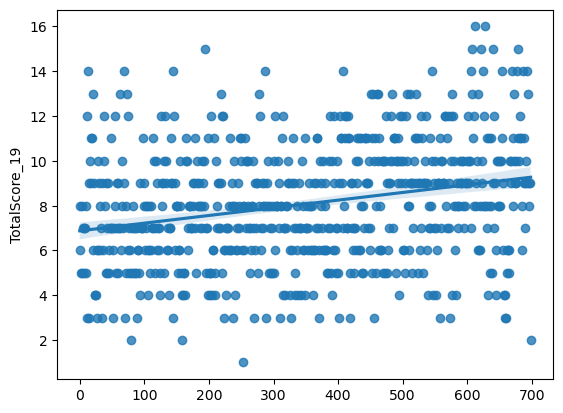

In [95]:
# Trend line for Absolute Total Facet Score vs unique wealth reponses

sns.regplot (data = df4, x = df4.index, y = 'TotalScore_19')

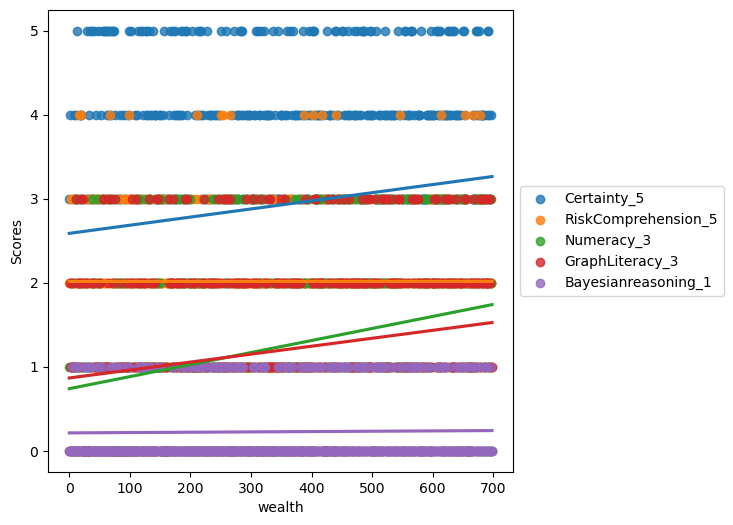

In [96]:
# Trend line for Absolute Independent Facet Score vs wealth reponses

fig1, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4, x = df4.index, y = 'Certainty_5', fit_reg=True, ci=None, ax=ax1, label='Certainty_5')
sns.regplot (data = df4, x = df4.index, y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax1, label='RiskComprehension_5')
sns.regplot (data = df4, x = df4.index, y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax1, label='Numeracy_3')
sns.regplot (data = df4, x = df4.index, y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax1, label='GraphLiteracy_3')
sns.regplot (data = df4, x = df4.index, y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax1, label='Bayesianreasoning_1' )

ax1.set(ylabel='Scores', xlabel='wealth')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [97]:
# Count of number of responses under each quartile

df4.groupby('Quartile Number')[['Quartile Number']].count()

Quartile Number
Quartile Number                 
1                            224
2                            129
3                            173
4                            173

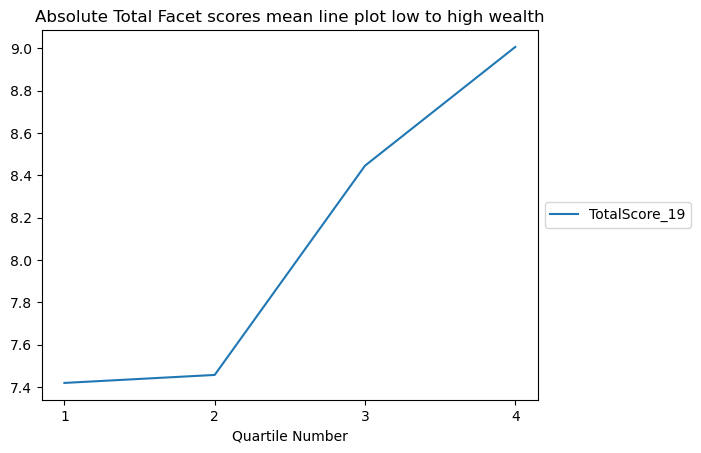

In [98]:
# Absolute Total Facet scores mean line plot from low to high Wealth

df4.groupby('Quartile Number')[['TotalScore_19']].mean().plot( kind = 'line', title = 'Absolute Total Facet scores mean line plot low to high wealth', xticks = np.arange(1,5,step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

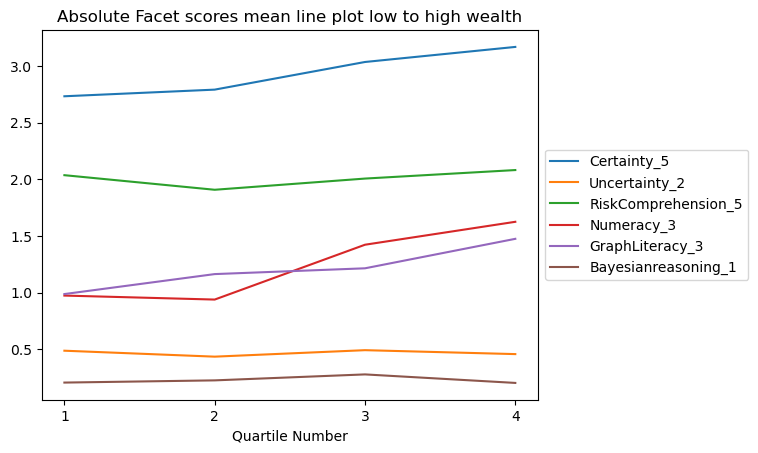

In [99]:
# Absolute Facet scores mean line plot from low to high wealth

df4.groupby('Quartile Number')[['Certainty_5', "Uncertainty_2", 'RiskComprehension_5','Numeracy_3','GraphLiteracy_3','Bayesianreasoning_1']].mean().plot( kind = 'line', title = 'Absolute Facet scores mean line plot low to high wealth', xticks = np.arange(1,5,step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

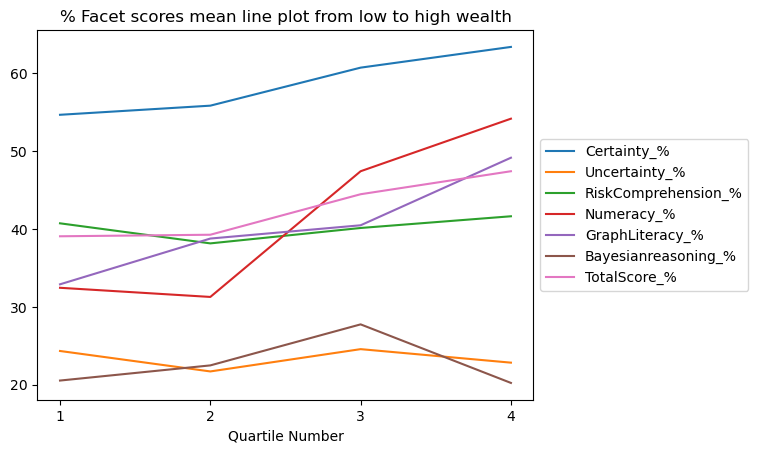

In [100]:
# Normalised Facet scores mean line plot from low to high wealth


df4.groupby('Quartile Number')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().plot( kind = 'line', title = '% Facet scores mean line plot from low to high wealth',  xticks = np.arange(1,5,step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

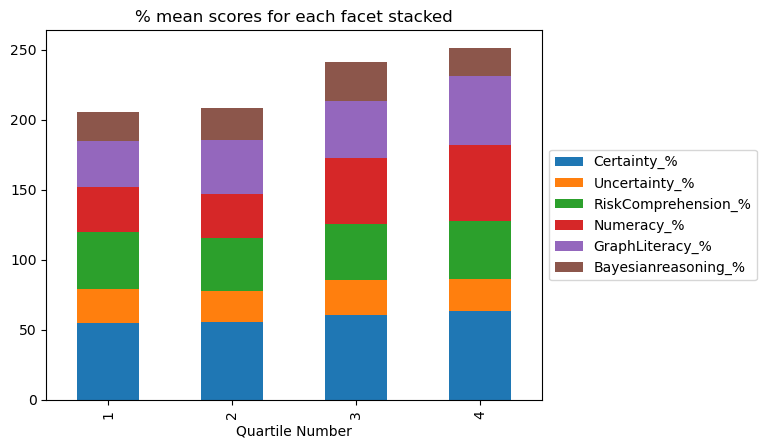

In [101]:
# Normalised mean scores for each facet stacked

df4.groupby('Quartile Number')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%']].mean().plot( kind = 'bar', title = '% mean scores for each facet stacked', stacked = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

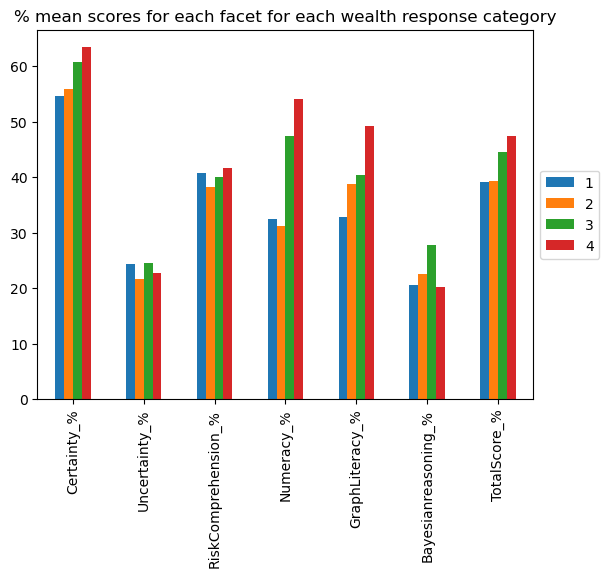

In [102]:
# Normalised mean scores for each facet for each wealth response Quartile

df4.groupby('Quartile Number')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().T.plot(kind = 'bar', title = '% mean scores for each facet for each wealth response category').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: xlabel='Quartile Number', ylabel='TotalScore_19'>

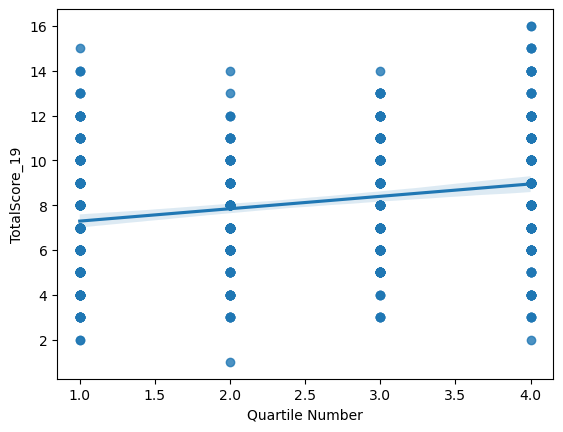

In [103]:
# Trend line for Absolute Total Facet Score vs Quartiles

sns.regplot (data = df4, x = 'Quartile Number', y = 'TotalScore_19')

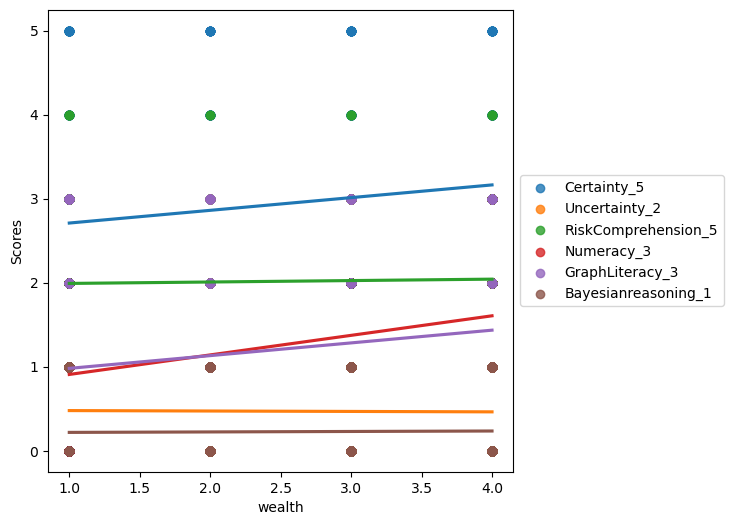

In [104]:
# Trend line for Absolute Independent Facet Score vs Quartiles

fig2, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4, x = 'Quartile Number', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax2, label='Certainty_5')
sns.regplot (data = df4, x = 'Quartile Number', y = 'Uncertainty_2', fit_reg=True, ci=None, ax=ax2, label='Uncertainty_2')
sns.regplot (data = df4, x = 'Quartile Number', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax2, label='RiskComprehension_5')
sns.regplot (data = df4, x = 'Quartile Number', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax2, label='Numeracy_3')
sns.regplot (data = df4, x = 'Quartile Number', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax2, label='GraphLiteracy_3')
sns.regplot (data = df4, x = 'Quartile Number', y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax2, label='Bayesianreasoning_1' )

ax2.set(ylabel='Scores', xlabel='wealth')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

<Axes: xlabel='Quartile Number', ylabel='TotalScore_19'>

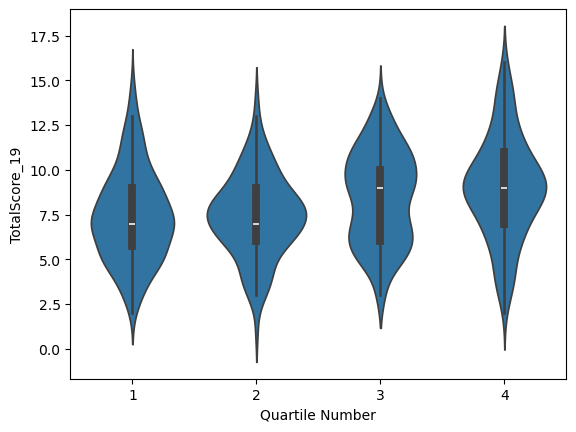

In [105]:
# Violine Plot for TotalScore_19 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'TotalScore_19')

<Axes: xlabel='Quartile Number', ylabel='Certainty_5'>

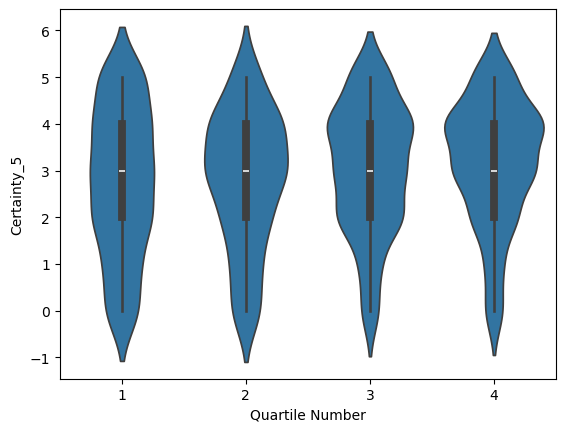

In [106]:
# Violine Plot for Certainty_5 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Certainty_5')

<Axes: xlabel='Quartile Number', ylabel='Uncertainty_2'>

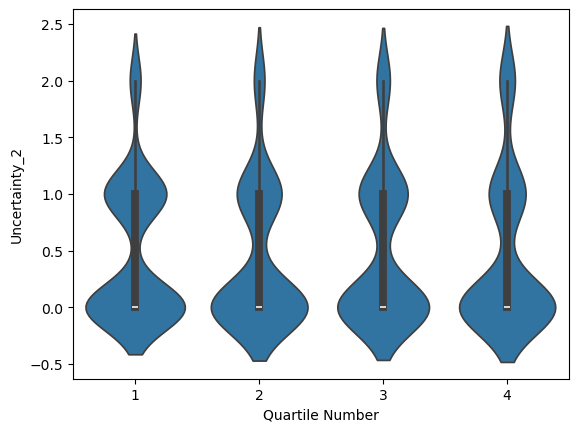

In [107]:
# Violine Plot for Certainty_5 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Uncertainty_2')

<Axes: xlabel='Quartile Number', ylabel='RiskComprehension_5'>

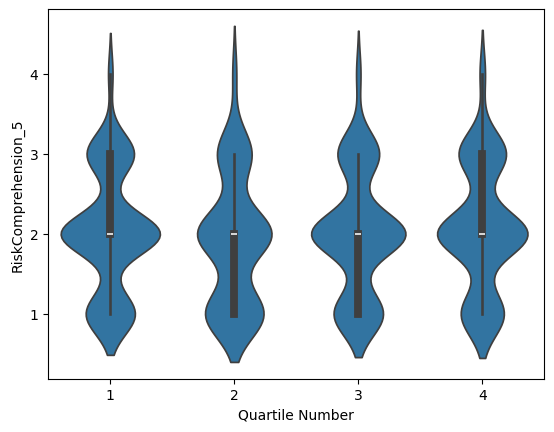

In [108]:
# Violine Plot for RiskComprehension_5 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'RiskComprehension_5')

<Axes: xlabel='Quartile Number', ylabel='GraphLiteracy_3'>

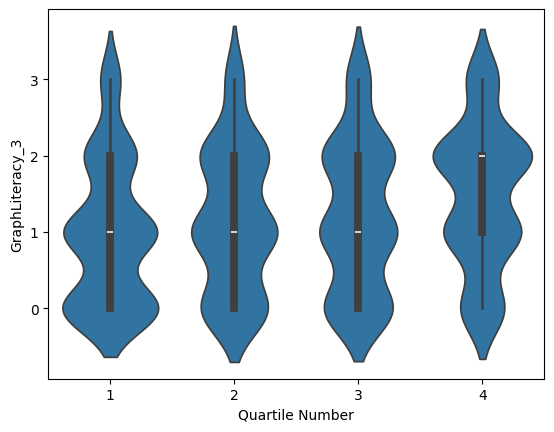

In [109]:
# Violine Plot for GraphLiteracy_3 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'GraphLiteracy_3')

<Axes: xlabel='Quartile Number', ylabel='Numeracy_3'>

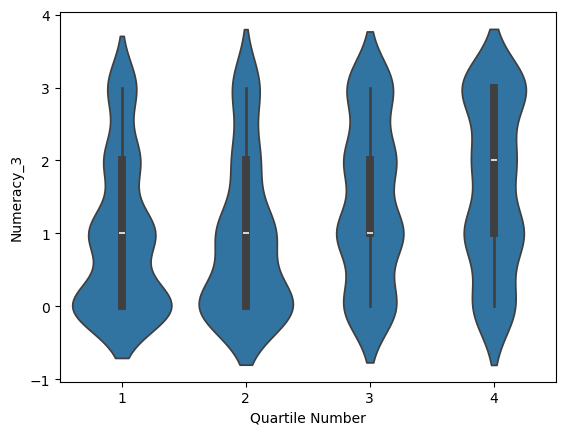

In [110]:
# Violine Plot for Numeracy_3 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Numeracy_3')

<Axes: xlabel='Quartile Number', ylabel='Bayesianreasoning_1'>

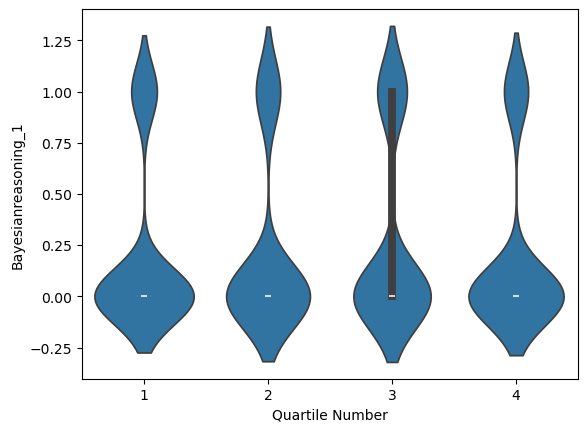

In [111]:
# Violine Plot for Bayesianreasoning_1 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Bayesianreasoning_1')

### WEALTH vs SCORES w/ ISCED classification

In [112]:
# Descriptive stats for the data set, isced = 1
# NA values of wealth are removed

df6 = df5.dropna(axis = 0, subset = 'wealth')
# df6.drop(df6[df6['wealth'] == 3500000].index, inplace = True)
df6.loc[df6['isced']==1][['wealth']].describe()

wealth
count  2.520000e+02
mean   4.887746e+06
std    5.578940e+06
min    5.000000e+03
25%    3.875000e+05
50%    2.500000e+06
75%    9.125000e+06
max    1.500000e+07

In [113]:
# Descriptive stats for the data set, isced = 2

df6.loc[df6['isced']==2][['wealth']].describe()

wealth
count  2.410000e+02
mean   2.336963e+06
std    3.987210e+06
min    5.000000e+03
25%    1.000000e+05
50%    5.000000e+05
75%    2.500000e+06
max    1.500000e+07

In [114]:
# Descriptive stats for the data set, isced = 3

df6.loc[df6['isced']==3][['wealth']].describe()

wealth
count  2.060000e+02
mean   1.905820e+06
std    3.835872e+06
min    5.000000e+03
25%    2.125000e+04
50%    2.000000e+05
75%    1.500000e+06
max    1.500000e+07

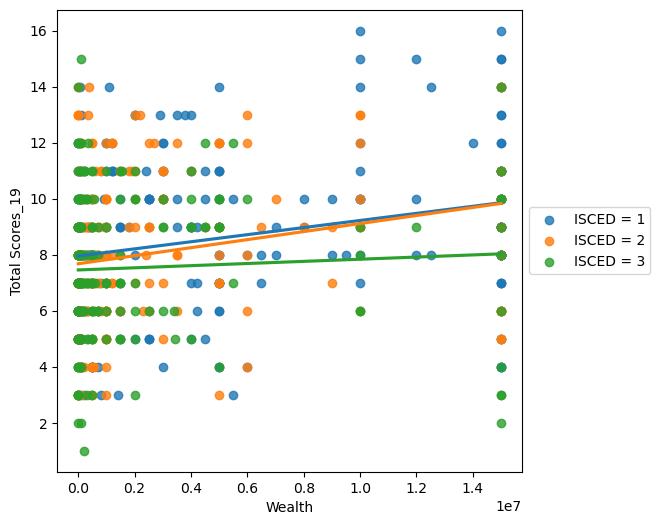

In [115]:
# Trend line for Absolute Tota Facet Score vs wealth reponses sorted by isced and ORDERED by wealth WITH scatter

fig, ax7 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'TotalScore_19', fit_reg=True, ci=None, ax=ax7, label='ISCED = 1')
sns.regplot (data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'TotalScore_19', fit_reg=True, ci=None, ax=ax7, label='ISCED = 2')
sns.regplot (data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'TotalScore_19', fit_reg=True, ci=None, ax=ax7, label='ISCED = 3')

ax7.set(ylabel='Total Scores_19', xlabel='Wealth')
ax7.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

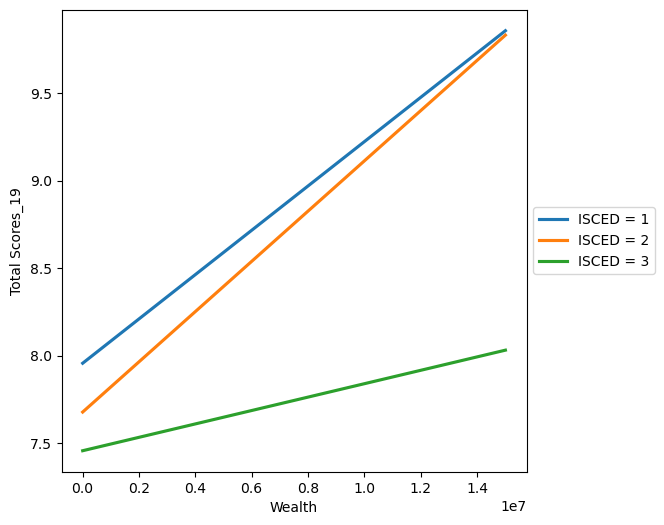

In [116]:
# Trend line for Absolute Tota Facet Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax8 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'TotalScore_19', fit_reg=True, ci=None, ax=ax8, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'TotalScore_19', fit_reg=True, ci=None, ax=ax8, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'TotalScore_19', fit_reg=True, ci=None, ax=ax8, label='ISCED = 3')

ax8.set(ylabel='Total Scores_19', xlabel='Wealth')
ax8.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

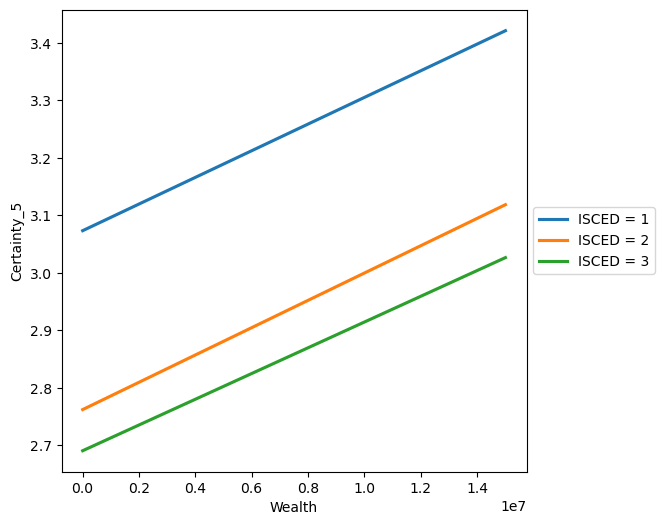

In [117]:
# Trend line for Absolute Certainty Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax9 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 3')

ax9.set(ylabel='Certainty_5', xlabel='Wealth')
ax9.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

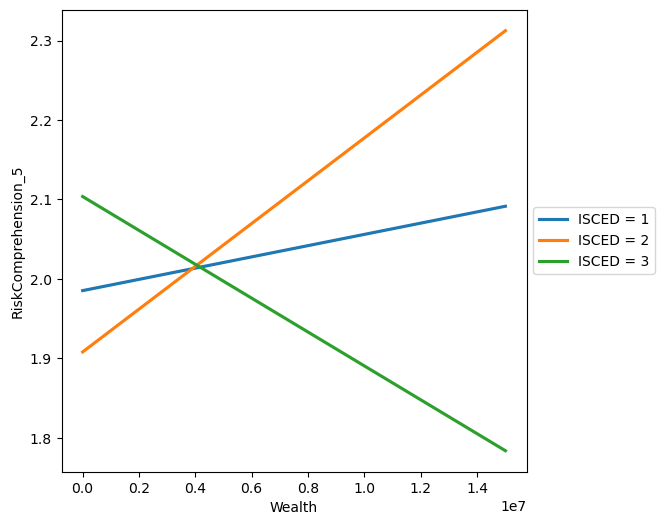

In [118]:
# Trend line for Absolute Uncertainty Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax10 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 3')

ax10.set(ylabel='RiskComprehension_5', xlabel='Wealth')
ax10.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

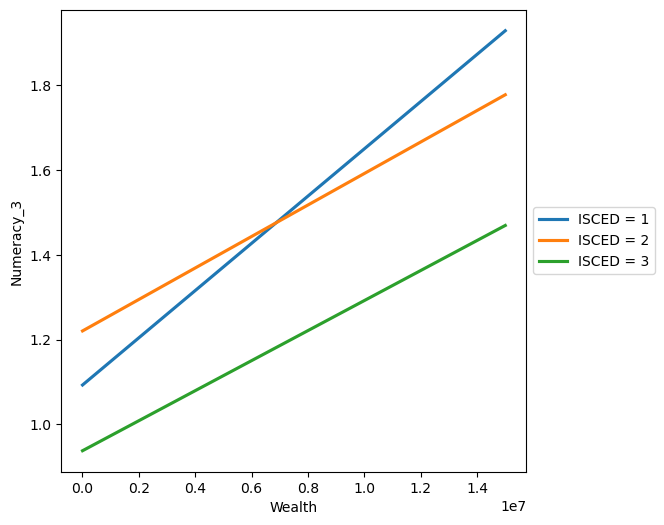

In [119]:
# Trend line for Absolute Number Comprehension Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='Numeracy_3', xlabel='Wealth')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

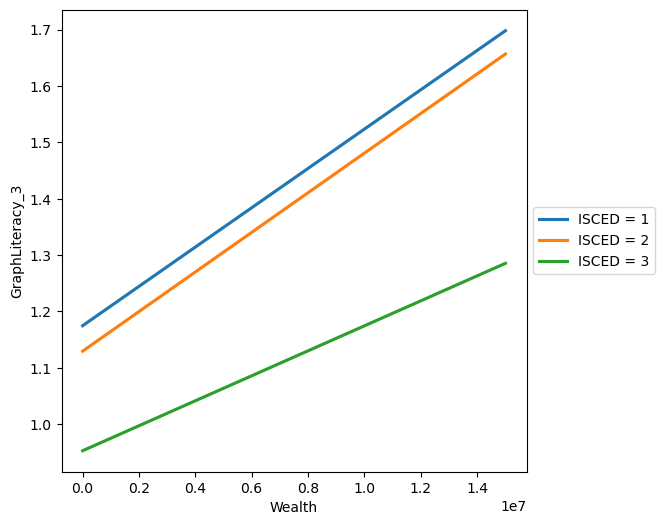

In [120]:
# Trend line for Absolute Graph Comprehension Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='GraphLiteracy_3', xlabel='Wealth')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

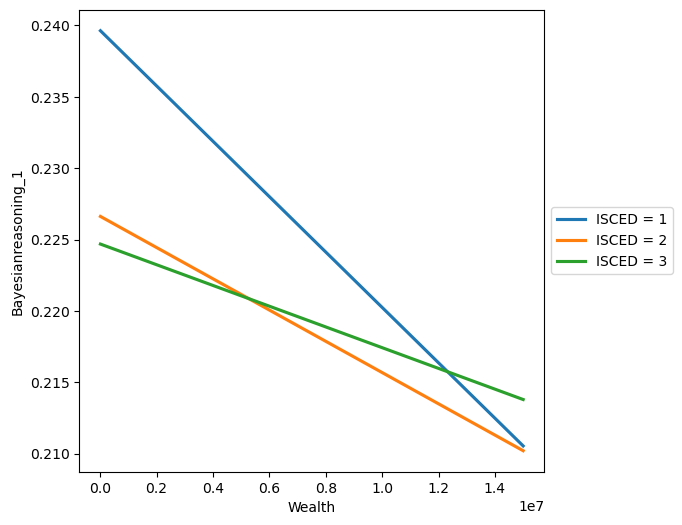

In [121]:
# Trend line for Absolute Bayesian Reasoning Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax12 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 3')

ax12.set(ylabel='Bayesianreasoning_1', xlabel='Wealth')
ax12.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

### WEALTH Quartile Number vs SCORES w/ ISCED and AGE based classification

In [122]:
# Descriptive stats for the data set, isced = 1
# NA values of wealth are removed

df4.loc[df4['isced']==1].describe()

ResponseId         age     age_rec  isced      income        wealth  \
count  252.000000  252.000000  252.000000  252.0  252.000000  2.520000e+02   
mean   370.682540   35.757937    2.460317    1.0    3.234127  4.887746e+06   
std    272.942711    8.983880    0.587395    0.0    1.432667  5.578940e+06   
min      0.000000   19.000000    2.000000    1.0    1.000000  5.000000e+03   
25%    102.750000   30.000000    2.000000    1.0    2.000000  3.875000e+05   
50%    572.500000   34.500000    2.000000    1.0    3.000000  2.500000e+06   
75%    635.250000   40.000000    3.000000    1.0    4.000000  9.125000e+06   
max    698.000000   66.000000    4.000000    1.0    6.000000  1.500000e+07   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   252.000000     252.000000           252.000000       252.000000   
mean      3.186508       0.428571             2.019841         1.345238   
std       1.445193       0.661142             0.738527         0.959258   
min       0.000000       0.000000             1.000000         0.000000   
25%       2.000000       0.000000             2.000000         1.000000   
50%       3.000000       0.000000             2.000000         1.000000   
75%       4.000000       1.000000             2.250000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_3  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  252.000000           252.000000   252.000000     252.000000   
mean     1.365079             0.230159    63.730159      21.428571   
std      1.094012             0.421772    28.903856      33.057099   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    40.000000       0.000000   
50%      1.000000             0.000000    60.000000       0.000000   
75%      2.000000             0.000000    80.000000      50.000000   
max      3.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           252.000000       252.000000  252.000000           252.000000   
mean             40.396825        44.841270   45.502646            23.015873   
std              14.770531        31.975276   36.467083            42.177199   
min              20.000000         0.000000    0.000000             0.000000   
25%              40.000000        33.333333    0.000000             0.000000   
50%              40.000000        33.333333   33.333333             0.000000   
75%              45.000000        66.666667   66.666667             0.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_19  TotalScore_%  Quartile Number  
count     252.000000    252.000000       252.000000  
mean        8.575397     45.133668         2.845238  
std         2.748101     14.463692         1.158657  
min         3.000000     15.789474         1.000000  
25%         7.000000     36.842105         2.000000  
50%         8.000000     42.105263         3.000000  
75%        10.000000     52.631579         4.000000  
max        16.000000     84.210526         4.000000

In [123]:
df4.loc[df4['isced']==2].describe()

ResponseId        age     age_rec  isced      income        wealth  \
count  241.000000  241.00000  241.000000  241.0  241.000000  2.410000e+02   
mean   327.900415   33.40249    2.373444    2.0    2.224066  2.336963e+06   
std    174.356168   11.55926    0.599965    0.0    1.227973  3.987210e+06   
min      2.000000   18.00000    2.000000    2.0    1.000000  5.000000e+03   
25%    182.000000   25.00000    2.000000    2.0    1.000000  1.000000e+05   
50%    398.000000   30.00000    2.000000    2.0    2.000000  5.000000e+05   
75%    490.000000   39.00000    3.000000    2.0    3.000000  2.500000e+06   
max    556.000000   72.00000    4.000000    2.0    6.000000  1.500000e+07   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   241.000000     241.000000           241.000000       241.000000   
mean      2.817427       0.481328             1.970954         1.211618   
std       1.375328       0.619697             0.771353         0.917895   
min       0.000000       0.000000             1.000000         0.000000   
25%       2.000000       0.000000             1.000000         0.000000   
50%       3.000000       0.000000             2.000000         1.000000   
75%       4.000000       1.000000             2.000000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_3  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  241.000000           241.000000   241.000000     241.000000   
mean     1.307054             0.224066    56.348548      24.066390   
std      1.109200             0.417834    27.506569      30.984871   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    40.000000       0.000000   
50%      1.000000             0.000000    60.000000       0.000000   
75%      2.000000             0.000000    80.000000      50.000000   
max      3.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           241.000000       241.000000  241.000000           241.000000   
mean             39.419087        40.387275   43.568465            22.406639   
std              15.427069        30.596498   36.973339            41.783377   
min              20.000000         0.000000    0.000000             0.000000   
25%              20.000000         0.000000    0.000000             0.000000   
50%              40.000000        33.333333   33.333333             0.000000   
75%              40.000000        66.666667   66.666667             0.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_19  TotalScore_%  Quartile Number  
count     241.000000    241.000000       241.000000  
mean        8.012448     42.170780         2.319502  
std         2.638625     13.887503         1.115045  
min         3.000000     15.789474         1.000000  
25%         6.000000     31.578947         1.000000  
50%         8.000000     42.105263         2.000000  
75%        10.000000     52.631579         3.000000  
max        14.000000     73.684211         4.000000

In [124]:
df4.loc[df4['isced']==3].describe()

ResponseId         age     age_rec  isced      income        wealth  \
count  206.000000  206.000000  206.000000  206.0  206.000000  2.060000e+02   
mean   347.160194   36.601942    2.548544    3.0    2.150485  1.905820e+06   
std    104.520781   13.248352    0.651507    0.0    1.521128  3.835872e+06   
min     27.000000   18.000000    2.000000    3.0    1.000000  5.000000e+03   
25%    285.250000   27.000000    2.000000    3.0    1.000000  2.125000e+04   
50%    345.500000   35.000000    2.000000    3.0    2.000000  2.000000e+05   
75%    404.500000   45.000000    3.000000    3.0    2.750000  1.500000e+06   
max    570.000000   75.000000    4.000000    3.0    6.000000  1.500000e+07   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   206.000000     206.000000           206.000000       206.000000   
mean      2.733010       0.509709             2.063107         0.995146   
std       1.521096       0.638140             0.802981         0.960171   
min       0.000000       0.000000             1.000000         0.000000   
25%       2.000000       0.000000             1.250000         0.000000   
50%       3.000000       0.000000             2.000000         1.000000   
75%       4.000000       1.000000             3.000000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_3  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  206.000000           206.000000   206.000000     206.000000   
mean     1.004854             0.223301    54.660194      25.485437   
std      1.110911             0.417473    30.421928      31.906988   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    40.000000       0.000000   
50%      1.000000             0.000000    60.000000       0.000000   
75%      2.000000             0.000000    80.000000      50.000000   
max      3.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           206.000000       206.000000  206.000000           206.000000   
mean             41.262136        33.171521   33.495146            22.330097   
std              16.059621        32.005686   37.030358            41.747297   
min              20.000000         0.000000    0.000000             0.000000   
25%              25.000000         0.000000    0.000000             0.000000   
50%              40.000000        33.333333   33.333333             0.000000   
75%              60.000000        66.666667   66.666667             0.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_19  TotalScore_%  Quartile Number  
count     206.000000    206.000000       206.000000  
mean        7.529126     39.626980         2.024272  
std         2.517573     13.250382         1.101836  
min         1.000000      5.263158         1.000000  
25%         6.000000     31.578947         1.000000  
50%         7.000000     36.842105         2.000000  
75%         9.000000     47.368421         3.000000  
max        15.000000     78.947368         4.000000

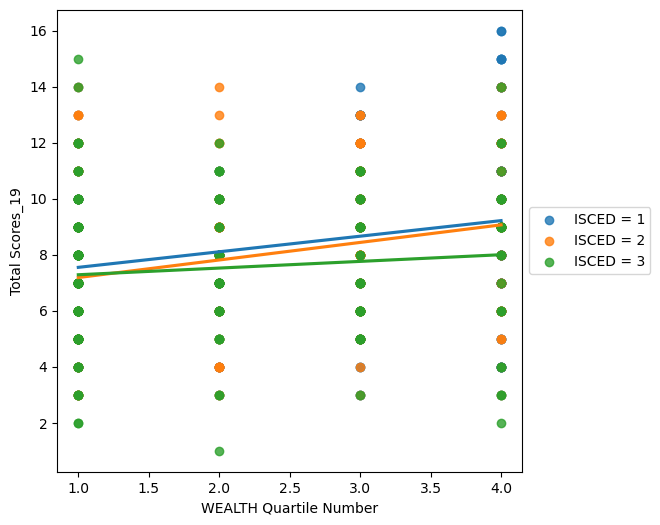

In [125]:
# Trend line for Absolute Tota Facet Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITH scatter

fig, ax7 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[df4['isced']==1]['TotalScore_19'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 1')
sns.regplot (data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[df4['isced']==2]['TotalScore_19'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 2')
sns.regplot (data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[df4['isced']==3]['TotalScore_19'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 3')

ax7.set(ylabel='Total Scores_19', xlabel='WEALTH Quartile Number')
ax7.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

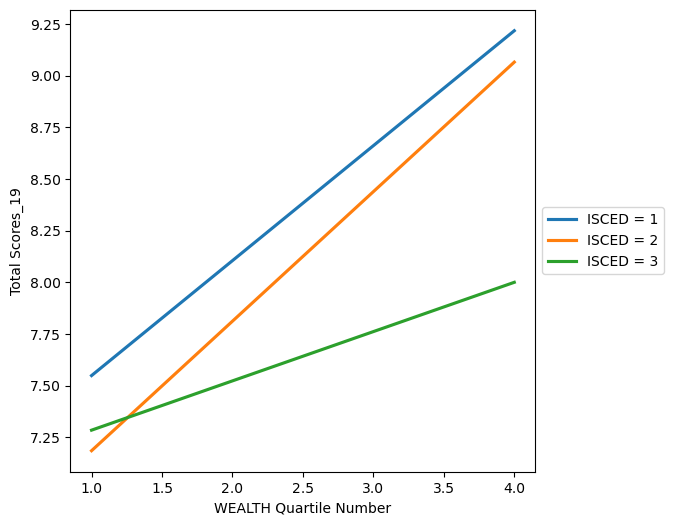

In [126]:
# Trend line for Absolute Tota Facet Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITHOUT scatter

fig, ax8 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = 'TotalScore_19', fit_reg=True, ci=None, ax=ax8, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = 'TotalScore_19', fit_reg=True, ci=None, ax=ax8, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = 'TotalScore_19', fit_reg=True, ci=None, ax=ax8, label='ISCED = 3')

ax8.set(ylabel='Total Scores_19', xlabel='WEALTH Quartile Number')
ax8.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

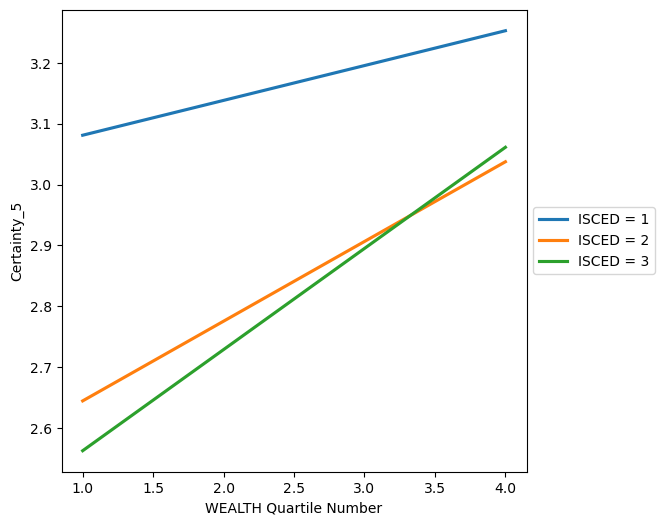

In [127]:
# Trend line for Absolute Certainty Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITHOUT scatter

fig, ax9 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 3')

ax9.set(ylabel='Certainty_5', xlabel='WEALTH Quartile Number')
ax9.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

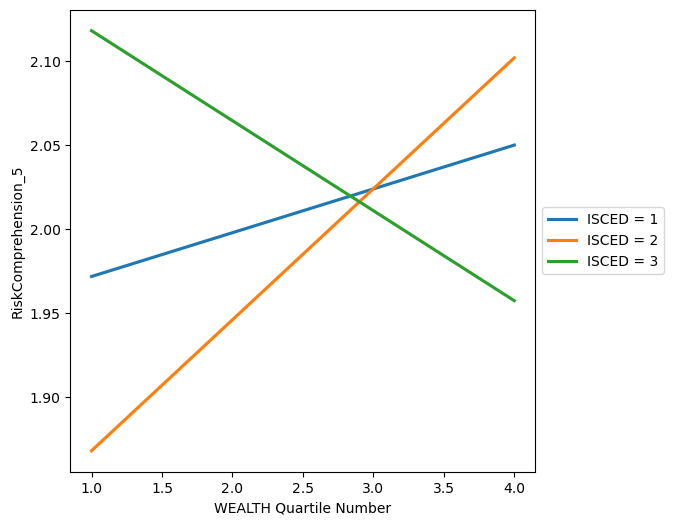

In [128]:
# Trend line for Absolute Risk Comprehension Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITHOUT scatter

fig, ax10 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 3')

ax10.set(ylabel='RiskComprehension_5', xlabel='WEALTH Quartile Number')
ax10.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

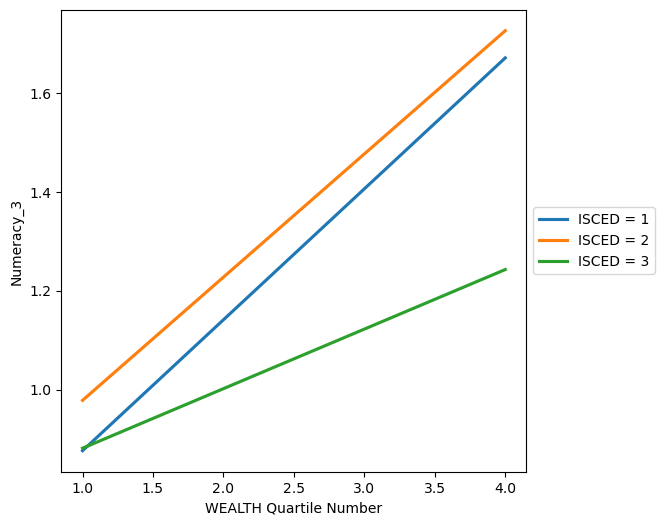

In [129]:
# Trend line for Absolute Number Comprehension Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='Numeracy_3', xlabel='WEALTH Quartile Number')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

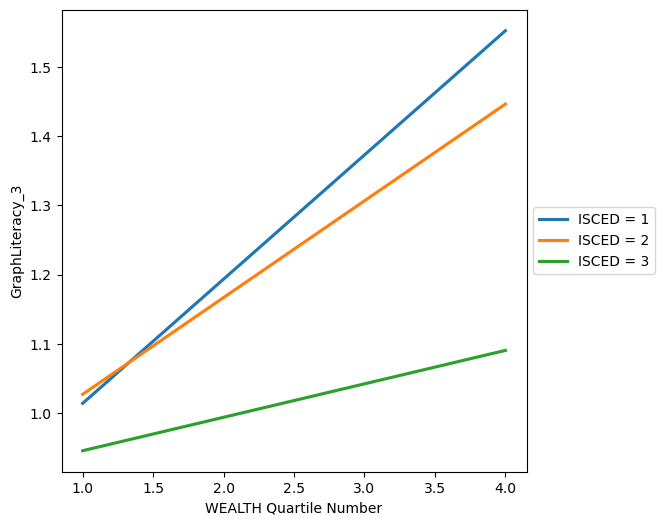

In [130]:
# Trend line for Absolute Graph Comprehension Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='GraphLiteracy_3', xlabel='WEALTH Quartile Number')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

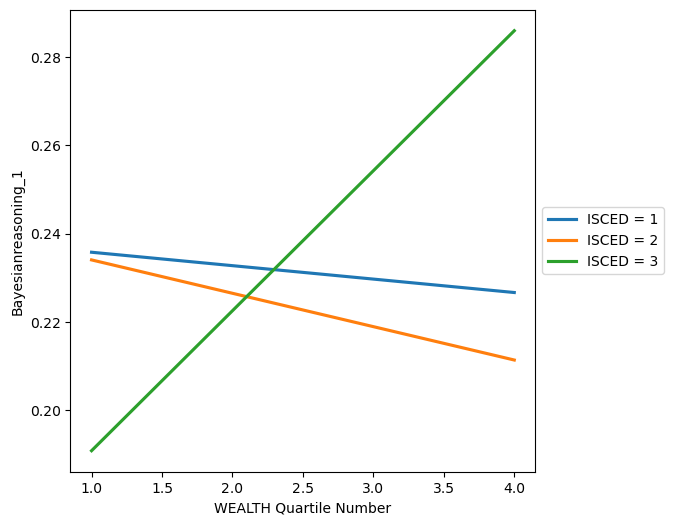

In [131]:
# Trend line for Absolute Bayesian Reasoning Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITHOUT scatter

fig, ax12 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 3')

ax12.set(ylabel='Bayesianreasoning_1', xlabel='WEALTH Quartile Number')
ax12.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [132]:
df4

ResponseId   age  age_rec  isced  income      wealth  Certainty_5  \
0           369  40.0        3      3       2      5000.0            3   
1           391  52.0        3      3       4      5000.0            4   
2           393  18.0        2      3       1      5000.0            1   
3           405  18.0        2      2       1      5000.0            2   
4           406  27.0        2      2       1      5000.0            2   
..          ...   ...      ...    ...     ...         ...          ...   
694         608  50.0        3      1       5  15000000.0            3   
695         256  18.0        2      3       2  15000000.0            3   
696         602  33.0        2      1       2  15000000.0            4   
697         598  27.0        2      1       5  15000000.0            2   
698         349  37.0        3      3       2  15000000.0            0   

     Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_3  \
0                0                    2                0           1   
1                0                    2                2           0   
2                0                    3                1           0   
3                1                    1                1           0   
4                1                    3                2           0   
..             ...                  ...              ...         ...   
694              2                    2                3           3   
695              1                    2                2           0   
696              0                    2                1           2   
697              0                    2                1           3   
698              0                    1                1           0   

     Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
0                      0         60.0            0.0                 40.0   
1                      0         80.0            0.0                 40.0   
2                      0         20.0            0.0                 60.0   
3                      0         40.0           50.0                 20.0   
4                      0         40.0           50.0                 60.0   
..                   ...          ...            ...                  ...   
694                    0         60.0          100.0                 40.0   
695                    0         60.0           50.0                 40.0   
696                    0         80.0            0.0                 40.0   
697                    1         40.0            0.0                 40.0   
698                    0          0.0            0.0                 20.0   

     GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_19  \
0           0.000000   33.333333                  0.0              6   
1          66.666667    0.000000                  0.0              8   
2          33.333333    0.000000                  0.0              5   
3          33.333333    0.000000                  0.0              5   
4          66.666667    0.000000                  0.0              8   
..               ...         ...                  ...            ...   
694       100.000000  100.000000                  0.0             13   
695        66.666667    0.000000                  0.0              8   
696        33.333333   66.666667                  0.0              9   
697        33.333333  100.000000                100.0              9   
698        33.333333    0.000000                  0.0              2   

     TotalScore_%  Quartile Number  
0       31.578947                1  
1       42.105263                1  
2       26.315789                1  
3       26.315789                1  
4       42.105263                1  
..            ...              ...  
694     68.421053                4  
695     42.105263                4  
696     47.368421                4  
697     47.368421                4  
698     10.526316                4  

[699 rows x 21 c

In [133]:
# Since we already have a classification for Age groups in the form of age_rec, we will use that.
# We will also use median of age to see if it yields any relevant results, as instructed.

# AXES to be used = Age or age groups, ISCED, Income

# Age groups = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 59 y/o
# Age group 4 = 60 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)



In [134]:
df4.loc[(df4['age_rec']==2)].describe()

ResponseId         age  age_rec       isced      income        wealth  \
count  425.000000  425.000000    425.0  425.000000  425.000000  4.250000e+02   
mean   355.920000   27.917647      2.0    1.912941    2.527059  2.710800e+06   
std    197.921459    4.729005      0.0    0.776693    1.455260  4.405788e+06   
min      0.000000   18.000000      2.0    1.000000    1.000000  5.000000e+03   
25%    204.000000   24.000000      2.0    1.000000    1.000000  1.000000e+05   
50%    364.000000   28.000000      2.0    2.000000    2.000000  5.000000e+05   
75%    518.000000   32.000000      2.0    3.000000    3.000000  3.000000e+06   
max    698.000000   35.000000      2.0    3.000000    6.000000  1.500000e+07   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   425.000000     425.000000           425.000000       425.000000   
mean      2.908235       0.454118             1.981176         1.164706   
std       1.412062       0.613056             0.764559         0.957186   
min       0.000000       0.000000             1.000000         0.000000   
25%       2.000000       0.000000             1.000000         0.000000   
50%       3.000000       0.000000             2.000000         1.000000   
75%       4.000000       1.000000             2.000000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_3  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  425.000000           425.000000   425.000000     425.000000   
mean     1.225882             0.249412    58.164706      22.705882   
std      1.122576             0.433182    28.241231      30.652812   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    40.000000       0.000000   
50%      1.000000             0.000000    60.000000       0.000000   
75%      2.000000             0.000000    80.000000      50.000000   
max      3.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           425.000000       425.000000  425.000000           425.000000   
mean             39.623529        38.823529   40.862745            24.941176   
std              15.291180        31.906186   37.419210            43.318248   
min              20.000000         0.000000    0.000000             0.000000   
25%              20.000000         0.000000    0.000000             0.000000   
50%              40.000000        33.333333   33.333333             0.000000   
75%              40.000000        66.666667   66.666667             0.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_19  TotalScore_%  Quartile Number  
count     425.000000    425.000000       425.000000  
mean        7.983529     42.018576         2.317647  
std         2.610250     13.738160         1.163637  
min         2.000000     10.526316         1.000000  
25%         6.000000     31.578947         1.000000  
50%         8.000000     42.105263         2.000000  
75%        10.000000     52.631579         3.000000  
max        16.000000     84.210526         4.000000

In [135]:
df4.loc[(df4['age_rec']==3)].describe()

ResponseId         age  age_rec       isced      income        wealth  \
count  229.000000  229.000000    229.0  229.000000  229.000000  2.290000e+02   
mean   340.087336   43.104803      3.0    1.934498    2.759825  3.848231e+06   
std    208.893474    5.013790      0.0    0.858440    1.518584  5.291885e+06   
min      1.000000   36.000000      3.0    1.000000    1.000000  5.000000e+03   
25%    155.000000   39.000000      3.0    1.000000    2.000000  1.000000e+05   
50%    336.000000   42.000000      3.0    2.000000    2.000000  1.000000e+06   
75%    546.000000   46.000000      3.0    3.000000    4.000000  5.000000e+06   
max    696.000000   55.000000      3.0    3.000000    6.000000  1.500000e+07   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   229.000000     229.000000           229.000000       229.000000   
mean      3.056769       0.427948             2.052402         1.183406   
std       1.475326       0.635434             0.776212         0.960393   
min       0.000000       0.000000             1.000000         0.000000   
25%       2.000000       0.000000             2.000000         0.000000   
50%       3.000000       0.000000             2.000000         1.000000   
75%       4.000000       1.000000             3.000000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_3  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  229.000000           229.000000   229.000000     229.000000   
mean     1.222707             0.192140    61.135371      21.397380   
std      1.107474             0.394845    29.506526      31.771721   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    40.000000       0.000000   
50%      1.000000             0.000000    60.000000       0.000000   
75%      2.000000             0.000000    80.000000      50.000000   
max      3.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           229.000000       229.000000  229.000000           229.000000   
mean             41.048035        39.446870   40.756914            19.213974   
std              15.524241        32.013105   36.915815            39.484536   
min              20.000000         0.000000    0.000000             0.000000   
25%              40.000000         0.000000    0.000000             0.000000   
50%              40.000000        33.333333   33.333333             0.000000   
75%              60.000000        66.666667   66.666667             0.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_19  TotalScore_%  Quartile Number  
count     229.000000    229.000000       229.000000  
mean        8.135371     42.817743         2.589520  
std         2.731239     14.374940         1.183614  
min         1.000000      5.263158         1.000000  
25%         6.000000     31.578947         1.000000  
50%         8.000000     42.105263         3.000000  
75%        10.000000     52.631579         4.000000  
max        16.000000     84.210526         4.000000

In [136]:
df4.loc[(df4['age_rec']==4)].describe()

ResponseId        age  age_rec      isced     income        wealth  \
count   45.000000  45.000000     45.0  45.000000  45.000000  4.500000e+01   
mean   329.000000  63.666667      4.0   2.133333   1.955556  3.426311e+06   
std    204.826867   4.866397      0.0   0.814639   1.330679  4.933746e+06   
min      5.000000  57.000000      4.0   1.000000   1.000000  5.000000e+03   
25%    156.000000  60.000000      4.0   1.000000   1.000000  2.500000e+05   
50%    310.000000  63.000000      4.0   2.000000   1.000000  1.000000e+06   
75%    529.000000  67.000000      4.0   3.000000   2.000000  4.500000e+06   
max    678.000000  75.000000      4.0   3.000000   6.000000  1.500000e+07   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count    45.000000      45.000000            45.000000        45.000000   
mean      2.422222       0.844444             2.155556         1.555556   
std       1.671810       0.796457             0.767391         0.840875   
min       0.000000       0.000000             1.000000         0.000000   
25%       1.000000       0.000000             2.000000         1.000000   
50%       3.000000       1.000000             2.000000         2.000000   
75%       4.000000       1.000000             3.000000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_3  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count   45.000000            45.000000    45.000000      45.000000   
mean     1.444444             0.177778    48.444444      42.222222   
std      1.056486             0.386646    33.436205      39.822840   
min      0.000000             0.000000     0.000000       0.000000   
25%      1.000000             0.000000    20.000000       0.000000   
50%      1.000000             0.000000    60.000000      50.000000   
75%      2.000000             0.000000    80.000000      50.000000   
max      3.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count            45.000000        45.000000   45.000000            45.000000   
mean             43.111111        51.851852   48.148148            17.777778   
std              15.347819        28.029166   35.216183            38.664577   
min              20.000000         0.000000    0.000000             0.000000   
25%              40.000000        33.333333   33.333333             0.000000   
50%              40.000000        66.666667   33.333333             0.000000   
75%              60.000000        66.666667   66.666667             0.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_19  TotalScore_%  Quartile Number  
count      45.000000     45.000000        45.000000  
mean        8.600000     45.263158         2.555556  
std         2.957271     15.564587         1.159066  
min         3.000000     15.789474         1.000000  
25%         6.000000     31.578947         2.000000  
50%         9.000000     47.368421         3.000000  
75%        11.000000     57.894737         4.000000  
max        14.000000     73.684211         4.000000

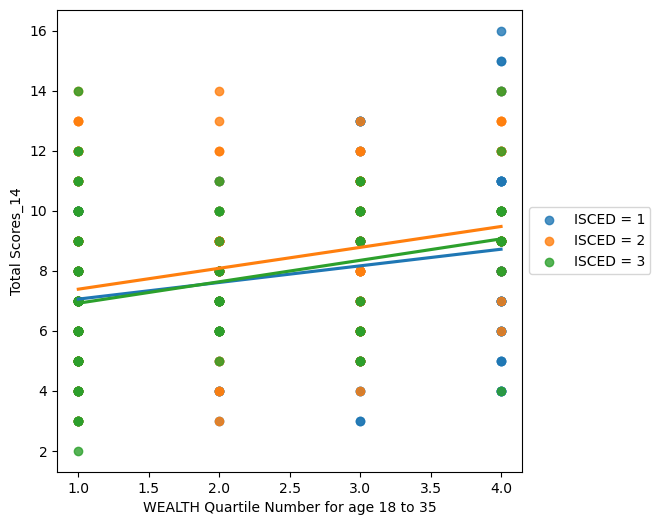

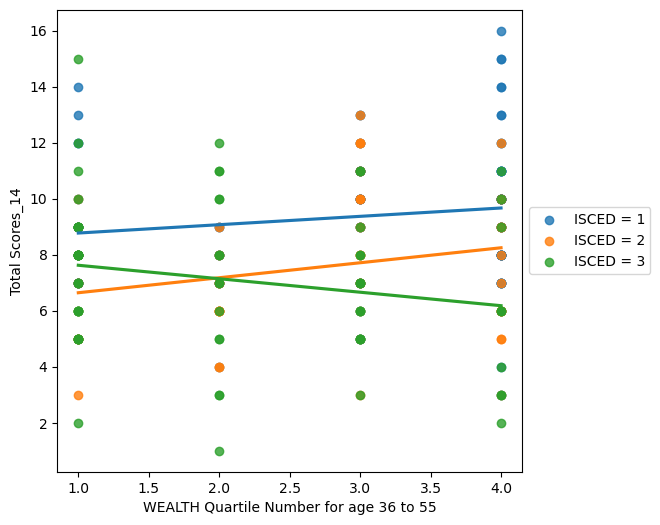

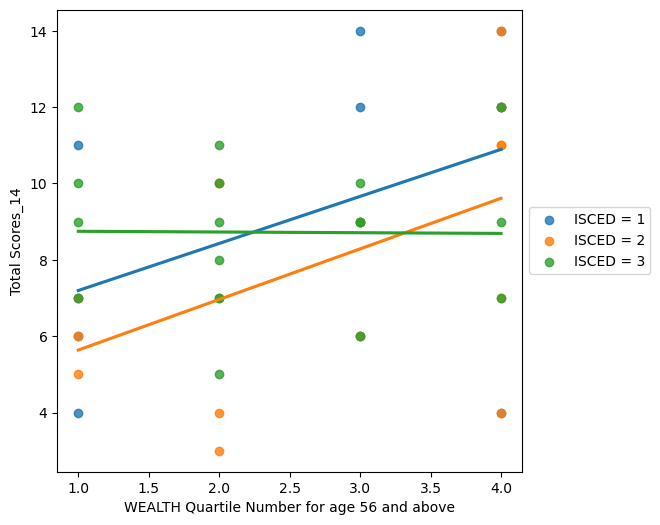

In [137]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Total Scores_14', xlabel='WEALTH Quartile Number for age 18 to 35')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_14', xlabel='WEALTH Quartile Number for age 36 to 55')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Total Scores_14', xlabel='WEALTH Quartile Number for age 56 and above')
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

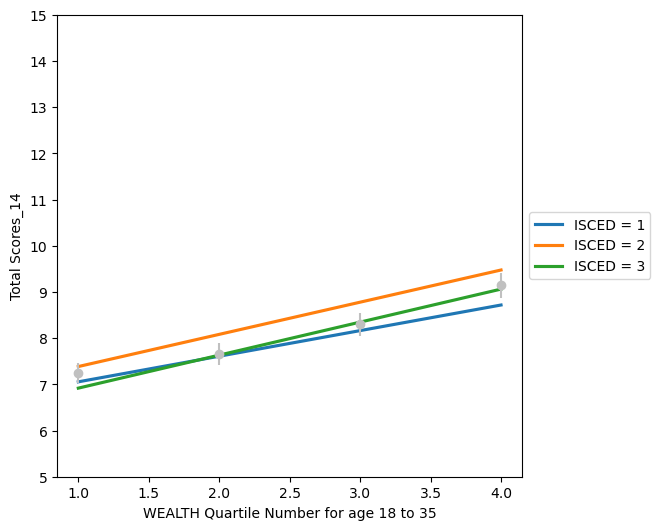

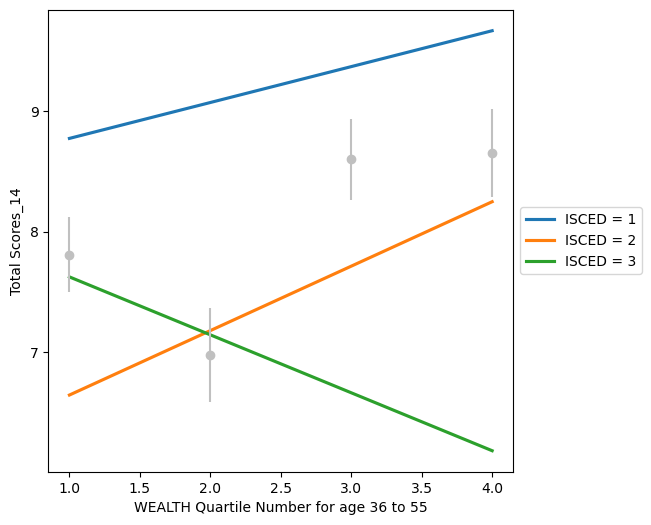

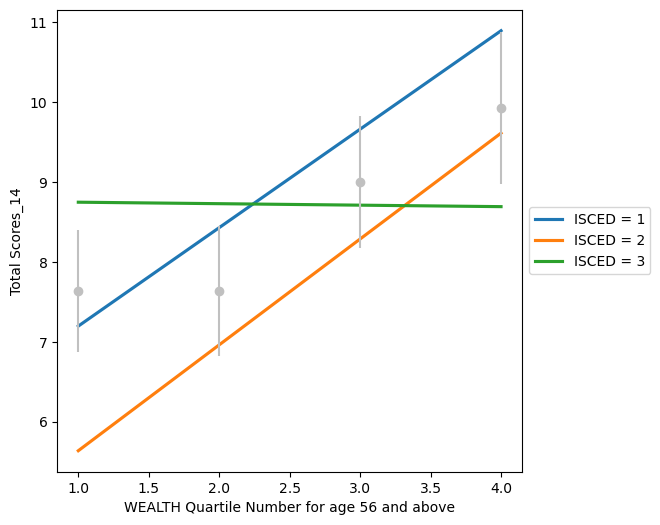

In [138]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ df4['age_rec']==2  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==2  ].groupby(['Quartile Number']).mean(numeric_only=True)['TotalScore_19'], yerr = df4.loc[ (df4['age_rec']==2) ].groupby(['Quartile Number'])['TotalScore_19'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Total Scores_14', xlabel='WEALTH Quartile Number for age 18 to 35',  yticks = np.arange(5, 16 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_14', xlabel='WEALTH Quartile Number for age 36 to 55',  yticks = np.arange(5, 16 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df4.loc[ df4['age_rec']==3  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==3  ].groupby(['Quartile Number']).mean(numeric_only=True)['TotalScore_19'], yerr = df4.loc[ (df4['age_rec']==3) ].groupby(['Quartile Number'])['TotalScore_19'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Total Scores_14', xlabel='WEALTH Quartile Number for age 56 and above',  yticks = np.arange(5, 16 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df4.loc[ df4['age_rec']== 4 ]['Quartile Number'].unique(), y = df4.loc[ df4['age_rec']==4  ].groupby(['Quartile Number']).mean(numeric_only=True)['TotalScore_19'], yerr = df4.loc[ (df4['age_rec']==4) ].groupby(['Quartile Number'])['TotalScore_19'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

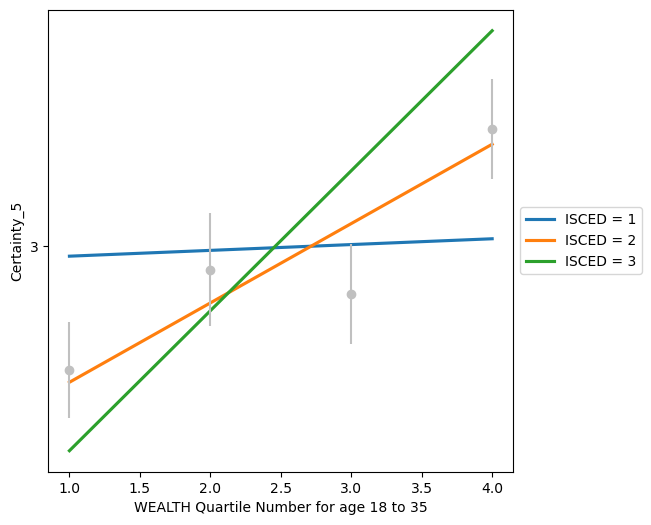

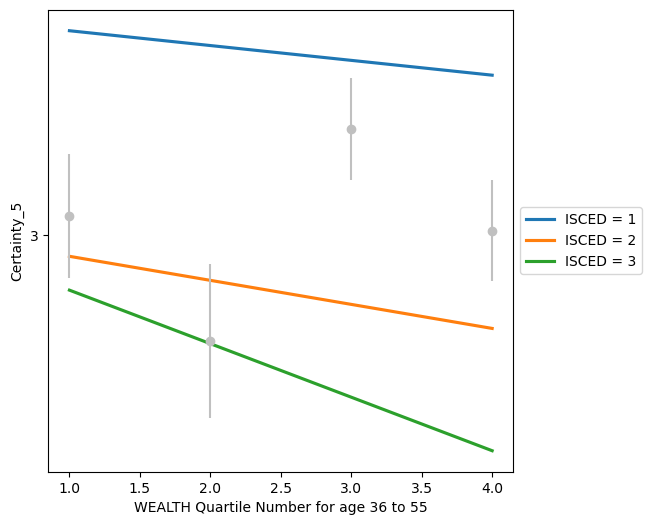

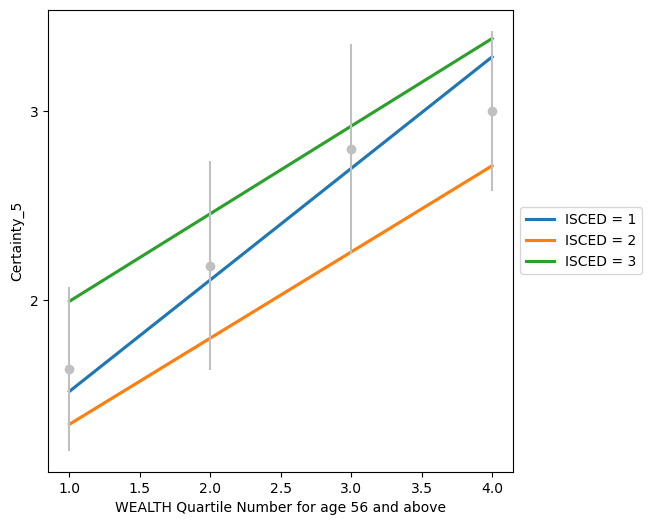

In [139]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Certainty_5', xlabel='WEALTH Quartile Number for age 18 to 35',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df4.loc[ df4['age_rec']==2  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==2  ].groupby(['Quartile Number'])['Certainty_5'].mean(), yerr = df4.loc[ (df4['age_rec']==2) ].groupby(['Quartile Number'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Certainty_5', xlabel='WEALTH Quartile Number for age 36 to 55',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df4.loc[ df4['age_rec']==3  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==3  ].groupby(['Quartile Number'])['Certainty_5'].mean(), yerr = df4.loc[ (df4['age_rec']==3) ].groupby(['Quartile Number'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Certainty_5', xlabel='WEALTH Quartile Number for age 56 and above',  yticks = np.arange(0, 6 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df4.loc[ df4['age_rec']== 4 ]['Quartile Number'].unique(), y = df4.loc[ df4['age_rec']==4  ].groupby(['Quartile Number'])['Certainty_5'].mean(), yerr = df4.loc[ (df4['age_rec']==4) ].groupby(['Quartile Number'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

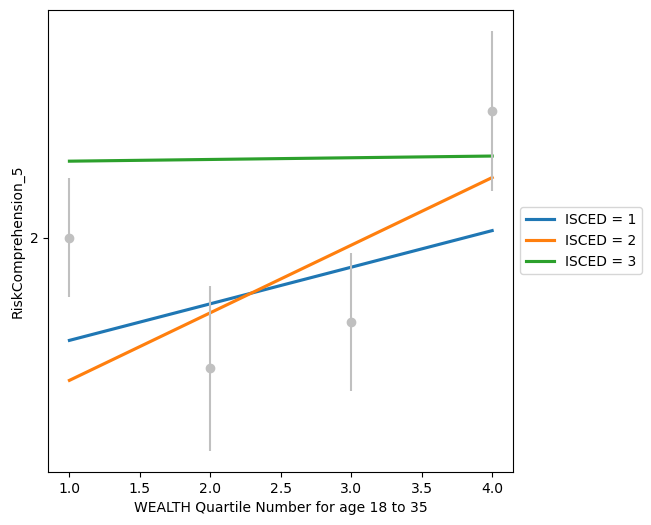

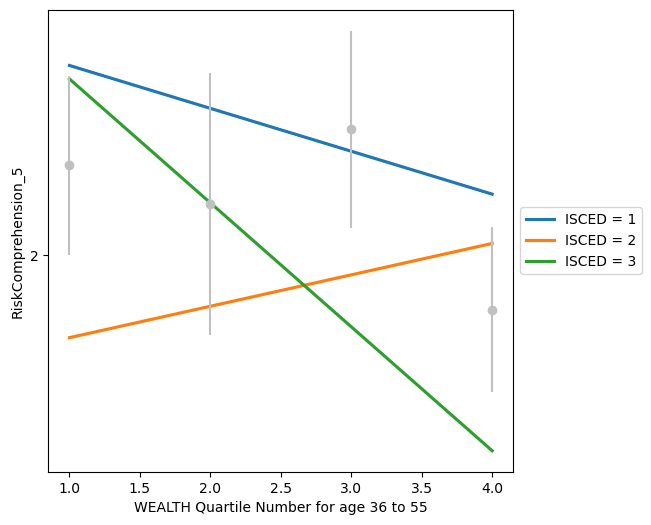

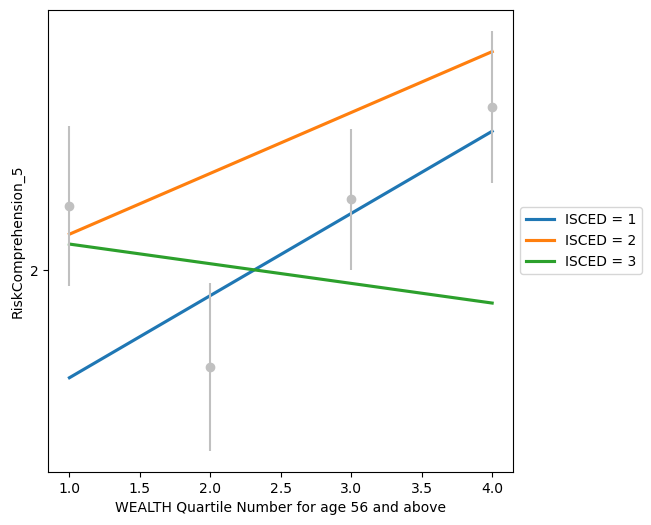

In [140]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='RiskComprehension_5', xlabel='WEALTH Quartile Number for age 18 to 35',  yticks = np.arange(0, 3 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df4.loc[ df4['age_rec']==2  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==2  ].groupby(['Quartile Number'])['RiskComprehension_5'].mean(), yerr = df4.loc[ (df4['age_rec']==2) ].groupby(['Quartile Number'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='RiskComprehension_5', xlabel='WEALTH Quartile Number for age 36 to 55',  yticks = np.arange(0, 3 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df4.loc[ df4['age_rec']==3  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==3  ].groupby(['Quartile Number'])['RiskComprehension_5'].mean(), yerr = df4.loc[ (df4['age_rec']==3) ].groupby(['Quartile Number'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='RiskComprehension_5', xlabel='WEALTH Quartile Number for age 56 and above',  yticks = np.arange(0, 3 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df4.loc[ df4['age_rec']== 4 ]['Quartile Number'].unique(), y = df4.loc[ df4['age_rec']==4  ].groupby(['Quartile Number'])['RiskComprehension_5'].mean(), yerr = df4.loc[ (df4['age_rec']==4) ].groupby(['Quartile Number'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

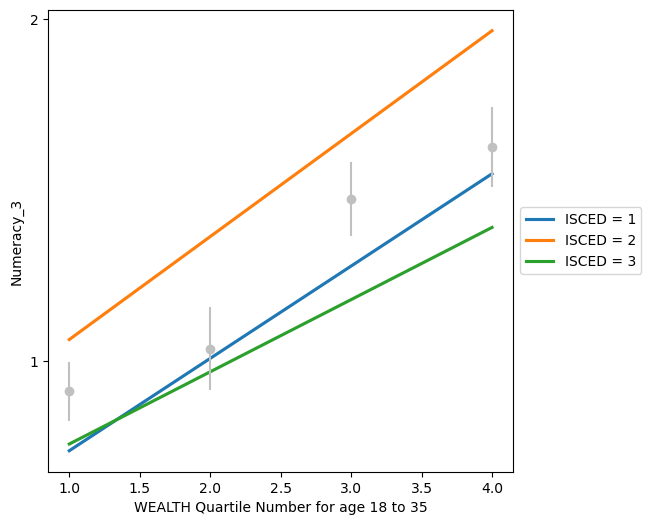

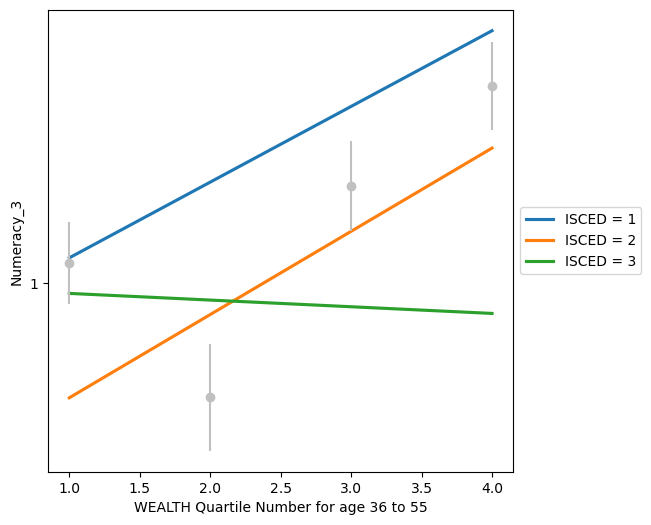

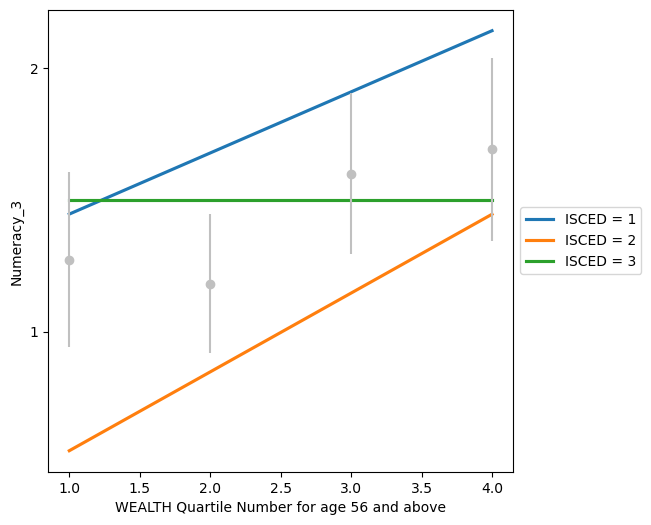

In [141]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Numeracy_3', xlabel='WEALTH Quartile Number for age 18 to 35',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df4.loc[ df4['age_rec']==2  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==2  ].groupby(['Quartile Number'])['Numeracy_3'].mean(), yerr = df4.loc[ (df4['age_rec']==2) ].groupby(['Quartile Number'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Numeracy_3', xlabel='WEALTH Quartile Number for age 36 to 55',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df4.loc[ df4['age_rec']==3  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==3  ].groupby(['Quartile Number'])['Numeracy_3'].mean(), yerr = df4.loc[ (df4['age_rec']==3) ].groupby(['Quartile Number'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Numeracy_3', xlabel='WEALTH Quartile Number for age 56 and above',  yticks = np.arange(0, 6 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df4.loc[ df4['age_rec']== 4 ]['Quartile Number'].unique(), y = df4.loc[ df4['age_rec']==4  ].groupby(['Quartile Number'])['Numeracy_3'].mean(), yerr = df4.loc[ (df4['age_rec']==4) ].groupby(['Quartile Number'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

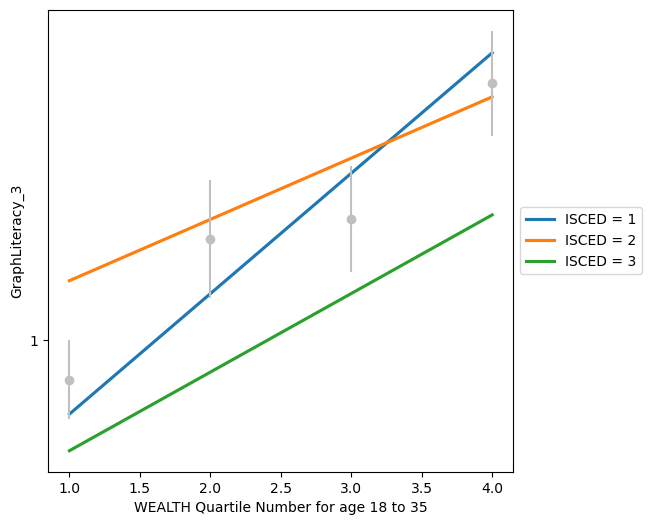

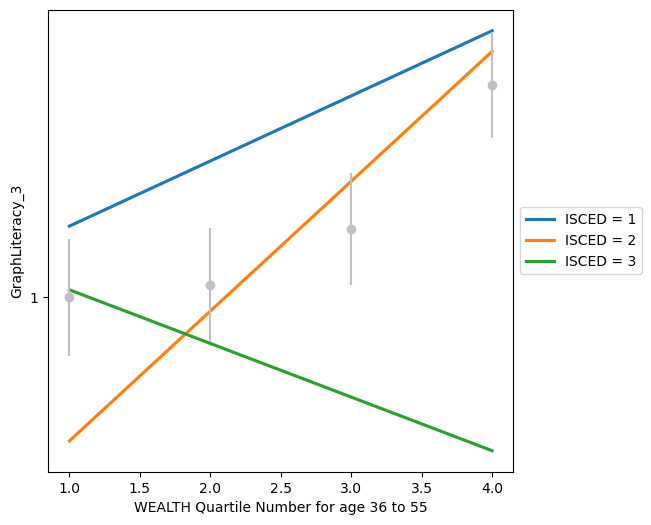

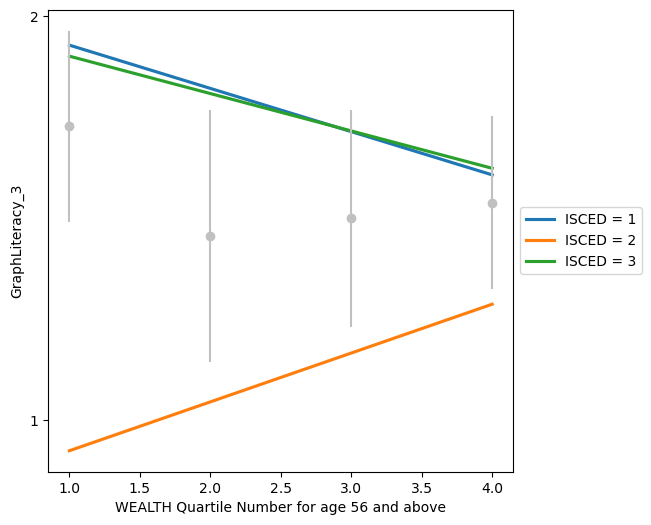

In [142]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='GraphLiteracy_3', xlabel='WEALTH Quartile Number for age 18 to 35',  yticks = np.arange(0, 4 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df4.loc[ df4['age_rec']==2  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==2  ].groupby(['Quartile Number'])['GraphLiteracy_3'].mean(), yerr = df4.loc[ (df4['age_rec']==2) ].groupby(['Quartile Number'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='GraphLiteracy_3', xlabel='WEALTH Quartile Number for age 36 to 55',  yticks = np.arange(0, 4 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df4.loc[ df4['age_rec']==3  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==3  ].groupby(['Quartile Number'])['GraphLiteracy_3'].mean(), yerr = df4.loc[ (df4['age_rec']==3) ].groupby(['Quartile Number'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='GraphLiteracy_3', xlabel='WEALTH Quartile Number for age 56 and above',  yticks = np.arange(0, 4 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df4.loc[ df4['age_rec']== 4 ]['Quartile Number'].unique(), y = df4.loc[ df4['age_rec']==4  ].groupby(['Quartile Number'])['GraphLiteracy_3'].mean(), yerr = df4.loc[ (df4['age_rec']==4) ].groupby(['Quartile Number'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

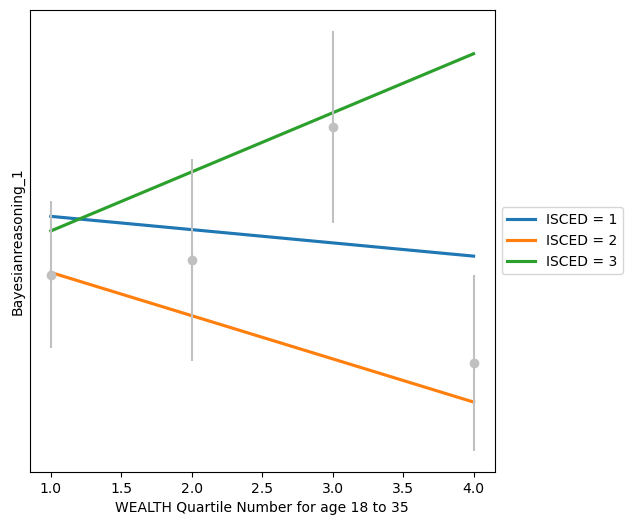

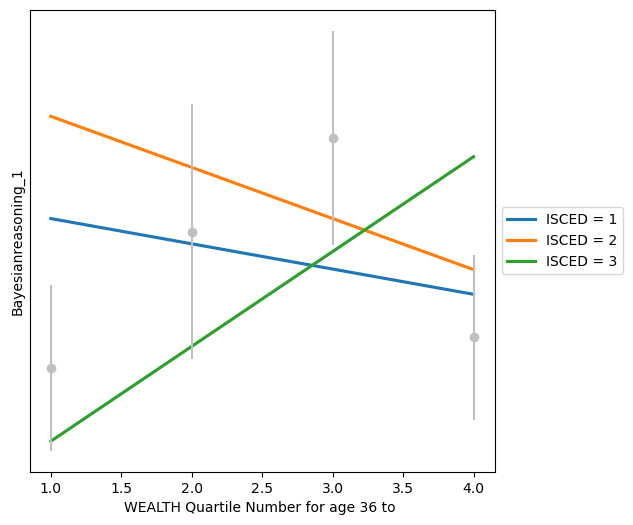

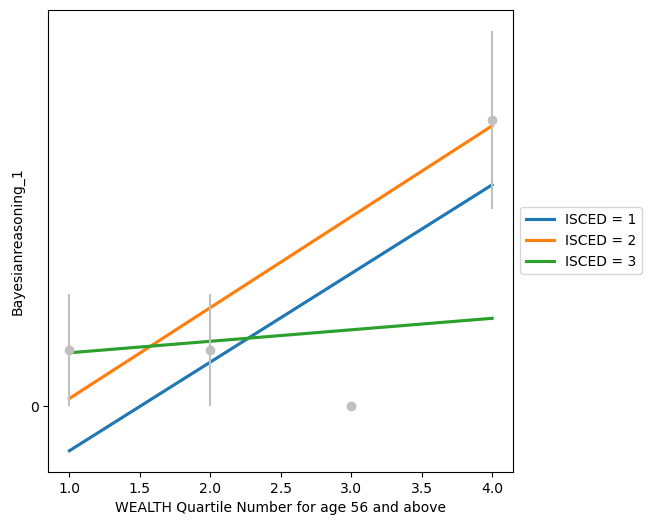

In [143]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Bayesianreasoning_1', xlabel='WEALTH Quartile Number for age 18 to 35',  yticks = np.arange(0, 5 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df4.loc[ df4['age_rec']==2  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==2  ].groupby(['Quartile Number'])['Bayesianreasoning_1'].mean(), yerr = df4.loc[ (df4['age_rec']==2) ].groupby(['Quartile Number'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Bayesianreasoning_1', xlabel='WEALTH Quartile Number for age 36 to ',  yticks = np.arange(0, 5 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df4.loc[ df4['age_rec']==3  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==3  ].groupby(['Quartile Number'])['Bayesianreasoning_1'].mean(), yerr = df4.loc[ (df4['age_rec']==3) ].groupby(['Quartile Number'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Bayesianreasoning_1', xlabel='WEALTH Quartile Number for age 56 and above',  yticks = np.arange(0, 5 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df4.loc[ df4['age_rec']== 4 ]['Quartile Number'].unique(), y = df4.loc[ df4['age_rec']==4  ].groupby(['Quartile Number'])['Bayesianreasoning_1'].mean(), yerr = df4.loc[ (df4['age_rec']==4) ].groupby(['Quartile Number'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

In [144]:
# Age mean method
# Age_mean

In [145]:
age_m = df2["age"].median()
age_m

33.0

In [146]:
df4["Quartile Number"].value_counts()

Quartile Number
1    224
3    173
4    173
2    129
Name: count, dtype: int64

In [147]:
df4.loc[(df4['age'] < age_m)].describe()

ResponseId         age  age_rec       isced      income        wealth  \
count  338.000000  338.000000    338.0  338.000000  338.000000  3.380000e+02   
mean   345.745562   26.260355      2.0    1.970414    2.349112  2.412677e+06   
std    194.884917    3.812788      0.0    0.762053    1.365976  4.184664e+06   
min      0.000000   18.000000      2.0    1.000000    1.000000  5.000000e+03   
25%    205.250000   24.000000      2.0    1.000000    1.000000  7.000000e+04   
50%    343.500000   26.000000      2.0    2.000000    2.000000  5.000000e+05   
75%    509.500000   30.000000      2.0    3.000000    3.000000  2.500000e+06   
max    693.000000   32.000000      2.0    3.000000    6.000000  1.500000e+07   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   338.000000     338.000000           338.000000       338.000000   
mean      2.855030       0.470414             1.946746         1.171598   
std       1.420386       0.616788             0.744996         0.956079   
min       0.000000       0.000000             1.000000         0.000000   
25%       2.000000       0.000000             1.000000         0.000000   
50%       3.000000       0.000000             2.000000         1.000000   
75%       4.000000       1.000000             2.000000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_3  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  338.000000           338.000000   338.000000     338.000000   
mean     1.251479             0.260355    57.100592      23.520710   
std      1.129092             0.439479    28.407723      30.839412   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    40.000000       0.000000   
50%      1.000000             0.000000    60.000000       0.000000   
75%      2.000000             1.000000    80.000000      50.000000   
max      3.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           338.000000       338.000000  338.000000           338.000000   
mean             38.934911        39.053254   41.715976            26.035503   
std              14.899920        31.869300   37.636410            43.947891   
min              20.000000         0.000000    0.000000             0.000000   
25%              20.000000         0.000000    0.000000             0.000000   
50%              40.000000        33.333333   33.333333             0.000000   
75%              40.000000        66.666667   66.666667           100.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_19  TotalScore_%  Quartile Number  
count     338.000000    338.000000       338.000000  
mean        7.955621     41.871691         2.242604  
std         2.507161     13.195587         1.132349  
min         2.000000     10.526316         1.000000  
25%         6.000000     31.578947         1.000000  
50%         8.000000     42.105263         2.000000  
75%        10.000000     52.631579         3.000000  
max        15.000000     78.947368         4.000000

In [148]:
df4.loc[(df4['age'] >= age_m)].describe()

ResponseId         age     age_rec       isced      income  \
count  361.000000  361.000000  361.000000  361.000000  361.000000   
mean   352.047091   43.559557    2.883657    1.900277    2.770083   
std    208.531334    9.491366    0.594217    0.847234    1.552701   
min      1.000000   33.000000    2.000000    1.000000    1.000000   
25%    162.000000   36.000000    3.000000    1.000000    2.000000   
50%    353.000000   41.000000    3.000000    2.000000    2.000000   
75%    547.000000   47.000000    3.000000    3.000000    4.000000   
max    698.000000   75.000000    4.000000    3.000000    6.000000   

             wealth  Certainty_5  Uncertainty_2  RiskComprehension_5  \
count  3.610000e+02   361.000000     361.000000           361.000000   
mean   3.800648e+06     2.991690       0.470914             2.080332   
std    5.176161e+06     1.487891       0.662371             0.786466   
min    5.000000e+03     0.000000       0.000000             1.000000   
25%    1.000000e+05     2.000000       0.000000             2.000000   
50%    1.000000e+06     3.000000       0.000000             2.000000   
75%    5.000000e+06     4.000000       1.000000             3.000000   
max    1.500000e+07     5.000000       2.000000             4.000000   

       GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  Certainty_%  \
count       361.000000  361.000000           361.000000   361.000000   
mean          1.218837    1.227147             0.193906    59.833795   
std           0.954102    1.099715             0.395905    29.757820   
min           0.000000    0.000000             0.000000     0.000000   
25%           0.000000    0.000000             0.000000    40.000000   
50%           1.000000    1.000000             0.000000    60.000000   
75%           2.000000    2.000000             0.000000    80.000000   
max           3.000000    3.000000             1.000000   100.000000   

       Uncertainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count     361.000000           361.000000       361.000000  361.000000   
mean       23.545706            41.606648        40.627886   40.904894   
std        33.118537            15.729320        31.803404   36.657152   
min         0.000000            20.000000         0.000000    0.000000   
25%         0.000000            40.000000         0.000000    0.000000   
50%         0.000000            40.000000        33.333333   33.333333   
75%        50.000000            60.000000        66.666667   66.666667   
max       100.000000            80.000000       100.000000  100.000000   

       Bayesianreasoning_%  TotalScore_19  TotalScore_%  Quartile Number  
count           361.000000     361.000000    361.000000       361.000000  
mean             19.390582       8.182825     43.067503         2.590028  
std              39.590471       2.820527     14.844877         1.191782  
min               0.000000       1.000000      5.263158         1.000000  
25%               0.000000       6.000000     31.578947         1.000000  
50%               0.000000       8.000000     42.105263         3.000000  
75%               0.000000      10.000000     52.631579         4.000000  
max             100.000000      16.000000     84.210526         4.000000

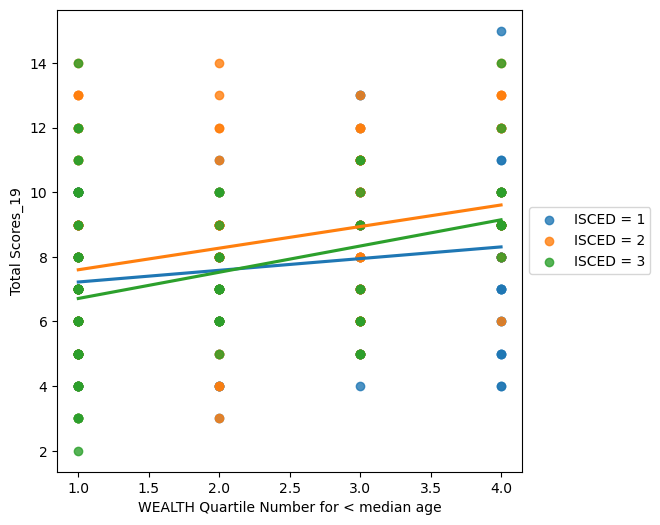

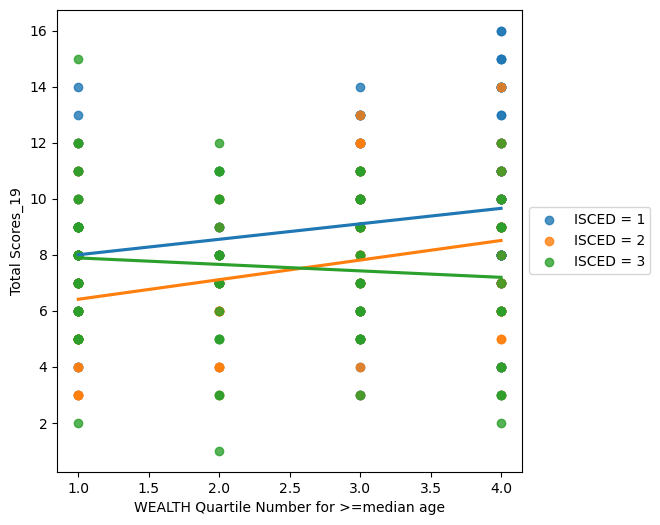

In [149]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Total Scores_19', xlabel='WEALTH Quartile Number for < median age')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[(df4['age'] >= age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_19', xlabel='WEALTH Quartile Number for >=median age')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

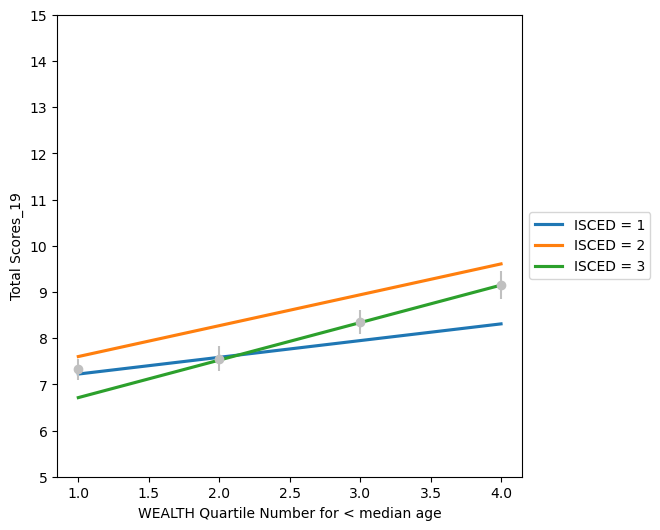

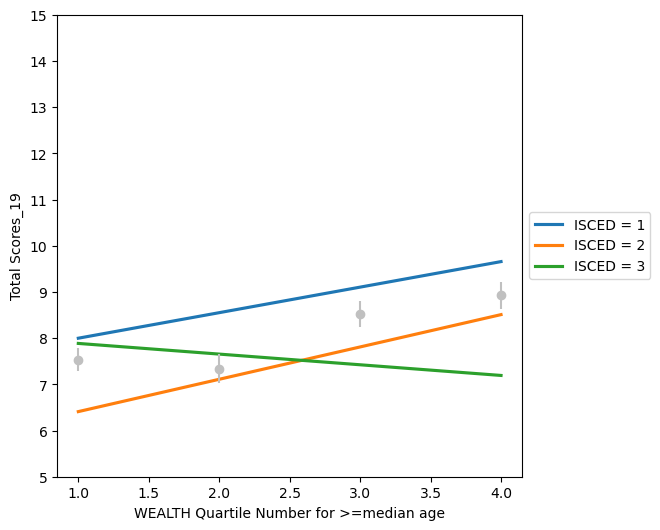

In [150]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ (df4['age'] < age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] < age_m)  ].groupby(['Quartile Number'])['TotalScore_19'].mean(), yerr = df4.loc[ (df4['age'] < age_m) ].groupby(['Quartile Number'])['TotalScore_19'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Total Scores_19', xlabel='WEALTH Quartile Number for < median age',  yticks = np.arange(5, 16 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['TotalScore_19'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df4.loc[ (df4['age'] >= age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] >=age_m)  ].groupby(['Quartile Number'])['TotalScore_19'].mean(), yerr = df4.loc[ (df4['age'] >=age_m) ].groupby(['Quartile Number'])['TotalScore_19'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Total Scores_19', xlabel='WEALTH Quartile Number for >=median age',  yticks = np.arange(5, 16 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

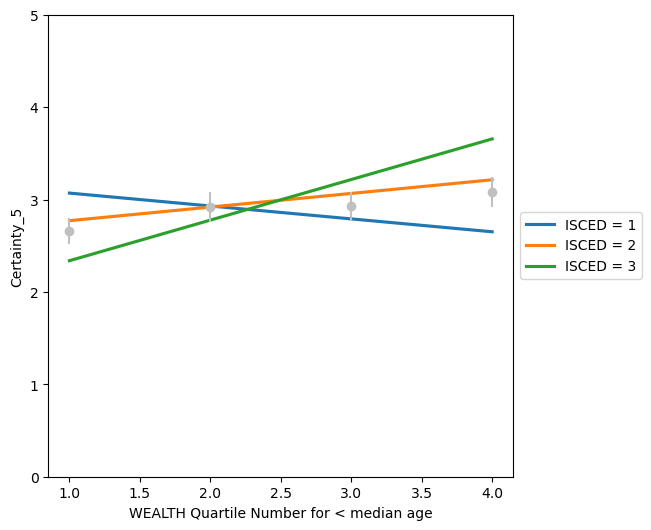

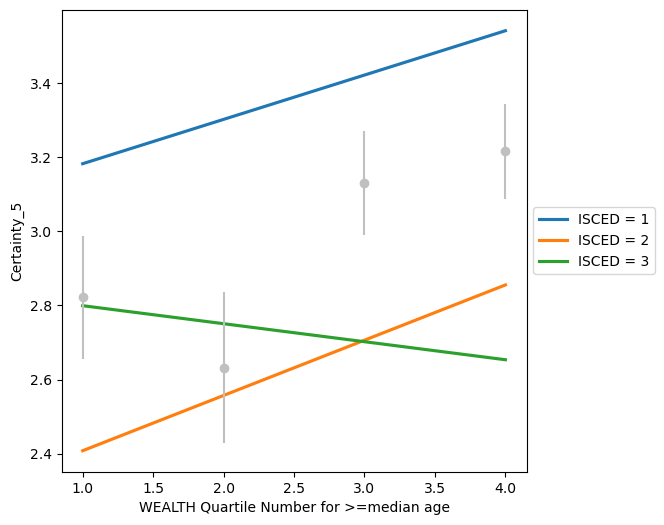

In [151]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ (df4['age'] < age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] < age_m)  ].groupby(['Quartile Number'])['Certainty_5'].mean(), yerr = df4.loc[ (df4['age'] < age_m) ].groupby(['Quartile Number'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Certainty_5', xlabel='WEALTH Quartile Number for < median age',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df4.loc[ (df4['age'] >= age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] >=age_m)  ].groupby(['Quartile Number'])['Certainty_5'].mean(), yerr = df4.loc[ (df4['age'] >=age_m) ].groupby(['Quartile Number'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Certainty_5', xlabel='WEALTH Quartile Number for >=median age')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

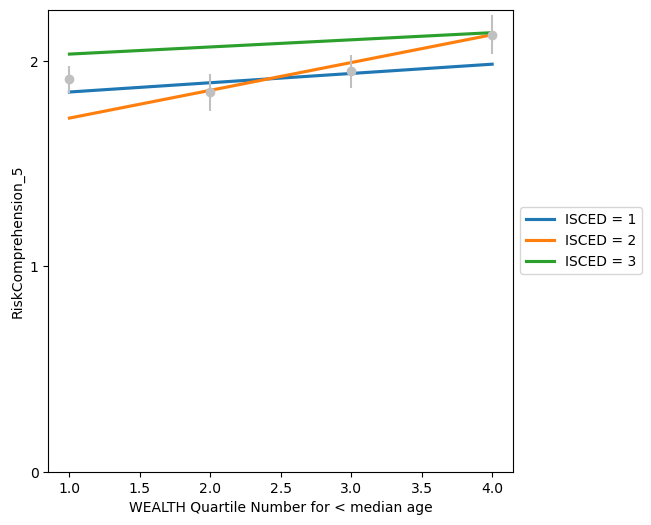

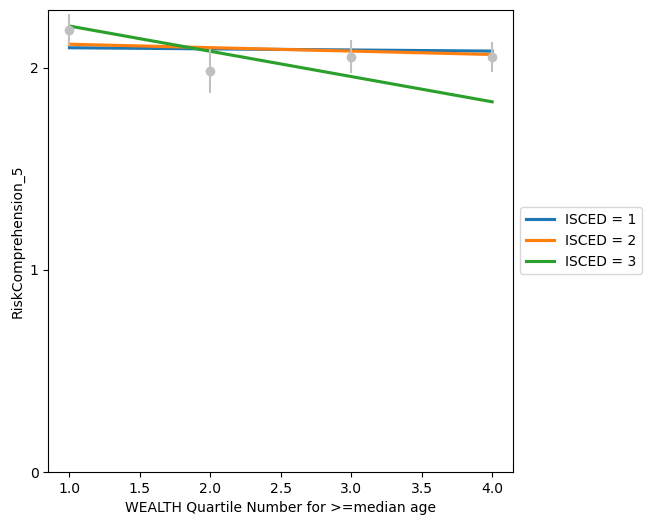

In [152]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ (df4['age'] < age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] < age_m)  ].groupby(['Quartile Number'])['RiskComprehension_5'].mean(), yerr = df4.loc[ (df4['age'] < age_m) ].groupby(['Quartile Number'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='RiskComprehension_5', xlabel='WEALTH Quartile Number for < median age',  yticks = np.arange(0, 3 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df4.loc[ (df4['age'] >= age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] >=age_m)  ].groupby(['Quartile Number'])['RiskComprehension_5'].mean(), yerr = df4.loc[ (df4['age'] >=age_m) ].groupby(['Quartile Number'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='RiskComprehension_5', xlabel='WEALTH Quartile Number for >=median age',  yticks = np.arange(0, 3 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

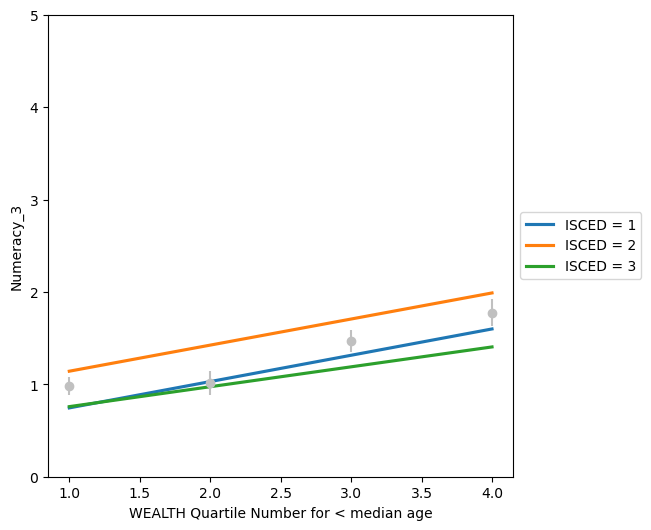

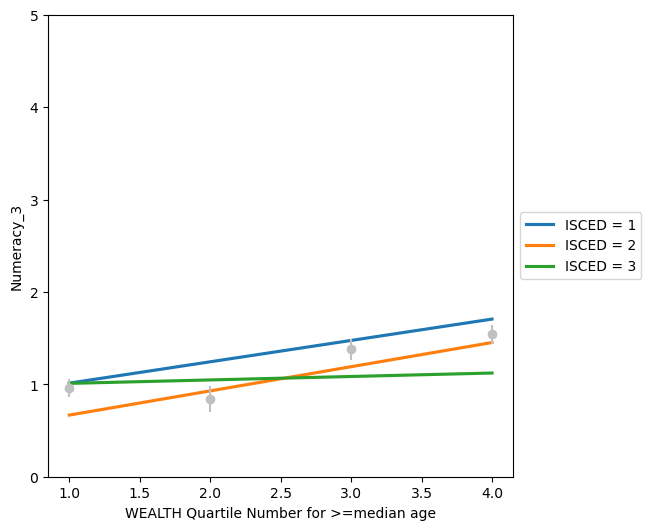

In [153]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ (df4['age'] < age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] < age_m)  ].groupby(['Quartile Number'])['Numeracy_3'].mean(), yerr = df4.loc[ (df4['age'] < age_m) ].groupby(['Quartile Number'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Numeracy_3', xlabel='WEALTH Quartile Number for < median age',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df4.loc[ (df4['age'] >= age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] >=age_m)  ].groupby(['Quartile Number'])['Numeracy_3'].mean(), yerr = df4.loc[ (df4['age'] >=age_m) ].groupby(['Quartile Number'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Numeracy_3', xlabel='WEALTH Quartile Number for >=median age',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

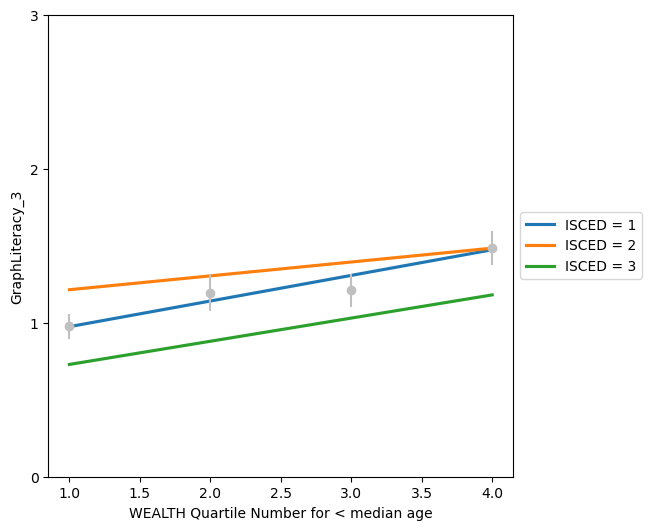

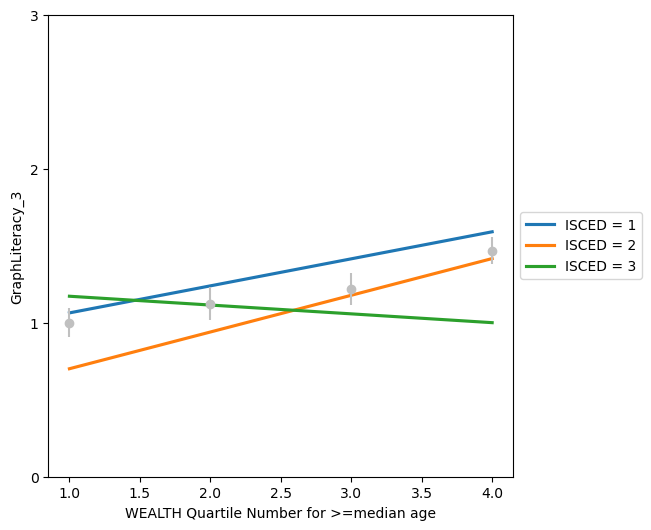

In [154]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ (df4['age'] < age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] < age_m)  ].groupby(['Quartile Number'])['GraphLiteracy_3'].mean(), yerr = df4.loc[ (df4['age'] < age_m) ].groupby(['Quartile Number'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='GraphLiteracy_3', xlabel='WEALTH Quartile Number for < median age',  yticks = np.arange(0, 4 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df4.loc[ (df4['age'] >= age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] >=age_m)  ].groupby(['Quartile Number'])['GraphLiteracy_3'].mean(), yerr = df4.loc[ (df4['age'] >=age_m) ].groupby(['Quartile Number'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='GraphLiteracy_3', xlabel='WEALTH Quartile Number for >=median age',  yticks = np.arange(0, 4 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

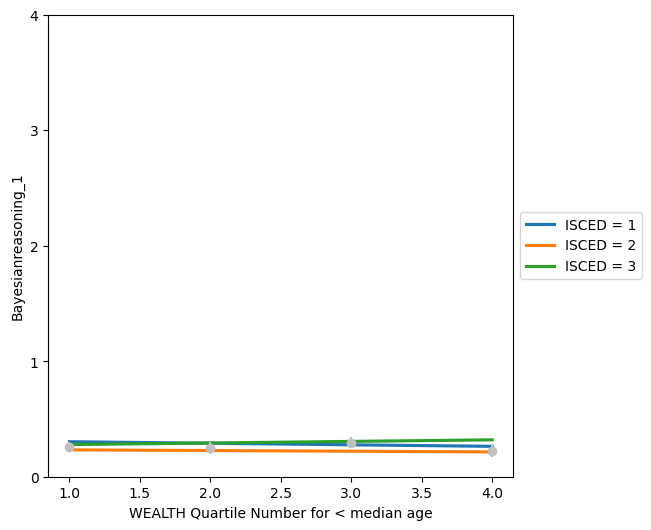

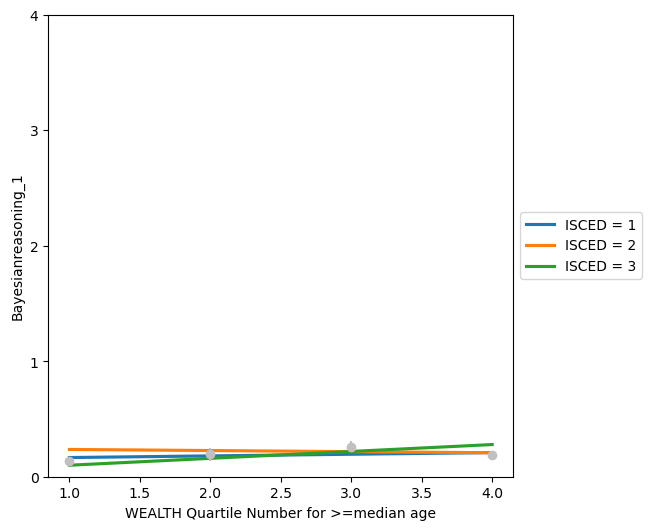

In [155]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ (df4['age'] < age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] < age_m)  ].groupby(['Quartile Number'])['Bayesianreasoning_1'].mean(), yerr = df4.loc[ (df4['age'] < age_m) ].groupby(['Quartile Number'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Bayesianreasoning_1', xlabel='WEALTH Quartile Number for < median age',  yticks = np.arange(0, 5 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df4.loc[ (df4['age'] >= age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] >=age_m)  ].groupby(['Quartile Number'])['Bayesianreasoning_1'].mean(), yerr = df4.loc[ (df4['age'] >=age_m) ].groupby(['Quartile Number'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Bayesianreasoning_1', xlabel='WEALTH Quartile Number for >=median age',  yticks = np.arange(0, 5 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()